In [1]:
# Соединить Weish и Weing данные
# Попробовать несколько датасетов
# Закодить новый алгоритм
# Добавить его в воркфлоу
# Подобрать хороши гипермараметры

In [1]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import neal
import hybrid
import greedy
import tabu
import matplotlib.pyplot as plt

import sys
from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../Data/Multidimensional Knapsack'))
from util import *

from IPython.display import display_html
from itertools import chain,cycle

# Load data

In [3]:
data_folder = '../data/Multidimensional Knapsack/'
files_no = 30
file_paths = ['weish//weish'+ str(i).zfill(2) +'.npz' for i in range(1, files_no + 1)]
loaded_files = [np.load(data_folder + i) for i in file_paths]
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Custom Methods

In [26]:
def convert_1d_qubo_to_2d(qubo, n):
    if (len(qubo)!= (n) * ((n+1) * 0.5)   + 1):
        print('check that n is the correct size')
        return None, None
    constant = qubo[0]
    linear_terms = np.array(qubo[1:(n + 1)])
    no_of_quadratic_terms = len(qubo) - len(linear_terms) -1
    quadratic_terms = np.array(qubo[-no_of_quadratic_terms:])
    k = 0
    qubo_coeffs = []
    for i in range(n):
        coeffs = []
        for j in range(n):
            if(i == j):
                coeffs.append(linear_terms[i])
            elif(j>i):
                coeffs.append(quadratic_terms[k])
                k+=1
            else:
                coeffs.append(0)
        qubo_coeffs.append(coeffs)
    qubo_coeffs = np.array(qubo_coeffs)

    return qubo_coeffs, constant

In [27]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:left">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Prepare data

In [28]:
obj_qubos, obj_constants, con_qubos, con_constants = [], [], [], []

for i in range(len(qubo_sizes)):
    obj = convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])
    const = convert_1d_qubo_to_2d(constraints[i], qubo_sizes[i])
    obj_qubos.append(obj[0])
    obj_constants.append(obj[1])
    con_qubos.append(const[0])
    con_constants.append(const[1])

In [29]:
print('constant term and QUBO matrix representing the cost (unconstrained objective) function' )
print(obj_constants[0], obj_qubos[0])
print('constant term and QUBO matrix representing the constraint function' )
print(con_constants[0], con_qubos[0])

constant term and QUBO matrix representing the cost (unconstrained objective) function
0 [[360   0   0 ...   0   0   0]
 [  0  83   0 ...   0   0   0]
 [  0   0  59 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
constant term and QUBO matrix representing the constraint function
1298080 [[127183  19348  17556 ...   -752   -376   -188]
 [     0 272396  39720 ...   -688   -344   -172]
 [     0      0 324856 ...   -640   -320   -160]
 ...
 [     0      0      0 ...  -3376     16      8]
 [     0      0      0 ...      0  -1692      4]
 [     0      0      0 ...      0      0   -847]]


In [30]:
######## QUBO you need to solve ########
# TODO check if verma and lewis penalty is doing everything as expected
penalties = [util.verma_penalty(i) for i in obj_qubos]
print('penalties', penalties)
#QUBO matrix 
Qs = [-1*obj_qubo + penalty * con_qubo for obj_qubo, penalty, con_qubo in zip(obj_qubos, penalties, con_qubos)]
#constant term
cs = [-1*obj_constant+ penalty * con_constant for obj_constant, penalty, con_constant in zip(obj_constants, penalties, con_constants)]

penalties [892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892]


In [31]:
#change QUBO matrix to the dwave format
newQs = [util.convert_QUBO_to_dwave_format(Q) for Q in Qs]
# Solve every QUBO 10 times with a different seed
# But remember to start with 1 as simulated annealing does not work with seed=0
repeats = 10

## Greedy

In [66]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Format {seed : [objective_energies, constraint_energies]}
greedy_runs = {}

# TODO using seeds is kind of pointless as we 
# TODO same budget as SA, keep seeds
for seed in range(1, repeats + 1):
    clear_output(wait=True)
    # Solve every QUBO
    greedy_objs = []
    greedy_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=1)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)
        
        # Even though we have multiplied the objective function by -1 to 
        # transfer it to minimisation problem when defining a QUBO,
        # we do not need to multiply it by -1 again as we are using the original 
        # objective function here.
        # So here we will have the original objective function value.
        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        # The constraint function before multiplying it by penalty coefficient
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        greedy_objs.append(obj)
        greedy_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    
    greedy_runs[seed] = (greedy_objs, greedy_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Simulated Annealing

In [33]:
# TODO use numreads instead of seed
#run solver
sampler = neal.SimulatedAnnealingSampler()

sa_runs = {}

for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    sa_objs = []
    sa_cons = []
    for problem_num in range(len(newQs)):
        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=10)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        sa_objs.append(obj)
        sa_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    sa_runs[seed] = (sa_objs, sa_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Tabu

In [35]:
#run solver
sampler = tabu.TabuSampler()

# Hyperparameters
timeout = 20 # default 20

tabu_runs = {}

# TODO numreads instead of seeds
for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    tabu_objs = []
    tabu_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        tabu_objs.append(obj)
        tabu_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    tabu_runs[seed] = (tabu_objs, tabu_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Record the results

In [71]:
greedy_results = []
sa_results = []
tabu_results = []

for i in range(1, repeats + 1):
    
    # 1: QUBO size, 2: penalty coeffficient, 3: objective function energy 
    # 4: constraint function energy (without taking into account penalty coefficient), 
    # 5: total QUBO energy (since we are transfering maximisation problem to minimisation,
    # we need to take the negative of objective function).
    # Energy should be negative if no constraints were broken as we will be the negative of objective
    # function and adding it to the constraint function.
    greedy_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : greedy_runs[i][0], 
                                 'Broken Constraints' : greedy_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(greedy_runs[i][0], greedy_runs[i][1], penalties)]})

    sa_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : sa_runs[i][0], 
                                 'Broken Constraints' : sa_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(sa_runs[i][0], sa_runs[i][1], penalties)]})

    tabu_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : tabu_runs[i][0], 
                                 'Broken Constraints' : tabu_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(tabu_runs[i][0], tabu_runs[i][1], penalties)]})

    greedy_results.append(greedy_results_local)
    sa_results.append(sa_results_local)
    tabu_results.append(tabu_results_local)
    
# Display the first repetition table
rep = 9
display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,892,3191,3911,3485421
1,85,892,3245,11139,9932743
2,90,892,2733,291,256839
3,85,892,3219,2423,2158097
4,90,892,3128,4601,4100964
5,100,892,3601,1063,944595
6,100,892,3621,1686,1500291
7,100,892,4256,485,428364
8,100,892,3918,445,393022
9,110,892,4215,2692,2397049


## Analyse results

In [41]:
# Show total energies of all tries in all problems in a single df
energies_greedy = pd.DataFrame()
energies_sa = pd.DataFrame()
energies_tabu = pd.DataFrame()
for i in range(repeats):
    energies_greedy[f'Total {i}'] = greedy_results[i]['Total']
    energies_sa[f'Total {i}'] = sa_results[i]['Total']
    energies_tabu[f'Total {i}'] = tabu_results[i]['Total']

energies_greedy

,Total 0,Total 1,Total 2,Total 3,Total 4,Total 5,Total 6,Total 7,Total 8,Total 9
0,21097657,20647904,21509266,22496393,37239905,16717096,16143337,35770983,22320914,22767483
1,17171917,41423334,31718581,21241478,29080999,14342947,23310996,16657037,18653618,15639988
2,155113980,40474614,50656096,45666429,42973671,18188648,43738485,25659242,23693768,54104453
3,17119788,14434019,22198424,10091694,27299333,13334479,11768612,25876094,15339001,16177076
4,93052707,19289671,37279951,57803135,52219980,22958277,62205852,24447155,16482642,20553076
5,16181781,41114014,18748200,16952878,24877104,27740955,24006088,21047094,32470048,30844274
6,22711578,78099955,30849217,35838702,18628834,23624129,74121860,28883859,22938845,22820478
7,34942354,73556998,21469248,23808480,19423193,29371061,58300492,64187219,45218394,23524700
8,28223560,35763710,17502912,26470603,28715859,32918426,27190719,36095217,22656181,29183785
9,75555456,127180377,99608714,81678061,113814897,104117768,88721495,79929109,63102527,79808070


In [179]:
# Show feasible solutions
feasible_full_greedy = pd.DataFrame()
feasible_full_sa = pd.DataFrame()
feasible_full_tabu = pd.DataFrame()
for i in range(repeats):
    feasible_full_greedy[f'Feasible {i}'] = greedy_results[i]['Constraint'] == 0
    feasible_full_sa[f'Feasible {i}'] = sa_results[i]['Constraint'] == 0
    feasible_full_tabu[f'Feasible {i}'] = tabu_results[i]['Constraint'] == 0

feasible_full_tabu

,Feasible 0,Feasible 1,Feasible 2,Feasible 3,Feasible 4,Feasible 5,Feasible 6,Feasible 7,Feasible 8,Feasible 9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [180]:
# Calculate number of feasible solutions (in all runs)
feasible_greedy = pd.DataFrame({'Feasible' : feasible_full_greedy.sum(axis=1)})
feasible_sa = pd.DataFrame({'Feasible' : feasible_full_sa.sum(axis=1)})
feasible_tabu = pd.DataFrame({'Feasible' : feasible_full_tabu.sum(axis=1)})
# Calculate feasibility rate
feasible_greedy['Feasibility rate'] = feasible_greedy['Feasible'] / repeats
feasible_sa['Feasibility rate'] = feasible_sa['Feasible'] / repeats
feasible_tabu['Feasibility rate'] = feasible_tabu['Feasible'] / repeats
# Calculate mean energy
feasible_greedy['Mean energy'] = energies_greedy.mean(axis=1)
feasible_sa['Mean energy'] = energies_sa.mean(axis=1)
feasible_tabu['Mean energy'] = energies_tabu.mean(axis=1)
# Calculate energy standard deviation
feasible_greedy['SD energy'] = energies_greedy.std(axis=1)
feasible_sa['SD energy'] = energies_sa.std(axis=1)
feasible_tabu['SD energy'] = energies_tabu.std(axis=1)
# Calculate total row
feasible_greedy.loc['Total'] = feasible_greedy.sum()
feasible_sa.loc['Total'] = feasible_sa.sum()
feasible_tabu.loc['Total'] = feasible_tabu.sum()
# Calculate mean row
feasible_greedy.loc['Mean'] = feasible_greedy.mean()
feasible_sa.loc['Mean'] = feasible_sa.mean()
feasible_tabu.loc['Mean'] = feasible_tabu.mean()
# Calculate SD row
feasible_greedy.loc['SD'] = feasible_greedy.std()
feasible_sa.loc['SD'] = feasible_sa.std()
feasible_tabu.loc['SD'] = feasible_tabu.std()

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Mean energy,SD energy
0,0.0,0.0,2.367716e+07,7.149539e+06
1,0.0,0.0,2.292988e+07,8.677817e+06
2,0.0,0.0,5.003352e+07,3.881598e+07
3,0.0,0.0,1.737063e+07,5.861722e+06
4,0.0,0.0,4.063624e+07,2.510084e+07
5,0.0,0.0,2.540490e+07,7.843749e+06
6,0.0,0.0,3.585685e+07,2.180314e+07
7,0.0,0.0,3.938660e+07,1.974221e+07
8,0.0,0.0,2.847925e+07,5.690751e+06
9,0.0,0.0,9.136046e+07,1.952556e+07


# Run Length Distribution

## Greedy

In [347]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Solve QUBO a lot of times
problem_num = 25
seed = 0
response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=100000)

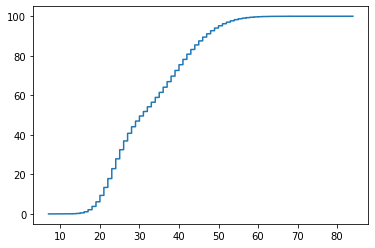

In [348]:
x = []
y = []

for steps, energy in response.data(fields=['num_steps', 'energy'], sorted_by='num_steps'):
    x.append(steps)
    y.append(energy)

# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))
    
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

## Tabu

In [306]:
import time

In [349]:
#run solver
sampler = tabu.TabuSampler()

x = []
y = []

# Hyperparameters
timeout = 10 # default 20
problem_num = 25
# num restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
for seed in range(1, 1000):
    start = time.time()
    response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout, num_reads=1, num_restarts=1)
    end = time.time()
    x.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    y.append(energy)
    

In [350]:
# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))

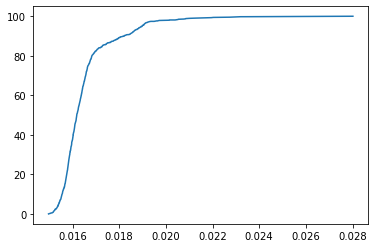

In [351]:
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

# new

In [10]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Solve QUBO a lot of times
problem_num = 1
seed = 0
response = sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=1)

In [11]:
Q = newQs[problem_num]
solution = list(response.samples())[-1]
sample = solution
offset = 0
for v0, v1 in Q:
    offset += sample[v0] * sample[v1] * Q[(v0, v1)]
offset

-812094107

In [12]:
y = list(solution.values())

In [13]:
y = np.asarray(y)

In [14]:
i,j = zip(*Q.keys())
q = np.zeros((max(i)+1,max(j)+1), np.int32)
np.add.at(q, tuple((i,j)), tuple(Q.values()))

In [15]:
y.T.dot(q).dot(y)

-812094107

In [16]:
response.first.energy

-812094107.0

In [17]:
obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]

In [18]:
obj

3035

In [19]:
con

924

In [20]:
obj_qubos[problem_num]

array([[360,   0,   0, ...,   0,   0,   0],
       [  0,  83,   0, ...,   0,   0,   0],
       [  0,   0,  59, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [21]:
Q

{(0, 0): 52380556,
 (1, 1): 162054909,
 (2, 2): 232897573,
 (3, 3): 147558078,
 (4, 4): 178893737,
 (5, 5): 177271553,
 (6, 6): 39592974,
 (7, 7): 191539108,
 (8, 8): 150060175,
 (9, 9): 206592427,
 (10, 10): 121944650,
 (11, 11): 166855736,
 (12, 12): 78547136,
 (13, 13): 132587734,
 (14, 14): 110586544,
 (15, 15): 74112565,
 (16, 16): 135993350,
 (17, 17): 68527644,
 (18, 18): 47015473,
 (19, 19): 130097291,
 (20, 20): 146851624,
 (21, 21): 150555164,
 (22, 22): 136519276,
 (23, 23): 155116981,
 (24, 24): 151404420,
 (25, 25): 192588042,
 (26, 26): 104107082,
 (27, 27): 83844390,
 (28, 28): 130334530,
 (29, 29): 142154149,
 (30, 30): -259407872,
 (31, 31): -363536384,
 (32, 32): -240226304,
 (33, 33): -134727680,
 (34, 34): -71017472,
 (35, 35): -36422144,
 (36, 36): -18439424,
 (37, 37): -9276800,
 (38, 38): -4652672,
 (39, 39): -2329904,
 (40, 40): -1165844,
 (41, 41): 252100608,
 (42, 42): -107782144,
 (43, 43): -112349184,
 (44, 44): -70789120,
 (45, 45): -39048192,
 (46, 46): -2

In [62]:
obj_qubo

array([[360,   0,   0, ...,   0,   0,   0],
       [  0,  83,   0, ...,   0,   0,   0],
       [  0,   0,  59, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [64]:
qubo_size = qubo_sizes[1]
objective = objectives[1]
constraint = constraints[1]

obj_qubo, obj_constant = convert_1d_qubo_to_2d(objective, qubo_size)
con_qubo, con_constant = convert_1d_qubo_to_2d(constraint, qubo_size)

######## QUBO you need to solve ########
penalty = util.verma_penalty(obj_qubo)
print('penalty', penalty)
#QUBO matrix 
Q = -1*obj_qubo + penalty * con_qubo
#constant term
c = -1*obj_constant + penalty * con_constant

#example of solving the problem with QBsolve

#change QUBO matrix to the QBSolve format
newQ = util.convert_QUBO_to_dwave_format(Q)

sampler = neal.SimulatedAnnealingSampler()
response = sampler.sample_qubo(newQ, solver=sampler)

print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])) )

solution = list(response.samples())[-1]

y = np.array([int(solution[i]) for i in range(len(solution))])
print(y)

obj = y.transpose().dot(obj_qubo).dot(y) #+ obj_constant
con = y.transpose().dot(con_qubo).dot(y) #+ con_constant

print('The objective function value of x is ', obj )
print('The constraint function value of x is ',con )
print('Final value is ',-obj + con*penalty)

penalty 892
samples=[{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 1, 30: 1, 31: 0, 32: 1, 33: 0, 34: 0, 35: 1, 36: 0, 37: 1, 38: 0, 39: 0, 40: 1, 41: 0, 42: 1, 43: 1, 44: 1, 45: 0, 46: 0, 47: 1, 48: 0, 49: 0, 50: 0, 51: 0, 52: 1, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 0, 64: 1, 65: 0, 66: 1, 67: 1, 68: 1, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 1, 76: 1, 77: 0, 78: 1, 79: 0, 80: 1, 81: 1, 82: 0, 83: 0, 84: 1}]
energies=[-812637683.0]
[1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0
 0 1 1 0 1 0 1 1 0 0 1]
The objective function value of x is  2491
The constraint function value of x is  -911026
Final value is  -812637683


In [54]:
con_constant*892

812915280

In [23]:
######## QUBO you need to solve ########
penalty = util.verma_penalty(obj_qubo)
print('penalty', penalty)
#QUBO matrix 
Q = -1*obj_qubo + penalty * con_qubo
#constant term
c = -1*obj_constant+ penalty * con_constant

#example of solving the problem with QBsolve

#change QUBO matrix to the QBSolve format
newQ = util.convert_QUBO_to_dwave_format(Q)



#run solver, need to pip install dwave_qbsolv

sampler = neal.SimulatedAnnealingSampler()
#to use the tabu sampler, need to pip install dwave_tabu
#sampler = TabuSampler()
response = QBSolv().sample_qubo(newQ, solver=sampler, find_max = False)

#response = TabuSampler().sample_qubo(newQ)

print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])) )

solution = list(response.samples())[-1]

y = np.array([int(solution[i]) for i in range(len(solution))])
print(y)

obj = y.transpose().dot(obj_qubo).dot(y) + obj_constant
con = y.transpose().dot(con_qubo).dot(y) + con_constant

print('The objective function value of x is ',obj )
print('The constraint function value of x is ',con )

penalty 892


NameError: name 'QBSolv' is not defined

In [647]:
y.dot(Q).dot(y)

-812259082

In [623]:
(con_qubo.dot(y) - con_constant).T.dot(con_qubo.dot(y) - con_constant)

81537869087968

In [624]:
con_constant

911340

In [625]:
y.transpose().dot(con_qubo).dot(y) - con_constant

-1822399

In [598]:
con*penalty

436188

In [599]:
con_constant

911340

In [575]:
obj_qubo.shape

(85, 85)

In [576]:
con_qubo.shape

(85, 85)

In [528]:
y

[0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1]

In [481]:
Q

{(0, 0): 52380556,
 (1, 1): 162054909,
 (2, 2): 232897573,
 (3, 3): 147558078,
 (4, 4): 178893737,
 (5, 5): 177271553,
 (6, 6): 39592974,
 (7, 7): 191539108,
 (8, 8): 150060175,
 (9, 9): 206592427,
 (10, 10): 121944650,
 (11, 11): 166855736,
 (12, 12): 78547136,
 (13, 13): 132587734,
 (14, 14): 110586544,
 (15, 15): 74112565,
 (16, 16): 135993350,
 (17, 17): 68527644,
 (18, 18): 47015473,
 (19, 19): 130097291,
 (20, 20): 146851624,
 (21, 21): 150555164,
 (22, 22): 136519276,
 (23, 23): 155116981,
 (24, 24): 151404420,
 (25, 25): 192588042,
 (26, 26): 104107082,
 (27, 27): 83844390,
 (28, 28): 130334530,
 (29, 29): 142154149,
 (30, 30): -259407872,
 (31, 31): -363536384,
 (32, 32): -240226304,
 (33, 33): -134727680,
 (34, 34): -71017472,
 (35, 35): -36422144,
 (36, 36): -18439424,
 (37, 37): -9276800,
 (38, 38): -4652672,
 (39, 39): -2329904,
 (40, 40): -1165844,
 (41, 41): 252100608,
 (42, 42): -107782144,
 (43, 43): -112349184,
 (44, 44): -70789120,
 (45, 45): -39048192,
 (46, 46): -2

In [470]:
.transpose().dot(Q).dot(y)

ValueError: shapes (155,) and (85,85) not aligned: 155 (dim 0) != 85 (dim 0)

In [486]:
Qs[1][1]

array([         0,  162054909,   35430240,   27031168,   17868544,
         15142592,   13041040,   21118992,   17208464,   29161264,
         12769872,   22556896,   15328128,   13069584,   22539056,
         15438736,   23206272,    5897904,   15196112,   27873216,
         16116656,   21408000,   23231248,   23516688,   26784976,
         27858944,    7464256,   15420896,   17040768,   12912592,
                0,          0,          0,          0,          0,
                0,          0,          0,          0,          0,
                0, -120569856,  -60284928,  -30142464,  -15071232,
         -7535616,   -3767808,   -1883904,    -941952,    -470976,
          -235488,    -117744, -135184384,  -67592192,  -33796096,
        -16898048,   -8449024,   -4224512,   -2112256,   -1056128,
          -528064,    -264032,    -132016,  -73072640,  -36536320,
        -18268160,   -9134080,   -4567040,   -2283520,   -1141760,
          -570880,    -285440,    -142720,     -71360, -157106

In [356]:
solution = list(response.samples())[-1]

y = np.array([int(solution[i]) for i in range(len(solution))])
#print(y)

obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]

In [416]:
dimod.BinaryQuadraticModel(newQs[problem_num])

TypeError: expected input vartype to be one of: Vartype.SPIN, 'SPIN', {-1, 1}, Vartype.BINARY, 'BINARY', or {0, 1}; received {(0, 0): 541296460, (1, 1): 902614717, (2, 2): 905808101, (3, 3): 729320478, (4, 4): 1069798361, (5, 5): 1148324161, (6, 6): 546566526, (7, 7): 1003316196, (8, 8): 954797599, (9, 9): 1304894187, (10, 10): 598204858, (11, 11): 704446296, (12, 12): 393883408, (13, 13): 441658598, (14, 14): 813200672, (15, 15): 694980245, (16, 16): 998318294, (17, 17): 527083436, (18, 18): 733273889, (19, 19): 765782875, (20, 20): 592462712, (21, 21): 697233420, (22, 22): 1169862028, (23, 23): 919025781, (24, 24): 1077025684, (25, 25): 819863850, (26, 26): 503237834, (27, 27): 543745318, (28, 28): 532876290, (29, 29): 923792341, (30, 30): 511986078, (31, 31): 853737632, (32, 32): 563741237, (33, 33): 766958475, (34, 34): 393221174, (35, 35): 540163073, (36, 36): 700225326, (37, 37): 1043671142, (38, 38): 1241866274, (39, 39): 533728164, (40, 40): 898766627, (41, 41): 826068523, (42, 42): 358069042, (43, 43): 1348303449, (44, 44): 1083253687, (45, 45): 1103988250, (46, 46): 865712741, (47, 47): 901294251, (48, 48): 775738228, (49, 49): 534386184, (50, 50): 730611238, (51, 51): 619752612, (52, 52): 545738015, (53, 53): 923500788, (54, 54): 666026031, (55, 55): 1053701597, (56, 56): 728385776, (57, 57): 407379036, (58, 58): 545465833, (59, 59): 938486442, (60, 60): 618085459, (61, 61): 801686632, (62, 62): 583653932, (63, 63): 838785038, (64, 64): 1068665938, (65, 65): 865901694, (66, 66): 758739455, (67, 67): 944876811, (68, 68): 971458099, (69, 69): 1119256189, (70, 70): 750013993, (71, 71): 1322310587, (72, 72): 517100334, (73, 73): 640085732, (74, 74): 784788646, (75, 75): 759657382, (76, 76): 1110531917, (77, 77): 820752363, (78, 78): 558442762, (79, 79): 636617650, (80, 80): 392689520, (81, 81): 742230452, (82, 82): 674273473, (83, 83): 793600775, (84, 84): 507693972, (85, 85): 683315464, (86, 86): 757248166, (87, 87): 957941910, (88, 88): 1058241058, (89, 89): 602970540, (90, 90): -3273654272, (91, 91): -5378146304, (92, 92): -3624402944, (93, 93): -2046033920, (94, 94): -1081475072, (95, 95): -555352064, (96, 96): -281329664, (97, 97): -141578240, (98, 98): -71017472, (99, 99): -35565824, (100, 100): -17797184, (101, 101): -8902160, (102, 102): -4451972, (103, 103): 3302883328, (104, 104): -2089877504, (105, 105): -1980268544, (106, 106): -1223966720, (107, 107): -670441472, (108, 108): -349835264, (109, 109): -178571264, (110, 110): -90199040, (111, 111): -45327872, (112, 112): -22721024, (113, 113): -11374784, (114, 114): -5690960, (115, 115): -2846372, (116, 116): 6956515328, (117, 117): -263061504, (118, 118): -1066860544, (119, 119): -767262720, (120, 120): -442089472, (121, 121): -235659264, (122, 122): -121483264, (123, 123): -61655040, (124, 124): -31055872, (125, 125): -15585024, (126, 126): -7806784, (127, 127): -3906960, (128, 128): -1954372, (129, 129): -8754102272, (130, 130): -8118370304, (131, 131): -4994514944, (132, 132): -2731089920, (133, 133): -1424003072, (134, 134): -726616064, (135, 135): -366961664, (136, 136): -184394240, (137, 137): -92425472, (138, 138): -46269824, (139, 139): -23149184, (140, 140): -11578160, (141, 141): -5789972, (142, 142): -350748672, (143, 143): -3916693504, (144, 144): -2893676544, (145, 145): -1680670720, (146, 146): -898793472, (147, 147): -464011264, (148, 148): -235659264, (149, 149): -118743040, (150, 150): -59599872, (151, 151): -29857024, (152, 152): -14942784, (153, 153): -7474960, (154, 154): -3738372, (0, 1): 17258416, (0, 2): 15659952, (0, 3): 16908752, (0, 4): 9564024, (0, 5): 7963776, (0, 6): 12648560, (0, 7): 11975992, (0, 8): 11285584, (0, 9): 16136280, (0, 10): 8952112, (0, 11): 3724992, (0, 12): 5814056, (0, 13): 1659120, (0, 14): 10175936, (0, 15): 6873752, (0, 16): 7080696, (0, 17): 3489504, (0, 18): 12391664, (0, 19): 14270216, (0, 20): 4117472, (0, 21): 13999048, (0, 22): 18170040, (0, 23): 9738856, (0, 24): 12612880, (0, 25): 17957744, (0, 26): 2829424, (0, 27): 4977360, (0, 28): 5690960, (0, 29): 9869088, (0, 30): 16259376, (0, 31): 14084680, (0, 32): 11813648, (0, 33): 7139568, (0, 34): 13289016, (0, 35): 10038568, (0, 36): 6707840, (0, 37): 9241120, (0, 38): 14889264, (0, 39): 4006864, (0, 40): 7999456, (0, 41): 6021000, (0, 42): 3362840, (0, 43): 9851248, (0, 44): 19074528, (0, 45): 8650616, (0, 46): 10320440, (0, 47): 10736112, (0, 48): 17945256, (0, 49): 14751896, (0, 50): 11731584, (0, 51): 8127904, (0, 52): 3814192, (0, 53): 13636896, (0, 54): 16666128, (0, 55): 11811864, (0, 56): 9027040, (0, 57): 1562784, (0, 58): 5607112, (0, 59): 16455616, (0, 60): 5867576, (0, 61): 10190208, (0, 62): 6363528, (0, 63): 3369976, (0, 64): 6277896, (0, 65): 9007416, (0, 66): 13542344, (0, 67): 8195696, (0, 68): 9869088, (0, 69): 14459320, (0, 70): 8927136, (0, 71): 21215328, (0, 72): 15931120, (0, 73): 12529032, (0, 74): 8750520, (0, 75): 7753264, (0, 76): 8689864, (0, 77): 14803632, (0, 78): 7947720, (0, 79): 4240568, (0, 80): 3428848, (0, 81): 6714976, (0, 82): 10479216, (0, 83): 15180056, (0, 84): 11724448, (0, 85): 14502136, (0, 86): 6483056, (0, 87): 8962816, (0, 88): 7537400, (0, 89): 11556752, (0, 90): -51150848, (0, 91): -25575424, (0, 92): -12787712, (0, 93): -6393856, (0, 94): -3196928, (0, 95): -1598464, (0, 96): -799232, (0, 97): -399616, (0, 98): -199808, (0, 99): -99904, (0, 100): -49952, (0, 101): -24976, (0, 102): -12488, (0, 103): -58458112, (0, 104): -29229056, (0, 105): -14614528, (0, 106): -7307264, (0, 107): -3653632, (0, 108): -1826816, (0, 109): -913408, (0, 110): -456704, (0, 111): -228352, (0, 112): -114176, (0, 113): -57088, (0, 114): -28544, (0, 115): -14272, (0, 116): -21921792, (0, 117): -10960896, (0, 118): -5480448, (0, 119): -2740224, (0, 120): -1370112, (0, 121): -685056, (0, 122): -342528, (0, 123): -171264, (0, 124): -85632, (0, 125): -42816, (0, 126): -21408, (0, 127): -10704, (0, 128): -5352, (0, 129): -153452544, (0, 130): -76726272, (0, 131): -38363136, (0, 132): -19181568, (0, 133): -9590784, (0, 134): -4795392, (0, 135): -2397696, (0, 136): -1198848, (0, 137): -599424, (0, 138): -299712, (0, 139): -149856, (0, 140): -74928, (0, 141): -37464, (0, 142): -686882816, (0, 143): -343441408, (0, 144): -171720704, (0, 145): -85860352, (0, 146): -42930176, (0, 147): -21465088, (0, 148): -10732544, (0, 149): -5366272, (0, 150): -2683136, (0, 151): -1341568, (0, 152): -670784, (0, 153): -335392, (0, 154): -167696, (1, 2): 35430240, (1, 3): 27031168, (1, 4): 17868544, (1, 5): 15142592, (1, 6): 13041040, (1, 7): 21118992, (1, 8): 17208464, (1, 9): 29161264, (1, 10): 12769872, (1, 11): 22556896, (1, 12): 15328128, (1, 13): 13069584, (1, 14): 22539056, (1, 15): 15438736, (1, 16): 23206272, (1, 17): 5897904, (1, 18): 15196112, (1, 19): 27873216, (1, 20): 16116656, (1, 21): 21408000, (1, 22): 23231248, (1, 23): 23516688, (1, 24): 26784976, (1, 25): 27858944, (1, 26): 7464256, (1, 27): 15420896, (1, 28): 17040768, (1, 29): 12912592, (1, 30): 22628256, (1, 31): 29207648, (1, 32): 23209840, (1, 33): 19895168, (1, 34): 15128320, (1, 35): 12823392, (1, 36): 10536304, (1, 37): 18510784, (1, 38): 26834928, (1, 39): 18985328, (1, 40): 20269808, (1, 41): 13012496, (1, 42): 6590096, (1, 43): 33407184, (1, 44): 35212592, (1, 45): 22514080, (1, 46): 21101152, (1, 47): 22699616, (1, 48): 20883504, (1, 49): 20330464, (1, 50): 15406624, (1, 51): 22132304, (1, 52): 15453008, (1, 53): 23762880, (1, 54): 19445600, (1, 55): 25917952, (1, 56): 16862368, (1, 57): 14225616, (1, 58): 13651168, (1, 59): 25254304, (1, 60): 17429680, (1, 61): 15092640, (1, 62): 12880480, (1, 63): 13519152, (1, 64): 21800480, (1, 65): 20573088, (1, 66): 25040224, (1, 67): 21593536, (1, 68): 26417472, (1, 69): 31120096, (1, 70): 19962960, (1, 71): 35291088, (1, 72): 24116112, (1, 73): 15909712, (1, 74): 26574464, (1, 75): 19060256, (1, 76): 24144656, (1, 77): 17336912, (1, 78): 14575280, (1, 79): 11856464, (1, 80): 11296288, (1, 81): 16031024, (1, 82): 22792384, (1, 83): 24911776, (1, 84): 17418976, (1, 85): 23266928, (1, 86): 12855504, (1, 87): 16762464, (1, 88): 18189664, (1, 89): 15899008, (1, 90): 0, (1, 91): 0, (1, 92): 0, (1, 93): 0, (1, 94): 0, (1, 95): 0, (1, 96): 0, (1, 97): 0, (1, 98): 0, (1, 99): 0, (1, 100): 0, (1, 101): 0, (1, 102): 0, (1, 103): -482279424, (1, 104): -241139712, (1, 105): -120569856, (1, 106): -60284928, (1, 107): -30142464, (1, 108): -15071232, (1, 109): -7535616, (1, 110): -3767808, (1, 111): -1883904, (1, 112): -941952, (1, 113): -470976, (1, 114): -235488, (1, 115): -117744, (1, 116): -540737536, (1, 117): -270368768, (1, 118): -135184384, (1, 119): -67592192, (1, 120): -33796096, (1, 121): -16898048, (1, 122): -8449024, (1, 123): -4224512, (1, 124): -2112256, (1, 125): -1056128, (1, 126): -528064, (1, 127): -264032, (1, 128): -132016, (1, 129): -292290560, (1, 130): -146145280, (1, 131): -73072640, (1, 132): -36536320, (1, 133): -18268160, (1, 134): -9134080, (1, 135): -4567040, (1, 136): -2283520, (1, 137): -1141760, (1, 138): -570880, (1, 139): -285440, (1, 140): -142720, (1, 141): -71360, (1, 142): -628424704, (1, 143): -314212352, (1, 144): -157106176, (1, 145): -78553088, (1, 146): -39276544, (1, 147): -19638272, (1, 148): -9819136, (1, 149): -4909568, (1, 150): -2454784, (1, 151): -1227392, (1, 152): -613696, (1, 153): -306848, (1, 154): -153424, (2, 3): 30898880, (2, 4): 17340480, (2, 5): 15684928, (2, 6): 9865520, (2, 7): 27941008, (2, 8): 17643760, (2, 9): 29047088, (2, 10): 16651856, (2, 11): 26695776, (2, 12): 18300272, (2, 13): 19113776, (2, 14): 19217248, (2, 15): 12398800, (2, 16): 22535488, (2, 17): 4884592, (2, 18): 10061760, (2, 19): 29692896, (2, 20): 23759312, (2, 21): 26371088, (2, 22): 19074528, (2, 23): 24133952, (2, 24): 26635120, (2, 25): 31808720, (2, 26): 10539872, (2, 27): 17454656, (2, 28): 23866352, (2, 29): 14200640, (2, 30): 22942240, (2, 31): 29150560, (2, 32): 27170320, (2, 33): 23270496, (2, 34): 15449440, (2, 35): 13494176, (2, 36): 15624272, (2, 37): 17162080, (2, 38): 26114192, (2, 39): 19263632, (2, 40): 28957888, (2, 41): 12894752, (2, 42): 7824624, (2, 43): 38655712, (2, 44): 35537280, (2, 45): 25147264, (2, 46): 18382336, (2, 47): 25539744, (2, 48): 24108976, (2, 49): 21846864, (2, 50): 15360240, (2, 51): 23634432, (2, 52): 18692752, (2, 53): 30410064, (2, 54): 18871152, (2, 55): 23737904, (2, 56): 21065472, (2, 57): 17358320, (2, 58): 15010576, (2, 59): 31719520, (2, 60): 16969408, (2, 61): 11902848, (2, 62): 8227808, (2, 63): 17418976, (2, 64): 22432016, (2, 65): 20626608, (2, 66): 27876784, (2, 67): 29257600, (2, 68): 26146304, (2, 69): 31319904, (2, 70): 27498576, (2, 71): 34306320, (2, 72): 24958160, (2, 73): 19545504, (2, 74): 28147952, (2, 75): 18664208, (2, 76): 30788272, (2, 77): 11446144, (2, 78): 17618784, (2, 79): 11174976, (2, 80): 16048864, (2, 81): 12423776, (2, 82): 21686304, (2, 83): 31576800, (2, 84): 21229600, (2, 85): 25753824, (2, 86): 11025120, (2, 87): 15517232, (2, 88): 23777152, (2, 89): 17932768, (2, 90): -219217920, (2, 91): -109608960, (2, 92): -54804480, (2, 93): -27402240, (2, 94): -13701120, (2, 95): -6850560, (2, 96): -3425280, (2, 97): -1712640, (2, 98): -856320, (2, 99): -428160, (2, 100): -214080, (2, 101): -107040, (2, 102): -53520, (2, 103): -716111872, (2, 104): -358055936, (2, 105): -179027968, (2, 106): -89513984, (2, 107): -44756992, (2, 108): -22378496, (2, 109): -11189248, (2, 110): -5594624, (2, 111): -2797312, (2, 112): -1398656, (2, 113): -699328, (2, 114): -349664, (2, 115): -174832, (2, 116): -643039232, (2, 117): -321519616, (2, 118): -160759808, (2, 119): -80379904, (2, 120): -40189952, (2, 121): -20094976, (2, 122): -10047488, (2, 123): -5023744, (2, 124): -2511872, (2, 125): -1255936, (2, 126): -627968, (2, 127): -313984, (2, 128): -156992, (2, 129): 0, (2, 130): 0, (2, 131): 0, (2, 132): 0, (2, 133): 0, (2, 134): 0, (2, 135): 0, (2, 136): 0, (2, 137): 0, (2, 138): 0, (2, 139): 0, (2, 140): 0, (2, 141): 0, (2, 142): -584581120, (2, 143): -292290560, (2, 144): -146145280, (2, 145): -73072640, (2, 146): -36536320, (2, 147): -18268160, (2, 148): -9134080, (2, 149): -4567040, (2, 150): -2283520, (2, 151): -1141760, (2, 152): -570880, (2, 153): -285440, (2, 154): -142720, (3, 4): 14011536, (3, 5): 11824352, (3, 6): 11560320, (3, 7): 20255536, (3, 8): 14974896, (3, 9): 23149184, (3, 10): 13479904, (3, 11): 15285312, (3, 12): 12066976, (3, 13): 10643344, (3, 14): 14867856, (3, 15): 9326752, (3, 16): 14057920, (3, 17): 4149584, (3, 18): 11107184, (3, 19): 22389200, (3, 20): 13875952, (3, 21): 21211760, (3, 22): 19113776, (3, 23): 17172784, (3, 24): 19456304, (3, 25): 26649392, (3, 26): 6882672, (3, 27): 10789632, (3, 28): 14835744, (3, 29): 12373824, (3, 30): 20901344, (3, 31): 22260752, (3, 32): 20576656, (3, 33): 16170176, (3, 34): 15164000, (3, 35): 12109792, (3, 36): 12052704, (3, 37): 12666400, (3, 38): 21400864, (3, 39): 12109792, (3, 40): 19074528, (3, 41): 9851248, (3, 42): 5798000, (3, 43): 24415824, (3, 44): 27530688, (3, 45): 17497472, (3, 46): 14553872, (3, 47): 19334992, (3, 48): 22057376, (3, 49): 19270768, (3, 50): 14189936, (3, 51): 16691104, (3, 52): 10575552, (3, 53): 22917264, (3, 54): 18243184, (3, 55): 18500080, (3, 56): 15121184, (3, 57): 10282976, (3, 58): 9879792, (3, 59): 26042832, (3, 60): 11745856, (3, 61): 10814608, (3, 62): 7118160, (3, 63): 11271312, (3, 64): 14282704, (3, 65): 15599296, (3, 66): 21575696, (3, 67): 20034320, (3, 68): 17561696, (3, 69): 22849472, (3, 70): 19103072, (3, 71): 28658176, (3, 72): 21811184, (3, 73): 17033632, (3, 74): 18814064, (3, 75): 13258688, (3, 76): 19852352, (3, 77): 13087424, (3, 78): 13237280, (3, 79): 7396464, (3, 80): 9533696, (3, 81): 9198304, (3, 82): 16755328, (3, 83): 24041184, (3, 84): 16815984, (3, 85): 21094016, (3, 86): 8563200, (3, 87): 12520112, (3, 88): 15424464, (3, 89): 15513664, (3, 90): -160759808, (3, 91): -80379904, (3, 92): -40189952, (3, 93): -20094976, (3, 94): -10047488, (3, 95): -5023744, (3, 96): -2511872, (3, 97): -1255936, (3, 98): -627968, (3, 99): -313984, (3, 100): -156992, (3, 101): -78496, (3, 102): -39248, (3, 103): -365363200, (3, 104): -182681600, (3, 105): -91340800, (3, 106): -45670400, (3, 107): -22835200, (3, 108): -11417600, (3, 109): -5708800, (3, 110): -2854400, (3, 111): -1427200, (3, 112): -713600, (3, 113): -356800, (3, 114): -178400, (3, 115): -89200, (3, 116): -365363200, (3, 117): -182681600, (3, 118): -91340800, (3, 119): -45670400, (3, 120): -22835200, (3, 121): -11417600, (3, 122): -5708800, (3, 123): -2854400, (3, 124): -1427200, (3, 125): -713600, (3, 126): -356800, (3, 127): -178400, (3, 128): -89200, (3, 129): -43843584, (3, 130): -21921792, (3, 131): -10960896, (3, 132): -5480448, (3, 133): -2740224, (3, 134): -1370112, (3, 135): -685056, (3, 136): -342528, (3, 137): -171264, (3, 138): -85632, (3, 139): -42816, (3, 140): -21408, (3, 141): -10704, (3, 142): -672268288, (3, 143): -336134144, (3, 144): -168067072, (3, 145): -84033536, (3, 146): -42016768, (3, 147): -21008384, (3, 148): -10504192, (3, 149): -5252096, (3, 150): -2626048, (3, 151): -1313024, (3, 152): -656512, (3, 153): -328256, (3, 154): -164128, (4, 5): 29532336, (4, 6): 11455064, (4, 7): 19358184, (4, 8): 24547840, (4, 9): 32179792, (4, 10): 13984776, (4, 11): 16680400, (4, 12): 5646360, (4, 13): 10236592, (4, 14): 20862096, (4, 15): 16259376, (4, 16): 20617688, (4, 17): 14425424, (4, 18): 15834784, (4, 19): 14093600, (4, 20): 9490880, (4, 21): 14632368, (4, 22): 28649256, (4, 23): 22387416, (4, 24): 22571168, (4, 25): 21152888, (4, 26): 13060664, (4, 27): 8563200, (4, 28): 7763968, (4, 29): 22919048, (4, 30): 11956368, (4, 31): 20020048, (4, 32): 13173056, (4, 33): 23045712, (4, 34): 7119944, (4, 35): 11051880, (4, 36): 19714984, (4, 37): 22539056, (4, 38): 34083320, (4, 39): 16642936, (4, 40): 20150280, (4, 41): 24271320, (4, 42): 9339240, (4, 43): 31773040, (4, 44): 19782776, (4, 45): 30354760, (4, 46): 22307136, (4, 47): 26412120, (4, 48): 15139024, (4, 49): 10807472, (4, 50): 18398392, (4, 51): 17649112, (4, 52): 6802392, (4, 53): 19946904, (4, 54): 11308776, (4, 55): 30299456, (4, 56): 13351456, (4, 57): 15230008, (4, 58): 8613152, (4, 59): 25801992, (4, 60): 17422544, (4, 61): 17674088, (4, 62): 15217520, (4, 63): 27414728, (4, 64): 27641296, (4, 65): 25652136, (4, 66): 17208464, (4, 67): 27264872, (4, 68): 19420624, (4, 69): 22976136, (4, 70): 17656248, (4, 71): 31503656, (4, 72): 12445184, (4, 73): 14828608, (4, 74): 19017440, (4, 75): 18360928, (4, 76): 24144656, (4, 77): 17720472, (4, 78): 12463024, (4, 79): 14976680, (4, 80): 4781120, (4, 81): 17802536, (4, 82): 18293136, (4, 83): 12760952, (4, 84): 6252920, (4, 85): 15024848, (4, 86): 18669560, (4, 87): 25991096, (4, 88): 21714848, (4, 89): 13918768, (4, 90): -584581120, (4, 91): -292290560, (4, 92): -146145280, (4, 93): -73072640, (4, 94): -36536320, (4, 95): -18268160, (4, 96): -9134080, (4, 97): -4567040, (4, 98): -2283520, (4, 99): -1141760, (4, 100): -570880, (4, 101): -285440, (4, 102): -142720, (4, 103): 0, (4, 104): 0, (4, 105): 0, (4, 106): 0, (4, 107): 0, (4, 108): 0, (4, 109): 0, (4, 110): 0, (4, 111): 0, (4, 112): 0, (4, 113): 0, (4, 114): 0, (4, 115): 0, (4, 116): -401899520, (4, 117): -200949760, (4, 118): -100474880, (4, 119): -50237440, (4, 120): -25118720, (4, 121): -12559360, (4, 122): -6279680, (4, 123): -3139840, (4, 124): -1569920, (4, 125): -784960, (4, 126): -392480, (4, 127): -196240, (4, 128): -98120, (4, 129): -599195648, (4, 130): -299597824, (4, 131): -149798912, (4, 132): -74899456, (4, 133): -37449728, (4, 134): -18724864, (4, 135): -9362432, (4, 136): -4681216, (4, 137): -2340608, (4, 138): -1170304, (4, 139): -585152, (4, 140): -292576, (4, 141): -146288, (4, 142): -226525184, (4, 143): -113262592, (4, 144): -56631296, (4, 145): -28315648, (4, 146): -14157824, (4, 147): -7078912, (4, 148): -3539456, (4, 149): -1769728, (4, 150): -884864, (4, 151): -442432, (4, 152): -221216, (4, 153): -110608, (4, 154): -55304, (5, 6): 10796768, (5, 7): 24913560, (5, 8): 25018816, (5, 9): 31589288, (5, 10): 14819688, (5, 11): 16364632, (5, 12): 6848776, (5, 13): 11296288, (5, 14): 17854272, (5, 15): 16842744, (5, 16): 24421176, (5, 17): 15774128, (5, 18): 16355712, (5, 19): 13099912, (5, 20): 14348712, (5, 21): 13820648, (5, 22): 27814344, (5, 23): 21761232, (5, 24): 24706616, (5, 25): 15137240, (5, 26): 14989168, (5, 27): 12034864, (5, 28): 11414032, (5, 29): 25732416, (5, 30): 5869360, (5, 31): 16089896, (5, 32): 9166192, (5, 33): 19333208, (5, 34): 4857832, (5, 35): 11838624, (5, 36): 20342952, (5, 37): 27225624, (5, 38): 30913152, (5, 39): 11662008, (5, 40): 23331152, (5, 41): 23634432, (5, 42): 9797728, (5, 43): 33519576, (5, 44): 19830944, (5, 45): 29605480, (5, 46): 20312624, (5, 47): 22082352, (5, 48): 15258552, (5, 49): 7833544, (5, 50): 17518880, (5, 51): 12587904, (5, 52): 12172232, (5, 53): 21204624, (5, 54): 11576376, (5, 55): 25316744, (5, 56): 17361888, (5, 57): 10136688, (5, 58): 12484432, (5, 59): 21156456, (5, 60): 14512840, (5, 61): 19673952, (5, 62): 13974072, (5, 63): 25418432, (5, 64): 28645688, (5, 65): 21688088, (5, 66): 14728704, (5, 67): 25170456, (5, 68): 21659544, (5, 69): 24108976, (5, 70): 18061216, (5, 71): 28408416, (5, 72): 5715936, (5, 73): 14198856, (5, 74): 16254024, (5, 75): 18091544, (5, 76): 28754512, (5, 77): 17893520, (5, 78): 12875128, (5, 79): 17071096, (5, 80): 8886104, (5, 81): 18294920, (5, 82): 13233712, (5, 83): 15158648, (5, 84): 8363392, (5, 85): 12350632, (5, 86): 20353656, (5, 87): 25834104, (5, 88): 28945400, (5, 89): 12969680, (5, 90): -686882816, (5, 91): -343441408, (5, 92): -171720704, (5, 93): -85860352, (5, 94): -42930176, (5, 95): -21465088, (5, 96): -10732544, (5, 97): -5366272, (5, 98): -2683136, (5, 99): -1341568, (5, 100): -670784, (5, 101): -335392, (5, 102): -167696, (5, 103): -219217920, (5, 104): -109608960, (5, 105): -54804480, (5, 106): -27402240, (5, 107): -13701120, (5, 108): -6850560, (5, 109): -3425280, (5, 110): -1712640, (5, 111): -856320, (5, 112): -428160, (5, 113): -214080, (5, 114): -107040, (5, 115): -53520, (5, 116): -138838016, (5, 117): -69419008, (5, 118): -34709504, (5, 119): -17354752, (5, 120): -8677376, (5, 121): -4338688, (5, 122): -2169344, (5, 123): -1084672, (5, 124): -542336, (5, 125): -271168, (5, 126): -135584, (5, 127): -67792, (5, 128): -33896, (5, 129): -664961024, (5, 130): -332480512, (5, 131): -166240256, (5, 132): -83120128, (5, 133): -41560064, (5, 134): -20780032, (5, 135): -10390016, (5, 136): -5195008, (5, 137): -2597504, (5, 138): -1298752, (5, 139): -649376, (5, 140): -324688, (5, 141): -162344, (5, 142): -124223488, (5, 143): -62111744, (5, 144): -31055872, (5, 145): -15527936, (5, 146): -7763968, (5, 147): -3881984, (5, 148): -1940992, (5, 149): -970496, (5, 150): -485248, (5, 151): -242624, (5, 152): -121312, (5, 153): -60656, (5, 154): -30328, (6, 7): 9804864, (6, 8): 11463984, (6, 9): 15890088, (6, 10): 7027176, (6, 11): 3846304, (6, 12): 3935504, (6, 13): 1013312, (6, 14): 10718272, (6, 15): 8383016, (6, 16): 9087696, (6, 17): 5355568, (6, 18): 12537952, (6, 19): 10802120, (6, 20): 2636752, (6, 21): 9696040, (6, 22): 17893520, (6, 23): 9826272, (6, 24): 12480864, (6, 25): 12728840, (6, 26): 3423496, (6, 27): 4656240, (6, 28): 3389600, (6, 29): 10427480, (6, 30): 11246336, (6, 31): 11797592, (6, 32): 7774672, (6, 33): 6761360, (6, 34): 9219712, (6, 35): 8284896, (6, 36): 6145880, (6, 37): 11203520, (6, 38): 15140808, (6, 39): 4440376, (6, 40): 6317144, (6, 41): 8020864, (6, 42): 3457392, (6, 43): 10425696, (6, 44): 15576104, (6, 45): 9819136, (6, 46): 11051880, (6, 47): 9717448, (6, 48): 13074936, (6, 49): 10263352, (6, 50): 10580904, (6, 51): 6827368, (6, 52): 3555512, (6, 53): 10216968, (6, 54): 12896536, (6, 55): 12657480, (6, 56): 7457120, (6, 57): 1643064, (6, 58): 5371624, (6, 59): 11990264, (6, 60): 6409912, (6, 61): 11073288, (6, 62): 8072600, (6, 63): 5259232, (6, 64): 8832584, (6, 65): 9487312, (6, 66): 10256216, (6, 67): 7034312, (6, 68): 10233024, (6, 69): 13426384, (6, 70): 6338552, (6, 71): 18844392, (6, 72): 10821744, (6, 73): 9271448, (6, 74): 7876360, (6, 75): 8259920, (6, 76): 8418696, (6, 77): 14602040, (6, 78): 6320712, (6, 79): 5962128, (6, 80): 2205024, (6, 81): 8725544, (6, 82): 9326752, (6, 83): 10158096, (6, 84): 7715800, (6, 85): 10570200, (6, 86): 8354472, (6, 87): 10677240, (6, 88): 8108280, (6, 89): 8969952, (6, 90): -80379904, (6, 91): -40189952, (6, 92): -20094976, (6, 93): -10047488, (6, 94): -5023744, (6, 95): -2511872, (6, 96): -1255936, (6, 97): -627968, (6, 98): -313984, (6, 99): -156992, (6, 100): -78496, (6, 101): -39248, (6, 102): -19624, (6, 103): 0, (6, 104): 0, (6, 105): 0, (6, 106): 0, (6, 107): 0, (6, 108): 0, (6, 109): 0, (6, 110): 0, (6, 111): 0, (6, 112): 0, (6, 113): 0, (6, 114): 0, (6, 115): 0, (6, 116): 0, (6, 117): 0, (6, 118): 0, (6, 119): 0, (6, 120): 0, (6, 121): 0, (6, 122): 0, (6, 123): 0, (6, 124): 0, (6, 125): 0, (6, 126): 0, (6, 127): 0, (6, 128): 0, (6, 129): -314212352, (6, 130): -157106176, (6, 131): -78553088, (6, 132): -39276544, (6, 133): -19638272, (6, 134): -9819136, (6, 135): -4909568, (6, 136): -2454784, (6, 137): -1227392, (6, 138): -613696, (6, 139): -306848, (6, 140): -153424, (6, 141): -76712, (6, 142): -474972160, (6, 143): -237486080, (6, 144): -118743040, (6, 145): -59371520, (6, 146): -29685760, (6, 147): -14842880, (6, 148): -7421440, (6, 149): -3710720, (6, 150): -1855360, (6, 151): -927680, (6, 152): -463840, (6, 153): -231920, (6, 154): -115960, (7, 8): 20294784, (7, 9): 26595872, (7, 10): 17327992, (7, 11): 17238792, (7, 12): 12851936, (7, 13): 14857152, (7, 14): 11649520, (7, 15): 11635248, (7, 16): 21829024, (7, 17): 9847680, (7, 18): 11902848, (7, 19): 19160160, (7, 20): 22876232, (7, 21): 20658720, (7, 22): 20715808, (7, 23): 18965704, (7, 24): 24146440, (7, 25): 18783736, (7, 26): 13729664, (7, 27): 15941824, (7, 28): 20744352, (7, 29): 21839728, (7, 30): 9697824, (7, 31): 16262944, (7, 32): 14375472, (7, 33): 15465496, (7, 34): 9708528, (7, 35): 13742152, (7, 36): 18930024, (7, 37): 23004680, (7, 38): 22264320, (7, 39): 6827368, (7, 40): 28643904, (7, 41): 14873208, (7, 42): 8632776, (7, 43): 32545512, (7, 44): 25507632, (7, 45): 23117072, (7, 46): 13842056, (7, 47): 17818592, (7, 48): 22200096, (7, 49): 13233712, (7, 50): 15278176, (7, 51): 10778928, (7, 52): 18319896, (7, 53): 27519984, (7, 54): 16592984, (7, 55): 15424464, (7, 56): 22656800, (7, 57): 6343904, (7, 58): 15750936, (7, 59): 23436408, (7, 60): 9719232, (7, 61): 15356672, (7, 62): 6490192, (7, 63): 16810632, (7, 64): 21397296, (7, 65): 14286272, (7, 66): 18316328, (7, 67): 24000152, (7, 68): 21591752, (7, 69): 25145480, (7, 70): 23209840, (7, 71): 25921520, (7, 72): 9719232, (7, 73): 17829296, (7, 74): 15859760, (7, 75): 14937432, (7, 76): 31682056, (7, 77): 13133808, (7, 78): 15406624, (7, 79): 13162352, (7, 80): 15915064, (7, 81): 11729800, (7, 82): 9961856, (7, 83): 27066848, (7, 84): 18153984, (7, 85): 16833824, (7, 86): 14355848, (7, 87): 17452872, (7, 88): 31312768, (7, 89): 15199680, (7, 90): -591888384, (7, 91): -295944192, (7, 92): -147972096, (7, 93): -73986048, (7, 94): -36993024, (7, 95): -18496512, (7, 96): -9248256, (7, 97): -4624128, (7, 98): -2312064, (7, 99): -1156032, (7, 100): -578016, (7, 101): -289008, (7, 102): -144504, (7, 103): -643039232, (7, 104): -321519616, (7, 105): -160759808, (7, 106): -80379904, (7, 107): -40189952, (7, 108): -20094976, (7, 109): -10047488, (7, 110): -5023744, (7, 111): -2511872, (7, 112): -1255936, (7, 113): -627968, (7, 114): -313984, (7, 115): -156992, (7, 116): -43843584, (7, 117): -21921792, (7, 118): -10960896, (7, 119): -5480448, (7, 120): -2740224, (7, 121): -1370112, (7, 122): -685056, (7, 123): -342528, (7, 124): -171264, (7, 125): -85632, (7, 126): -42816, (7, 127): -21408, (7, 128): -10704, (7, 129): -219217920, (7, 130): -109608960, (7, 131): -54804480, (7, 132): -27402240, (7, 133): -13701120, (7, 134): -6850560, (7, 135): -3425280, (7, 136): -1712640, (7, 137): -856320, (7, 138): -428160, (7, 139): -214080, (7, 140): -107040, (7, 141): -53520, (7, 142): -372670464, (7, 143): -186335232, (7, 144): -93167616, (7, 145): -46583808, (7, 146): -23291904, (7, 147): -11645952, (7, 148): -5822976, (7, 149): -2911488, (7, 150): -1455744, (7, 151): -727872, (7, 152): -363936, (7, 153): -181968, (7, 154): -90984, (8, 9): 27782232, (8, 10): 13690416, (8, 11): 13290800, (8, 12): 6431320, (8, 13): 8925352, (8, 14): 16464536, (8, 15): 13378216, (8, 16): 17763288, (8, 17): 11776184, (8, 18): 14559224, (8, 19): 14164960, (8, 20): 10534520, (8, 21): 15238928, (8, 22): 25339936, (8, 23): 18774816, (8, 24): 20492808, (8, 25): 19351048, (8, 26): 11348024, (8, 27): 8830800, (8, 28): 9262528, (8, 29): 20715808, (8, 30): 11617408, (8, 31): 17183488, (8, 32): 12236456, (8, 33): 17996992, (8, 34): 8511464, (8, 35): 11373000, (8, 36): 17333344, (8, 37): 20202016, (8, 38): 27937440, (8, 39): 11406896, (8, 40): 19142320, (8, 41): 19124480, (8, 42): 8081520, (8, 43): 26840280, (8, 44): 19773856, (8, 45): 24556760, (8, 46): 18025536, (8, 47): 21292040, (8, 48): 16949784, (8, 49): 11503232, (8, 50): 16596552, (8, 51): 13590512, (8, 52): 7935232, (8, 53): 19839864, (8, 54): 13199816, (8, 55): 23377536, (8, 56): 14154256, (8, 57): 10136688, (8, 58): 9148352, (8, 59): 23161672, (8, 60): 13167704, (8, 61): 15943608, (8, 62): 11703040, (8, 63): 20751488, (8, 64): 22021696, (8, 65): 19889816, (8, 66): 15995344, (8, 67): 22572952, (8, 68): 17297664, (8, 69): 21013736, (8, 70): 16594768, (8, 71): 27873216, (8, 72): 11704824, (8, 73): 14908888, (8, 74): 15378080, (8, 75): 15256768, (8, 76): 22280376, (8, 77): 16444912, (8, 78): 11918904, (8, 79): 12523680, (8, 80): 6315360, (8, 81): 14314816, (8, 82): 14404016, (8, 83): 15419112, (8, 84): 9196520, (8, 85): 14659128, (8, 86): 15627840, (8, 87): 21209976, (8, 88): 20947728, (8, 89): 13561968, (8, 90): -511508480, (8, 91): -255754240, (8, 92): -127877120, (8, 93): -63938560, (8, 94): -31969280, (8, 95): -15984640, (8, 96): -7992320, (8, 97): -3996160, (8, 98): -1998080, (8, 99): -999040, (8, 100): -499520, (8, 101): -249760, (8, 102): -124880, (8, 103): -109608960, (8, 104): -54804480, (8, 105): -27402240, (8, 106): -13701120, (8, 107): -6850560, (8, 108): -3425280, (8, 109): -1712640, (8, 110): -856320, (8, 111): -428160, (8, 112): -214080, (8, 113): -107040, (8, 114): -53520, (8, 115): -26760, (8, 116): -219217920, (8, 117): -109608960, (8, 118): -54804480, (8, 119): -27402240, (8, 120): -13701120, (8, 121): -6850560, (8, 122): -3425280, (8, 123): -1712640, (8, 124): -856320, (8, 125): -428160, (8, 126): -214080, (8, 127): -107040, (8, 128): -53520, (8, 129): -453050368, (8, 130): -226525184, (8, 131): -113262592, (8, 132): -56631296, (8, 133): -28315648, (8, 134): -14157824, (8, 135): -7078912, (8, 136): -3539456, (8, 137): -1769728, (8, 138): -884864, (8, 139): -442432, (8, 140): -221216, (8, 141): -110608, (8, 142): -336134144, (8, 143): -168067072, (8, 144): -84033536, (8, 145): -42016768, (8, 146): -21008384, (8, 147): -10504192, (8, 148): -5252096, (8, 149): -2626048, (8, 150): -1313024, (8, 151): -656512, (8, 152): -328256, (8, 153): -164128, (8, 154): -82064, (9, 10): 17137104, (9, 11): 22776328, (9, 12): 11801160, (9, 13): 13610136, (9, 14): 26454936, (9, 15): 20648016, (9, 16): 28378088, (9, 17): 14701944, (9, 18): 20871016, (9, 19): 24032264, (9, 20): 15731312, (9, 21): 21224248, (9, 22): 34295616, (9, 23): 28413768, (9, 24): 31302064, (9, 25): 27803640, (9, 26): 14022240, (9, 27): 14935648, (9, 28): 14607392, (9, 29): 25191864, (9, 30): 18582144, (9, 31): 28410200, (9, 32): 19732824, (9, 33): 25698520, (9, 34): 12554008, (9, 35): 15328128, (9, 36): 20187744, (9, 37): 28317432, (9, 38): 38657496, (9, 39): 19991504, (9, 40): 25470168, (9, 41): 24942104, (9, 42): 10488136, (9, 43): 40432576, (9, 44): 32659688, (9, 45): 33780040, (9, 46): 27223840, (9, 47): 29703600, (9, 48): 22221504, (9, 49): 17481416, (9, 50): 21825456, (9, 51): 22344600, (9, 52): 14011536, (9, 53): 26899152, (9, 54): 18994248, (9, 55): 34604248, (9, 56): 19556208, (9, 57): 16193368, (9, 58): 14446832, (9, 59): 30304808, (9, 60): 20851392, (9, 61): 22364224, (9, 62): 18202152, (9, 63): 26458504, (9, 64): 32006744, (9, 65): 28470856, (9, 66): 24483616, (9, 67): 29883784, (9, 68): 28524376, (9, 69): 33321552, (9, 70): 22640744, (9, 71): 41015944, (9, 72): 19318936, (9, 73): 19006736, (9, 74): 26240856, (9, 75): 23372184, (9, 76): 31096904, (9, 77): 23454248, (9, 78): 16637584, (9, 79): 18086192, (9, 80): 9931528, (9, 81): 22132304, (9, 82): 23630864, (9, 83): 22358872, (9, 84): 13900928, (9, 85): 22043104, (9, 86): 21568560, (9, 87): 28492264, (9, 88): 27478952, (9, 89): 18293136, (9, 90): -467664896, (9, 91): -233832448, (9, 92): -116916224, (9, 93): -58458112, (9, 94): -29229056, (9, 95): -14614528, (9, 96): -7307264, (9, 97): -3653632, (9, 98): -1826816, (9, 99): -913408, (9, 100): -456704, (9, 101): -228352, (9, 102): -114176, (9, 103): -270368768, (9, 104): -135184384, (9, 105): -67592192, (9, 106): -33796096, (9, 107): -16898048, (9, 108): -8449024, (9, 109): -4224512, (9, 110): -2112256, (9, 111): -1056128, (9, 112): -528064, (9, 113): -264032, (9, 114): -132016, (9, 115): -66008, (9, 116): -453050368, (9, 117): -226525184, (9, 118): -113262592, (9, 119): -56631296, (9, 120): -28315648, (9, 121): -14157824, (9, 122): -7078912, (9, 123): -3539456, (9, 124): -1769728, (9, 125): -884864, (9, 126): -442432, (9, 127): -221216, (9, 128): -110608, (9, 129): -664961024, (9, 130): -332480512, (9, 131): -166240256, (9, 132): -83120128, (9, 133): -41560064, (9, 134): -20780032, (9, 135): -10390016, (9, 136): -5195008, (9, 137): -2597504, (9, 138): -1298752, (9, 139): -649376, (9, 140): -324688, (9, 141): -162344, (9, 142): -482279424, (9, 143): -241139712, (9, 144): -120569856, (9, 145): -60284928, (9, 146): -30142464, (9, 147): -15071232, (9, 148): -7535616, (9, 149): -3767808, (9, 150): -1883904, (9, 151): -941952, (9, 152): -470976, (9, 153): -235488, (9, 154): -117744, (10, 11): 8657752, (10, 12): 5842600, (10, 13): 7899552, (10, 14): 7624816, (10, 15): 5887200, (10, 16): 9132296, (10, 17): 6165504, (10, 18): 7103888, (10, 19): 10757520, (10, 20): 10484568, (10, 21): 13922336, (10, 22): 14534248, (10, 23): 11232064, (10, 24): 12418424, (10, 25): 15952528, (10, 26): 8236728, (10, 27): 6265408, (10, 28): 9704960, (10, 29): 13920552, (10, 30): 9480176, (10, 31): 10796768, (10, 32): 10632640, (10, 33): 11951016, (10, 34): 7719368, (10, 35): 8641696, (10, 36): 13672576, (10, 37): 11226712, (10, 38): 16518056, (10, 39): 5441200, (10, 40): 16535896, (10, 41): 10679024, (10, 42): 5555376, (10, 43): 17588456, (10, 44): 13702904, (10, 45): 15269256, (10, 46): 9064504, (10, 47): 14280920, (10, 48): 15160432, (10, 49): 10022512, (10, 50): 11169624, (10, 51): 8507896, (10, 52): 6244000, (10, 53): 17131752, (10, 54): 10432832, (10, 55): 12131200, (10, 56): 11752992, (10, 57): 6249352, (10, 58): 6406344, (10, 59): 19359968, (10, 60): 6768496, (10, 61): 8383016, (10, 62): 3971184, (10, 63): 13105264, (10, 64): 11949232, (10, 65): 11355160, (10, 66): 12343496, (10, 67): 17390432, (10, 68): 9749560, (10, 69): 13094560, (10, 70): 14709080, (10, 71): 17695496, (10, 72): 9580080, (10, 73): 12926864, (10, 74): 9348160, (10, 75): 8500760, (10, 76): 16749976, (10, 77): 8215320, (10, 78): 9544400, (10, 79): 6467000, (10, 80): 6616856, (10, 81): 5887200, (10, 82): 7995888, (10, 83): 15312072, (10, 84): 9735288, (10, 85): 11927824, (10, 86): 8010160, (10, 87): 11710176, (10, 88): 15659952, (10, 89): 10828880, (10, 90): -431128576, (10, 91): -215564288, (10, 92): -107782144, (10, 93): -53891072, (10, 94): -26945536, (10, 95): -13472768, (10, 96): -6736384, (10, 97): -3368192, (10, 98): -1684096, (10, 99): -842048, (10, 100): -421024, (10, 101): -210512, (10, 102): -105256, (10, 103): -189988864, (10, 104): -94994432, (10, 105): -47497216, (10, 106): -23748608, (10, 107): -11874304, (10, 108): -5937152, (10, 109): -2968576, (10, 110): -1484288, (10, 111): -742144, (10, 112): -371072, (10, 113): -185536, (10, 114): -92768, (10, 115): -46384, (10, 116): -124223488, (10, 117): -62111744, (10, 118): -31055872, (10, 119): -15527936, (10, 120): -7763968, (10, 121): -3881984, (10, 122): -1940992, (10, 123): -970496, (10, 124): -485248, (10, 125): -242624, (10, 126): -121312, (10, 127): -60656, (10, 128): -30328, (10, 129): -73072640, (10, 130): -36536320, (10, 131): -18268160, (10, 132): -9134080, (10, 133): -4567040, (10, 134): -2283520, (10, 135): -1141760, (10, 136): -570880, (10, 137): -285440, (10, 138): -142720, (10, 139): -71360, (10, 140): -35680, (10, 141): -17840, (10, 142): -321519616, (10, 143): -160759808, (10, 144): -80379904, (10, 145): -40189952, (10, 146): -20094976, (10, 147): -10047488, (10, 148): -5023744, (10, 149): -2511872, (10, 150): -1255936, (10, 151): -627968, (10, 152): -313984, (10, 153): -156992, (10, 154): -78496, (11, 12): 12464808, (11, 13): 15417328, (11, 14): 18021968, (11, 15): 13510232, (11, 16): 23571992, (11, 17): 6579392, (11, 18): 7589136, (11, 19): 18926456, (11, 20): 17124616, (11, 21): 12725272, (11, 22): 13289016, (11, 23): 20726512, (11, 24): 22059160, (11, 25): 15915064, (11, 26): 8998496, (11, 27): 14575280, (11, 28): 15795536, (11, 29): 10361472, (11, 30): 9530128, (11, 31): 21088664, (11, 32): 15563616, (11, 33): 19015656, (11, 34): 4251272, (11, 35): 6704272, (11, 36): 9892280, (11, 37): 17103208, (11, 38): 21300960, (11, 39): 19037064, (11, 40): 19962960, (11, 41): 13601216, (11, 42): 6158368, (11, 43): 34297400, (11, 44): 23541664, (11, 45): 22754920, (11, 46): 16994384, (11, 47): 19095936, (11, 48): 8536440, (11, 49): 9143000, (11, 50): 9094832, (11, 51): 18660640, (11, 52): 15879384, (11, 53): 17490336, (11, 54): 7102104, (11, 55): 21873624, (11, 56): 13586944, (11, 57): 16209424, (11, 58): 12141904, (11, 59): 16254024, (11, 60): 16211208, (11, 61): 10579120, (11, 62): 10473864, (11, 63): 17440384, (11, 64): 23953768, (11, 65): 18234264, (11, 66): 17083584, (11, 67): 21509688, (11, 68): 23611240, (11, 69): 24733376, (11, 70): 17361888, (11, 71): 23477440, (11, 72): 11428304, (11, 73): 8318792, (11, 74): 23671896, (11, 75): 16981896, (11, 76): 24569248, (11, 77): 7817488, (11, 78): 11026904, (11, 79): 12514760, (11, 80): 11151784, (11, 81): 14602040, (11, 82): 17030064, (11, 83): 15758072, (11, 84): 9337456, (11, 85): 13663656, (11, 86): 12086600, (11, 87): 15158648, (11, 88): 19358184, (11, 89): 8845072, (11, 90): -131530752, (11, 91): -65765376, (11, 92): -32882688, (11, 93): -16441344, (11, 94): -8220672, (11, 95): -4110336, (11, 96): -2055168, (11, 97): -1027584, (11, 98): -513792, (11, 99): -256896, (11, 100): -128448, (11, 101): -64224, (11, 102): -32112, (11, 103): -526123008, (11, 104): -263061504, (11, 105): -131530752, (11, 106): -65765376, (11, 107): -32882688, (11, 108): -16441344, (11, 109): -8220672, (11, 110): -4110336, (11, 111): -2055168, (11, 112): -1027584, (11, 113): -513792, (11, 114): -256896, (11, 115): -128448, (11, 116): -591888384, (11, 117): -295944192, (11, 118): -147972096, (11, 119): -73986048, (11, 120): -36993024, (11, 121): -18496512, (11, 122): -9248256, (11, 123): -4624128, (11, 124): -2312064, (11, 125): -1156032, (11, 126): -578016, (11, 127): -289008, (11, 128): -144504, (11, 129): -299597824, (11, 130): -149798912, (11, 131): -74899456, (11, 132): -37449728, (11, 133): -18724864, (11, 134): -9362432, (11, 135): -4681216, (11, 136): -2340608, (11, 137): -1170304, (11, 138): -585152, (11, 139): -292576, (11, 140): -146288, (11, 141): -73144, (11, 142): -21921792, (11, 143): -10960896, (11, 144): -5480448, (11, 145): -2740224, (11, 146): -1370112, (11, 147): -685056, (11, 148): -342528, (11, 149): -171264, (11, 150): -85632, (11, 151): -42816, (11, 152): -21408, (11, 153): -10704, (11, 154): -5352, (12, 13): 8340200, (12, 14): 8359824, (12, 15): 6763144, (12, 16): 13246200, (12, 17): 2031976, (12, 18): 5244960, (12, 19): 13497744, (12, 20): 12063408, (12, 21): 9721016, (12, 22): 7280504, (12, 23): 10611232, (12, 24): 13465632, (12, 25): 9621112, (12, 26): 4158504, (12, 27): 10140256, (12, 28): 11840408, (12, 29): 5382328, (12, 30): 7121728, (12, 31): 11988480, (12, 32): 9770968, (12, 33): 7451768, (12, 34): 5307400, (12, 35): 5580352, (12, 36): 4197752, (12, 37): 9860168, (12, 38): 8912864, (12, 39): 7212712, (12, 40): 12029512, (12, 41): 4138880, (12, 42): 2938248, (12, 43): 17766856, (12, 44): 17024712, (12, 45): 9421304, (12, 46): 7805000, (12, 47): 7790728, (12, 48): 8775496, (12, 49): 7783592, (12, 50): 5134352, (12, 51): 8440104, (12, 52): 11719096, (12, 53): 11977776, (12, 54): 8143960, (12, 55): 8275976, (12, 56): 10247296, (12, 57): 5041584, (12, 58): 8962816, (12, 59): 8673808, (12, 60): 6682864, (12, 61): 6399208, (12, 62): 4178128, (12, 63): 4445728, (12, 64): 10395368, (12, 65): 6672160, (12, 66): 10786064, (12, 67): 9212576, (12, 68): 14188152, (12, 69): 15428032, (12, 70): 10379312, (12, 71): 13501312, (12, 72): 7847816, (12, 73): 6308224, (12, 74): 12250728, (12, 75): 8613152, (12, 76): 14439696, (12, 77): 5671336, (12, 78): 7093184, (12, 79): 6153016, (12, 80): 8846856, (12, 81): 6886240, (12, 82): 7999456, (12, 83): 13849192, (12, 84): 9888712, (12, 85): 9540832, (12, 86): 5569648, (12, 87): 5910392, (12, 88): 12245376, (12, 89): 6244000, (12, 90): 0, (12, 91): 0, (12, 92): 0, (12, 93): 0, (12, 94): 0, (12, 95): 0, (12, 96): 0, (12, 97): 0, (12, 98): 0, (12, 99): 0, (12, 100): 0, (12, 101): 0, (12, 102): 0, (12, 103): -445743104, (12, 104): -222871552, (12, 105): -111435776, (12, 106): -55717888, (12, 107): -27858944, (12, 108): -13929472, (12, 109): -6964736, (12, 110): -3482368, (12, 111): -1741184, (12, 112): -870592, (12, 113): -435296, (12, 114): -217648, (12, 115): -108824, (12, 116): -182681600, (12, 117): -91340800, (12, 118): -45670400, (12, 119): -22835200, (12, 120): -11417600, (12, 121): -5708800, (12, 122): -2854400, (12, 123): -1427200, (12, 124): -713600, (12, 125): -356800, (12, 126): -178400, (12, 127): -89200, (12, 128): -44600, (12, 129): -87687168, (12, 130): -43843584, (12, 131): -21921792, (12, 132): -10960896, (12, 133): -5480448, (12, 134): -2740224, (12, 135): -1370112, (12, 136): -685056, (12, 137): -342528, (12, 138): -171264, (12, 139): -85632, (12, 140): -42816, (12, 141): -21408, (12, 142): -189988864, (12, 143): -94994432, (12, 144): -47497216, (12, 145): -23748608, (12, 146): -11874304, (12, 147): -5937152, (12, 148): -2968576, (12, 149): -1484288, (12, 150): -742144, (12, 151): -371072, (12, 152): -185536, (12, 153): -92768, (12, 154): -46384, (13, 14): 7990536, (13, 15): 6106632, (13, 16): 13057096, (13, 17): 4015784, (13, 18): 2131880, (13, 19): 11228496, (13, 20): 14170312, (13, 21): 10332928, (13, 22): 6443808, (13, 23): 12095520, (13, 24): 12696728, (13, 25): 11123240, (13, 26): 7551672, (13, 27): 9330320, (13, 28): 12752032, (13, 29): 8245648, (13, 30): 5080832, (13, 31): 11228496, (13, 32): 10420344, (13, 33): 12559360, (13, 34): 2692056, (13, 35): 4790040, (13, 36): 9672848, (13, 37): 9990400, (13, 38): 12355984, (13, 39): 9876224, (13, 40): 16926592, (13, 41): 8477568, (13, 42): 4577744, (13, 43): 22383848, (13, 44): 13205168, (13, 45): 14962408, (13, 46): 8160016, (13, 47): 12550440, (13, 48): 7580216, (13, 49): 5940720, (13, 50): 5935368, (13, 51): 10582688, (13, 52): 10750384, (13, 53): 14338008, (13, 54): 4265544, (13, 55): 11085776, (13, 56): 10764656, (13, 57): 10111712, (13, 58): 7867440, (13, 59): 13406760, (13, 60): 8515032, (13, 61): 5039800, (13, 62): 3364624, (13, 63): 12744896, (13, 64): 14268432, (13, 65): 10423912, (13, 66): 11060800, (13, 67): 16942648, (13, 68): 13023200, (13, 69): 14066840, (13, 70): 14414720, (13, 71): 13062448, (13, 72): 6227944, (13, 73): 7515992, (13, 74): 13404976, (13, 75): 9398112, (13, 76): 18405528, (13, 77): 1940992, (13, 78): 8272408, (13, 79): 7128864, (13, 80): 9105536, (13, 81): 6397424, (13, 82): 8345552, (13, 83): 13060664, (13, 84): 7669416, (13, 85): 9050232, (13, 86): 6554416, (13, 87): 8786200, (13, 88): 15485120, (13, 89): 6647184, (13, 90): -263061504, (13, 91): -131530752, (13, 92): -65765376, (13, 93): -32882688, (13, 94): -16441344, (13, 95): -8220672, (13, 96): -4110336, (13, 97): -2055168, (13, 98): -1027584, (13, 99): -513792, (13, 100): -256896, (13, 101): -128448, (13, 102): -64224, (13, 103): -416514048, (13, 104): -208257024, (13, 105): -104128512, (13, 106): -52064256, (13, 107): -26032128, (13, 108): -13016064, (13, 109): -6508032, (13, 110): -3254016, (13, 111): -1627008, (13, 112): -813504, (13, 113): -406752, (13, 114): -203376, (13, 115): -101688, (13, 116): -336134144, (13, 117): -168067072, (13, 118): -84033536, (13, 119): -42016768, (13, 120): -21008384, (13, 121): -10504192, (13, 122): -5252096, (13, 123): -2626048, (13, 124): -1313024, (13, 125): -656512, (13, 126): -328256, (13, 127): -164128, (13, 128): -82064, (13, 129): -29229056, (13, 130): -14614528, (13, 131): -7307264, (13, 132): -3653632, (13, 133): -1826816, (13, 134): -913408, (13, 135): -456704, (13, 136): -228352, (13, 137): -114176, (13, 138): -57088, (13, 139): -28544, (13, 140): -14272, (13, 141): -7136, (13, 142): 0, (13, 143): 0, (13, 144): 0, (13, 145): 0, (13, 146): 0, (13, 147): 0, (13, 148): 0, (13, 149): 0, (13, 150): 0, (13, 151): 0, (13, 152): 0, (13, 153): 0, (13, 154): 0, (14, 15): 16589416, (14, 16): 21652408, (14, 17): 8825448, (14, 18): 15399488, (14, 19): 18082624, (14, 20): 7202008, (14, 21): 11308776, (14, 22): 22972568, (14, 23): 20913832, (14, 24): 22355304, (14, 25): 18089760, (14, 26): 6595448, (14, 27): 10347200, (14, 28): 7280504, (14, 29): 12432696, (14, 30): 14293408, (14, 31): 23131344, (14, 32): 14156040, (14, 33): 17950608, (14, 34): 7865656, (14, 35): 8497192, (14, 36): 8274192, (14, 37): 18414448, (14, 38): 26784976, (14, 39): 18724864, (14, 40): 11954584, (14, 41): 16171960, (14, 42): 5869360, (14, 43): 27862512, (14, 44): 24467560, (14, 45): 22176904, (14, 46): 21536448, (14, 47): 20153848, (14, 48): 10577336, (14, 49): 11587080, (14, 50): 13144512, (14, 51): 18665992, (14, 52): 9091264, (14, 53): 13690416, (14, 54): 11488960, (14, 55): 27350504, (14, 56): 9726368, (14, 57): 13665440, (14, 58): 9260744, (14, 59): 16564440, (14, 60): 17383296, (14, 61): 15358456, (14, 62): 15981072, (14, 63): 16032808, (14, 64): 22983272, (14, 65): 21136832, (14, 66): 16924808, (14, 67): 16903400, (14, 68): 22185824, (14, 69): 24703048, (14, 70): 11563888, (14, 71): 29364640, (14, 72): 15383432, (14, 73): 9005632, (14, 74): 21827240, (14, 75): 17741880, (14, 76): 17360104, (14, 77): 17217384, (14, 78): 9487312, (14, 79): 12707432, (14, 80): 4474272, (14, 81): 18112952, (14, 82): 20316192, (14, 83): 10980520, (14, 84): 6766712, (14, 85): 14668048, (14, 86): 14755464, (14, 87): 19049552, (14, 88): 13105264, (14, 89): 10325792, (14, 90): -21921792, (14, 91): -10960896, (14, 92): -5480448, (14, 93): -2740224, (14, 94): -1370112, (14, 95): -685056, (14, 96): -342528, (14, 97): -171264, (14, 98): -85632, (14, 99): -42816, (14, 100): -21408, (14, 101): -10704, (14, 102): -5352, (14, 103): -124223488, (14, 104): -62111744, (14, 105): -31055872, (14, 106): -15527936, (14, 107): -7763968, (14, 108): -3881984, (14, 109): -1940992, (14, 110): -970496, (14, 111): -485248, (14, 112): -242624, (14, 113): -121312, (14, 114): -60656, (14, 115): -30328, (14, 116): -489586688, (14, 117): -244793344, (14, 118): -122396672, (14, 119): -61198336, (14, 120): -30599168, (14, 121): -15299584, (14, 122): -7649792, (14, 123): -3824896, (14, 124): -1912448, (14, 125): -956224, (14, 126): -478112, (14, 127): -239056, (14, 128): -119528, (14, 129): -584581120, (14, 130): -292290560, (14, 131): -146145280, (14, 132): -73072640, (14, 133): -36536320, (14, 134): -18268160, (14, 135): -9134080, (14, 136): -4567040, (14, 137): -2283520, (14, 138): -1141760, (14, 139): -570880, (14, 140): -285440, (14, 141): -142720, (14, 142): -284983296, (14, 143): -142491648, (14, 144): -71245824, (14, 145): -35622912, (14, 146): -17811456, (14, 147): -8905728, (14, 148): -4452864, (14, 149): -2226432, (14, 150): -1113216, (14, 151): -556608, (14, 152): -278304, (14, 153): -139152, (14, 154): -69576, (15, 16): 19864840, (15, 17): 8226024, (15, 18): 13289016, (15, 19): 13082072, (15, 20): 7574864, (15, 21): 7355432, (15, 22): 18300272, (15, 23): 16125576, (15, 24): 19092368, (15, 25): 9492664, (15, 26): 6126256, (15, 27): 10068896, (15, 28): 6893376, (15, 29): 11597784, (15, 30): 6929056, (15, 31): 15618920, (15, 32): 7726504, (15, 33): 11415816, (15, 34): 4354744, (15, 35): 6989712, (15, 36): 6276112, (15, 37): 17988072, (15, 38): 19425976, (15, 39): 11688768, (15, 40): 10163448, (15, 41): 12703864, (15, 42): 4807880, (15, 43): 22549760, (15, 44): 19008520, (15, 45): 16924808, (15, 46): 16284352, (15, 47): 12794848, (15, 48): 7564160, (15, 49): 6645400, (15, 50): 9804864, (15, 51): 11255256, (15, 52): 10104576, (15, 53): 10425696, (15, 54): 8989576, (15, 55): 18958568, (15, 56): 9530128, (15, 57): 7194872, (15, 58): 9572944, (15, 59): 8918216, (15, 60): 12066976, (15, 61): 14004400, (15, 62): 12711000, (15, 63): 11180328, (15, 64): 19065608, (15, 65): 14334440, (15, 66): 11132160, (15, 67): 10966248, (15, 68): 19065608, (15, 69): 20166336, (15, 70): 8154664, (15, 71): 21256360, (15, 72): 7298344, (15, 73): 5954992, (15, 74): 15233576, (15, 75): 14013320, (15, 76): 15772344, (15, 77): 14584200, (15, 78): 7218064, (15, 79): 11688768, (15, 80): 5353784, (15, 81): 15385216, (15, 82): 12941136, (15, 83): 8800472, (15, 84): 5762320, (15, 85): 9205440, (15, 86): 13244416, (15, 87): 15411976, (15, 88): 14302328, (15, 89): 7075344, (15, 90): -58458112, (15, 91): -29229056, (15, 92): -14614528, (15, 93): -7307264, (15, 94): -3653632, (15, 95): -1826816, (15, 96): -913408, (15, 97): -456704, (15, 98): -228352, (15, 99): -114176, (15, 100): -57088, (15, 101): -28544, (15, 102): -14272, (15, 103): -197296128, (15, 104): -98648064, (15, 105): -49324032, (15, 106): -24662016, (15, 107): -12331008, (15, 108): -6165504, (15, 109): -3082752, (15, 110): -1541376, (15, 111): -770688, (15, 112): -385344, (15, 113): -192672, (15, 114): -96336, (15, 115): -48168, (15, 116): -204603392, (15, 117): -102301696, (15, 118): -51150848, (15, 119): -25575424, (15, 120): -12787712, (15, 121): -6393856, (15, 122): -3196928, (15, 123): -1598464, (15, 124): -799232, (15, 125): -399616, (15, 126): -199808, (15, 127): -99904, (15, 128): -49952, (15, 129): -562659328, (15, 130): -281329664, (15, 131): -140664832, (15, 132): -70332416, (15, 133): -35166208, (15, 134): -17583104, (15, 135): -8791552, (15, 136): -4395776, (15, 137): -2197888, (15, 138): -1098944, (15, 139): -549472, (15, 140): -274736, (15, 141): -137368, (15, 142): -146145280, (15, 143): -73072640, (15, 144): -36536320, (15, 145): -18268160, (15, 146): -9134080, (15, 147): -4567040, (15, 148): -2283520, (15, 149): -1141760, (15, 150): -570880, (15, 151): -285440, (15, 152): -142720, (15, 153): -71360, (15, 154): -35680, (16, 17): 10941272, (16, 18): 16353928, (16, 19): 20605200, (16, 20): 18146848, (16, 21): 11499664, (16, 22): 21814752, (16, 23): 23753960, (16, 24): 29496656, (16, 25): 10950192, (16, 26): 10320440, (16, 27): 18935376, (16, 28): 16252240, (16, 29): 16241536, (16, 30): 6450944, (16, 31): 21561424, (16, 32): 11248120, (16, 33): 15586808, (16, 34): 4408264, (16, 35): 9854816, (16, 36): 9125160, (16, 37): 27664488, (16, 38): 24333760, (16, 39): 15922200, (16, 40): 19695360, (16, 41): 16378904, (16, 42): 7127080, (16, 43): 37289168, (16, 44): 29193376, (16, 45): 24314136, (16, 46): 21317016, (16, 47): 16296840, (16, 48): 10416776, (16, 49): 8188560, (16, 50): 11897496, (16, 51): 15139024, (16, 52): 21081528, (16, 53): 17677656, (16, 54): 11956368, (16, 55): 23366832, (16, 56): 17622352, (16, 57): 9772752, (16, 58): 17542072, (16, 59): 10696864, (16, 60): 16343224, (16, 61): 19204760, (16, 62): 15856192, (16, 63): 15062312, (16, 64): 28747376, (16, 65): 17920280, (16, 66): 16157688, (16, 67): 16730352, (16, 68): 30661608, (16, 69): 31205728, (16, 70): 14807200, (16, 71): 27869648, (16, 72): 7223416, (16, 73): 8004808, (16, 74): 23167024, (16, 75): 20499944, (16, 76): 28369168, (16, 77): 17415408, (16, 78): 11604920, (16, 79): 17907792, (16, 80): 13124888, (16, 81): 21488280, (16, 82): 16188016, (16, 83): 16921240, (16, 84): 11323048, (16, 85): 12668184, (16, 86): 18648152, (16, 87): 20191312, (16, 88): 26446016, (16, 89): 9380272, (16, 90): -109608960, (16, 91): -54804480, (16, 92): -27402240, (16, 93): -13701120, (16, 94): -6850560, (16, 95): -3425280, (16, 96): -1712640, (16, 97): -856320, (16, 98): -428160, (16, 99): -214080, (16, 100): -107040, (16, 101): -53520, (16, 102): -26760, (16, 103): -606502912, (16, 104): -303251456, (16, 105): -151625728, (16, 106): -75812864, (16, 107): -37906432, (16, 108): -18953216, (16, 109): -9476608, (16, 110): -4738304, (16, 111): -2369152, (16, 112): -1184576, (16, 113): -592288, (16, 114): -296144, (16, 115): -148072, (16, 116): -263061504, (16, 117): -131530752, (16, 118): -65765376, (16, 119): -32882688, (16, 120): -16441344, (16, 121): -8220672, (16, 122): -4110336, (16, 123): -2055168, (16, 124): -1027584, (16, 125): -513792, (16, 126): -256896, (16, 127): -128448, (16, 128): -64224, (16, 129): -716111872, (16, 130): -358055936, (16, 131): -179027968, (16, 132): -89513984, (16, 133): -44756992, (16, 134): -22378496, (16, 135): -11189248, (16, 136): -5594624, (16, 137): -2797312, (16, 138): -1398656, (16, 139): -699328, (16, 140): -349664, (16, 141): -174832, (16, 142): -80379904, (16, 143): -40189952, (16, 144): -20094976, (16, 145): -10047488, (16, 146): -5023744, (16, 147): -2511872, (16, 148): -1255936, (16, 149): -627968, (16, 150): -313984, (16, 151): -156992, (16, 152): -78496, (16, 153): -39248, (16, 154): -19624, (17, 18): 8283112, (17, 19): 4966656, (17, 20): 4679432, (17, 21): 5166464, (17, 22): 13733232, (17, 23): 9869088, (17, 24): 10969816, (17, 25): 6270760, (17, 26): 6588312, (17, 27): 4584880, (17, 28): 3378896, (17, 29): 11963504, (17, 30): 2369152, (17, 31): 7107456, (17, 32): 3237960, (17, 33): 8773712, (17, 34): 1803624, (17, 35): 5132568, (17, 36): 8994928, (17, 37): 12627152, (17, 38): 14907104, (17, 39): 5537536, (17, 40): 9105536, (17, 41): 11560320, (17, 42): 4424320, (17, 43): 14373688, (17, 44): 8117200, (17, 45): 13681496, (17, 46): 9951152, (17, 47): 10174152, (17, 48): 6067384, (17, 49): 2943600, (17, 50): 8236728, (17, 51): 5623168, (17, 52): 4235216, (17, 53): 8333064, (17, 54): 4843560, (17, 55): 12548656, (17, 56): 6811312, (17, 57): 4584880, (17, 58): 4966656, (17, 59): 8964600, (17, 60): 6941544, (17, 61): 9528344, (17, 62): 7371488, (17, 63): 12002752, (17, 64): 13347888, (17, 65): 10502408, (17, 66): 5990672, (17, 67): 10802120, (17, 68): 9444496, (17, 69): 10477432, (17, 70): 6918352, (17, 71): 13130240, (17, 72): 2206808, (17, 73): 5864008, (17, 74): 6975440, (17, 75): 8349120, (17, 76): 11843976, (17, 77): 9105536, (17, 78): 5257448, (17, 79): 7995888, (17, 80): 2679568, (17, 81): 9048448, (17, 82): 6318928, (17, 83): 4986280, (17, 84): 2403048, (17, 85): 4929192, (17, 86): 9854816, (17, 87): 12589688, (17, 88): 12120496, (17, 89): 5533968, (17, 90): -306905088, (17, 91): -153452544, (17, 92): -76726272, (17, 93): -38363136, (17, 94): -19181568, (17, 95): -9590784, (17, 96): -4795392, (17, 97): -2397696, (17, 98): -1198848, (17, 99): -599424, (17, 100): -299712, (17, 101): -149856, (17, 102): -74928, (17, 103): -21921792, (17, 104): -10960896, (17, 105): -5480448, (17, 106): -2740224, (17, 107): -1370112, (17, 108): -685056, (17, 109): -342528, (17, 110): -171264, (17, 111): -85632, (17, 112): -42816, (17, 113): -21408, (17, 114): -10704, (17, 115): -5352, (17, 116): -58458112, (17, 117): -29229056, (17, 118): -14614528, (17, 119): -7307264, (17, 120): -3653632, (17, 121): -1826816, (17, 122): -913408, (17, 123): -456704, (17, 124): -228352, (17, 125): -114176, (17, 126): -57088, (17, 127): -28544, (17, 128): -14272, (17, 129): -365363200, (17, 130): -182681600, (17, 131): -91340800, (17, 132): -45670400, (17, 133): -22835200, (17, 134): -11417600, (17, 135): -5708800, (17, 136): -2854400, (17, 137): -1427200, (17, 138): -713600, (17, 139): -356800, (17, 140): -178400, (17, 141): -89200, (17, 142): -43843584, (17, 143): -21921792, (17, 144): -10960896, (17, 145): -5480448, (17, 146): -2740224, (17, 147): -1370112, (17, 148): -685056, (17, 149): -342528, (17, 150): -171264, (17, 151): -85632, (17, 152): -42816, (17, 153): -21408, (17, 154): -10704, (18, 19): 12891184, (18, 20): 4319064, (18, 21): 8993144, (18, 22): 22319624, (18, 23): 14088248, (18, 24): 18066568, (18, 25): 11367648, (18, 26): 5004120, (18, 27): 7970912, (18, 28): 4483192, (18, 29): 13338968, (18, 30): 9919040, (18, 31): 14671616, (18, 32): 7226984, (18, 33): 8523952, (18, 34): 8118984, (18, 35): 9228632, (18, 36): 6433104, (18, 37): 17600944, (18, 38): 19470576, (18, 39): 7271584, (18, 40): 7737208, (18, 41): 11658440, (18, 42): 4538496, (18, 43): 16701808, (18, 44): 19593672, (18, 45): 14095384, (18, 46): 15638544, (18, 47): 11355160, (18, 48): 12250728, (18, 49): 9435576, (18, 50): 12095520, (18, 51): 8525736, (18, 52): 7228768, (18, 53): 10800336, (18, 54): 13629760, (18, 55): 17320856, (18, 56): 9498016, (18, 57): 2576096, (18, 58): 8572120, (18, 59): 10384664, (18, 60): 9565808, (18, 61): 15629624, (18, 62): 12488000, (18, 63): 7730072, (18, 64): 15087288, (18, 65): 12620016, (18, 66): 11198168, (18, 67): 7890632, (18, 68): 16362848, (18, 69): 18876504, (18, 70): 6540144, (18, 71): 22913696, (18, 72): 9481960, (18, 73): 8531088, (18, 74): 11440792, (18, 75): 12318520, (18, 76): 12539736, (18, 77): 18758760, (18, 78): 7200224, (18, 79): 10213400, (18, 80): 3568000, (18, 81): 14238104, (18, 82): 11760128, (18, 83): 10120632, (18, 84): 7608760, (18, 85): 10632640, (18, 86): 12928648, (18, 87): 15160432, (18, 88): 12530816, (18, 89): 9091264, (18, 90): -65765376, (18, 91): -32882688, (18, 92): -16441344, (18, 93): -8220672, (18, 94): -4110336, (18, 95): -2055168, (18, 96): -1027584, (18, 97): -513792, (18, 98): -256896, (18, 99): -128448, (18, 100): -64224, (18, 101): -32112, (18, 102): -16056, (18, 103): -65765376, (18, 104): -32882688, (18, 105): -16441344, (18, 106): -8220672, (18, 107): -4110336, (18, 108): -2055168, (18, 109): -1027584, (18, 110): -513792, (18, 111): -256896, (18, 112): -128448, (18, 113): -64224, (18, 114): -32112, (18, 115): -16056, (18, 116): -7307264, (18, 117): -3653632, (18, 118): -1826816, (18, 119): -913408, (18, 120): -456704, (18, 121): -228352, (18, 122): -114176, (18, 123): -57088, (18, 124): -28544, (18, 125): -14272, (18, 126): -7136, (18, 127): -3568, (18, 128): -1784, (18, 129): -569966592, (18, 130): -284983296, (18, 131): -142491648, (18, 132): -71245824, (18, 133): -35622912, (18, 134): -17811456, (18, 135): -8905728, (18, 136): -4452864, (18, 137): -2226432, (18, 138): -1113216, (18, 139): -556608, (18, 140): -278304, (18, 141): -139152, (18, 142): -401899520, (18, 143): -200949760, (18, 144): -100474880, (18, 145): -50237440, (18, 146): -25118720, (18, 147): -12559360, (18, 148): -6279680, (18, 149): -3139840, (18, 150): -1569920, (18, 151): -784960, (18, 152): -392480, (18, 153): -196240, (18, 154): -98120, (19, 20): 14994520, (19, 21): 17806104, (19, 22): 18974624, (19, 23): 19486632, (19, 24): 23154536, (19, 25): 21700576, (19, 26): 6488408, (19, 27): 14132848, (19, 28): 15542208, (19, 29): 11123240, (19, 30): 17554560, (19, 31): 23632648, (19, 32): 18557168, (19, 33): 15337048, (19, 34): 12284624, (19, 35): 10976952, (19, 36): 8474000, (19, 37): 16657208, (19, 38): 21177864, (19, 39): 14518192, (19, 40): 17670520, (19, 41): 10199128, (19, 42): 5489368, (19, 43): 28370952, (19, 44): 30044344, (19, 45): 18193232, (19, 46): 17037200, (19, 47): 17477848, (19, 48): 17613432, (19, 49): 16464536, (19, 50): 12461240, (19, 51): 17178136, (19, 52): 14764384, (19, 53): 20214504, (19, 54): 16637584, (19, 55): 20050376, (19, 56): 15292448, (19, 57): 10313304, (19, 58): 12702080, (19, 59): 19563344, (19, 60): 13724312, (19, 61): 13117752, (19, 62): 10384664, (19, 63): 10045704, (19, 64): 18237832, (19, 65): 15809808, (19, 66): 20451776, (19, 67): 17026496, (19, 68): 23008248, (19, 69): 26644040, (19, 70): 16725000, (19, 71): 28724184, (19, 72): 18646368, (19, 73): 13049960, (19, 74): 21684520, (19, 75): 15872248, (19, 76): 21358048, (19, 77): 14598472, (19, 78): 12307816, (19, 79): 10386448, (19, 80): 10802120, (19, 81): 13522720, (19, 82): 17775776, (19, 83): 21854000, (19, 84): 15533288, (19, 85): 18933592, (19, 86): 11003712, (19, 87): 13572672, (19, 88): 17010440, (19, 89): 13023200, (19, 90): 0, (19, 91): 0, (19, 92): 0, (19, 93): 0, (19, 94): 0, (19, 95): 0, (19, 96): 0, (19, 97): 0, (19, 98): 0, (19, 99): 0, (19, 100): 0, (19, 101): 0, (19, 102): 0, (19, 103): -482279424, (19, 104): -241139712, (19, 105): -120569856, (19, 106): -60284928, (19, 107): -30142464, (19, 108): -15071232, (19, 109): -7535616, (19, 110): -3767808, (19, 111): -1883904, (19, 112): -941952, (19, 113): -470976, (19, 114): -235488, (19, 115): -117744, (19, 116): -379977728, (19, 117): -189988864, (19, 118): -94994432, (19, 119): -47497216, (19, 120): -23748608, (19, 121): -11874304, (19, 122): -5937152, (19, 123): -2968576, (19, 124): -1484288, (19, 125): -742144, (19, 126): -371072, (19, 127): -185536, (19, 128): -92768, (19, 129): -255754240, (19, 130): -127877120, (19, 131): -63938560, (19, 132): -31969280, (19, 133): -15984640, (19, 134): -7992320, (19, 135): -3996160, (19, 136): -1998080, (19, 137): -999040, (19, 138): -499520, (19, 139): -249760, (19, 140): -124880, (19, 141): -62440, (19, 142): -511508480, (19, 143): -255754240, (19, 144): -127877120, (19, 145): -63938560, (19, 146): -31969280, (19, 147): -15984640, (19, 148): -7992320, (19, 149): -3996160, (19, 150): -1998080, (19, 151): -999040, (19, 152): -499520, (19, 153): -249760, (19, 154): -124880, (20, 21): 13528072, (20, 22): 7965560, (20, 23): 13636896, (20, 24): 17540288, (20, 25): 10340064, (20, 26): 9374920, (20, 27): 14478944, (20, 28): 18935376, (20, 29): 11381920, (20, 30): 4078224, (20, 31): 11612056, (20, 32): 10755736, (20, 33): 10577336, (20, 34): 4160288, (20, 35): 7615896, (20, 36): 10752168, (20, 37): 15272824, (20, 38): 11353376, (20, 39): 6656104, (20, 40): 22107328, (20, 41): 7610544, (20, 42): 5380544, (20, 43): 26627984, (20, 44): 18867584, (20, 45): 15224656, (20, 46): 7963776, (20, 47): 10541656, (20, 48): 11981344, (20, 49): 7380408, (20, 50): 6920136, (20, 51): 8409776, (20, 52): 17724040, (20, 53): 19101288, (20, 54): 8534656, (20, 55): 8179640, (20, 56): 16858800, (20, 57): 6151232, (20, 58): 13165920, (20, 59): 12848368, (20, 60): 7068208, (20, 61): 8086872, (20, 62): 2759848, (20, 63): 10243728, (20, 64): 15754504, (20, 65): 7999456, (20, 66): 12680672, (20, 67): 16651856, (20, 68): 17834648, (20, 69): 18915752, (20, 70): 17465360, (20, 71): 14685888, (20, 72): 4790040, (20, 73): 9715664, (20, 74): 13824216, (20, 75): 10727192, (20, 76): 24813656, (20, 77): 4217376, (20, 78): 10682592, (20, 79): 9367784, (20, 80): 14709080, (20, 81): 7590920, (20, 82): 6351040, (20, 83): 20184176, (20, 84): 13492392, (20, 85): 10664752, (20, 86): 8372312, (20, 87): 9044880, (20, 88): 23415000, (20, 89): 8370528, (20, 90): -306905088, (20, 91): -153452544, (20, 92): -76726272, (20, 93): -38363136, (20, 94): -19181568, (20, 95): -9590784, (20, 96): -4795392, (20, 97): -2397696, (20, 98): -1198848, (20, 99): -599424, (20, 100): -299712, (20, 101): -149856, (20, 102): -74928, (20, 103): -708804608, (20, 104): -354402304, (20, 105): -177201152, (20, 106): -88600576, (20, 107): -44300288, (20, 108): -22150144, (20, 109): -11075072, (20, 110): -5537536, (20, 111): -2768768, (20, 112): -1384384, (20, 113): -692192, (20, 114): -346096, (20, 115): -173048, (20, 116): -138838016, (20, 117): -69419008, (20, 118): -34709504, (20, 119): -17354752, (20, 120): -8677376, (20, 121): -4338688, (20, 122): -2169344, (20, 123): -1084672, (20, 124): -542336, (20, 125): -271168, (20, 126): -135584, (20, 127): -67792, (20, 128): -33896, (20, 129): -51150848, (20, 130): -25575424, (20, 131): -12787712, (20, 132): -6393856, (20, 133): -3196928, (20, 134): -1598464, (20, 135): -799232, (20, 136): -399616, (20, 137): -199808, (20, 138): -99904, (20, 139): -49952, (20, 140): -24976, (20, 141): -12488, (20, 142): -80379904, (20, 143): -40189952, (20, 144): -20094976, (20, 145): -10047488, (20, 146): -5023744, (20, 147): -2511872, (20, 148): -1255936, (20, 149): -627968, (20, 150): -313984, (20, 151): -156992, (20, 152): -78496, (20, 153): -39248, (20, 154): -19624, (21, 22): 17435032, (21, 23): 14874992, (21, 24): 16514488, (21, 25): 23646920, (21, 26): 8251000, (21, 27): 8912864, (21, 28): 13642248, (21, 29): 14057920, (21, 30): 16712512, (21, 31): 17520664, (21, 32): 17297664, (21, 33): 15290664, (21, 34): 12623584, (21, 35): 11219576, (21, 36): 14382608, (21, 37): 12015240, (21, 38): 20000424, (21, 39): 9116240, (21, 40): 19802400, (21, 41): 10693296, (21, 42): 6128040, (21, 43): 22300000, (21, 44): 21821888, (21, 45): 17433248, (21, 46): 11999184, (21, 47): 18273512, (21, 48): 20621256, (21, 49): 16145200, (21, 50): 13615488, (21, 51): 13533424, (21, 52): 8809392, (21, 53): 22189392, (21, 54): 15458360, (21, 55): 15849056, (21, 56): 14632368, (21, 57): 9057368, (21, 58): 8479352, (21, 59): 25425568, (21, 60): 9569376, (21, 61): 9592568, (21, 62): 5071912, (21, 63): 13240848, (21, 64): 13429952, (21, 65): 14234536, (21, 66): 18494728, (21, 67): 20812144, (21, 68): 13916984, (21, 69): 18751624, (21, 70): 18905048, (21, 71): 24567464, (21, 72): 17290528, (21, 73): 16694672, (21, 74): 14864288, (21, 75): 11217792, (21, 76): 19802400, (21, 77): 10604096, (21, 78): 12488000, (21, 79): 6895160, (21, 80): 8903944, (21, 81): 7159192, (21, 82): 13005360, (21, 83): 21868272, (21, 84): 14709080, (21, 85): 18114736, (21, 86): 8261704, (21, 87): 12500488, (21, 88): 16710728, (21, 89): 14475376, (21, 90): -343441408, (21, 91): -171720704, (21, 92): -85860352, (21, 93): -42930176, (21, 94): -21465088, (21, 95): -10732544, (21, 96): -5366272, (21, 97): -2683136, (21, 98): -1341568, (21, 99): -670784, (21, 100): -335392, (21, 101): -167696, (21, 102): -83848, (21, 103): -306905088, (21, 104): -153452544, (21, 105): -76726272, (21, 106): -38363136, (21, 107): -19181568, (21, 108): -9590784, (21, 109): -4795392, (21, 110): -2397696, (21, 111): -1198848, (21, 112): -599424, (21, 113): -299712, (21, 114): -149856, (21, 115): -74928, (21, 116): -270368768, (21, 117): -135184384, (21, 118): -67592192, (21, 119): -33796096, (21, 120): -16898048, (21, 121): -8449024, (21, 122): -4224512, (21, 123): -2112256, (21, 124): -1056128, (21, 125): -528064, (21, 126): -264032, (21, 127): -132016, (21, 128): -66008, (21, 129): -7307264, (21, 130): -3653632, (21, 131): -1826816, (21, 132): -913408, (21, 133): -456704, (21, 134): -228352, (21, 135): -114176, (21, 136): -57088, (21, 137): -28544, (21, 138): -14272, (21, 139): -7136, (21, 140): -3568, (21, 141): -1784, (21, 142): -548044800, (21, 143): -274022400, (21, 144): -137011200, (21, 145): -68505600, (21, 146): -34252800, (21, 147): -17126400, (21, 148): -8563200, (21, 149): -4281600, (21, 150): -2140800, (21, 151): -1070400, (21, 152): -535200, (21, 153): -267600, (21, 154): -133800, (22, 23): 22706752, (22, 24): 25976824, (22, 25): 23705792, (22, 26): 10632640, (22, 27): 10051056, (22, 28): 7730072, (22, 29): 23425704, (22, 30): 17511744, (22, 31): 23188432, (22, 32): 14618096, (22, 33): 19133400, (22, 34): 13058880, (22, 35): 14609176, (22, 36): 16560872, (22, 37): 24895720, (22, 38): 34284912, (22, 39): 13656520, (22, 40): 17188840, (22, 41): 21664896, (22, 42): 8650616, (22, 43): 28540432, (22, 44): 27396888, (22, 45): 26745728, (22, 46): 24064376, (22, 47): 23944848, (22, 48): 21300960, (22, 49): 16057784, (22, 50): 20888856, (22, 51): 16418152, (22, 52): 8090440, (22, 53): 21006600, (22, 54): 19566912, (22, 55): 29773176, (22, 56): 15160432, (22, 57): 9515856, (22, 58): 10836016, (22, 59): 25248952, (22, 60): 16282568, (22, 61): 21836160, (22, 62): 17319072, (22, 63): 19987936, (22, 64): 24827928, (22, 65): 23704008, (22, 66): 19691792, (22, 67): 21345560, (22, 68): 22109112, (22, 69): 27111448, (22, 70): 15617136, (22, 71): 36811056, (22, 72): 17279824, (22, 73): 17121048, (22, 74): 18683832, (22, 75): 18981760, (22, 76): 22112680, (22, 77): 25502280, (22, 78): 13181976, (22, 79): 14944568, (22, 80): 5071912, (22, 81): 19591888, (22, 82): 19599024, (22, 83): 17154944, (22, 84): 11285584, (22, 85): 18719512, (22, 86): 19445600, (22, 87): 25564720, (22, 88): 20708672, (22, 89): 16544816, (22, 90): -379977728, (22, 91): -189988864, (22, 92): -94994432, (22, 93): -47497216, (22, 94): -23748608, (22, 95): -11874304, (22, 96): -5937152, (22, 97): -2968576, (22, 98): -1484288, (22, 99): -742144, (22, 100): -371072, (22, 101): -185536, (22, 102): -92768, (22, 103): -14614528, (22, 104): -7307264, (22, 105): -3653632, (22, 106): -1826816, (22, 107): -913408, (22, 108): -456704, (22, 109): -228352, (22, 110): -114176, (22, 111): -57088, (22, 112): -28544, (22, 113): -14272, (22, 114): -7136, (22, 115): -3568, (22, 116): -197296128, (22, 117): -98648064, (22, 118): -49324032, (22, 119): -24662016, (22, 120): -12331008, (22, 121): -6165504, (22, 122): -3082752, (22, 123): -1541376, (22, 124): -770688, (22, 125): -385344, (22, 126): -192672, (22, 127): -96336, (22, 128): -48168, (22, 129): -701497344, (22, 130): -350748672, (22, 131): -175374336, (22, 132): -87687168, (22, 133): -43843584, (22, 134): -21921792, (22, 135): -10960896, (22, 136): -5480448, (22, 137): -2740224, (22, 138): -1370112, (22, 139): -685056, (22, 140): -342528, (22, 141): -171264, (22, 142): -599195648, (22, 143): -299597824, (22, 144): -149798912, (22, 145): -74899456, (22, 146): -37449728, (22, 147): -18724864, (22, 148): -9362432, (22, 149): -4681216, (22, 150): -2340608, (22, 151): -1170304, (22, 152): -585152, (22, 153): -292576, (22, 154): -146288, (23, 24): 24465776, (23, 25): 19554424, (23, 26): 9933312, (23, 27): 13115968, (23, 28): 12718136, (23, 29): 16104168, (23, 30): 13098128, (23, 31): 22737080, (23, 32): 15577888, (23, 33): 19770288, (23, 34): 7922744, (23, 35): 10124200, (23, 36): 12880480, (23, 37): 20994112, (23, 38): 27580640, (23, 39): 17643760, (23, 40): 19233304, (23, 41): 17561696, (23, 42): 7391112, (23, 43): 33077144, (23, 44): 25862648, (23, 45): 25277496, (23, 46): 20699752, (23, 47): 21811184, (23, 48): 13859896, (23, 49): 12184720, (23, 50): 14295192, (23, 51): 18451912, (23, 52): 13051744, (23, 53): 19283256, (23, 54): 12375608, (23, 55): 26164144, (23, 56): 14503920, (23, 57): 14090032, (23, 58): 11934960, (23, 59): 20355440, (23, 60): 16948000, (23, 61): 15709904, (23, 62): 13909848, (23, 63): 19195840, (23, 64): 25297120, (23, 65): 21293824, (23, 66): 18653504, (23, 67): 22078784, (23, 68): 23852080, (23, 69): 26576248, (23, 70): 17005088, (23, 71): 29871296, (23, 72): 14182800, (23, 73): 12070544, (23, 74): 22481968, (23, 75): 18487592, (23, 76): 24221368, (23, 77): 15558264, (23, 78): 12188288, (23, 79): 14040080, (23, 80): 8805824, (23, 81): 17377944, (23, 82): 18817632, (23, 83): 16510920, (23, 84): 10190208, (23, 85): 16102384, (23, 86): 15679576, (23, 87): 20150280, (23, 88): 20396472, (23, 89): 12231104, (23, 90): -233832448, (23, 91): -116916224, (23, 92): -58458112, (23, 93): -29229056, (23, 94): -14614528, (23, 95): -7307264, (23, 96): -3653632, (23, 97): -1826816, (23, 98): -913408, (23, 99): -456704, (23, 100): -228352, (23, 101): -114176, (23, 102): -57088, (23, 103): -321519616, (23, 104): -160759808, (23, 105): -80379904, (23, 106): -40189952, (23, 107): -20094976, (23, 108): -10047488, (23, 109): -5023744, (23, 110): -2511872, (23, 111): -1255936, (23, 112): -627968, (23, 113): -313984, (23, 114): -156992, (23, 115): -78496, (23, 116): -453050368, (23, 117): -226525184, (23, 118): -113262592, (23, 119): -56631296, (23, 120): -28315648, (23, 121): -14157824, (23, 122): -7078912, (23, 123): -3539456, (23, 124): -1769728, (23, 125): -884864, (23, 126): -442432, (23, 127): -221216, (23, 128): -110608, (23, 129): -489586688, (23, 130): -244793344, (23, 131): -122396672, (23, 132): -61198336, (23, 133): -30599168, (23, 134): -15299584, (23, 135): -7649792, (23, 136): -3824896, (23, 137): -1912448, (23, 138): -956224, (23, 139): -478112, (23, 140): -239056, (23, 141): -119528, (23, 142): -255754240, (23, 143): -127877120, (23, 144): -63938560, (23, 145): -31969280, (23, 146): -15984640, (23, 147): -7992320, (23, 148): -3996160, (23, 149): -1998080, (23, 150): -999040, (23, 151): -499520, (23, 152): -249760, (23, 153): -124880, (23, 154): -62440, (24, 25): 18371632, (24, 26): 10737896, (24, 27): 17561696, (24, 28): 16437776, (24, 29): 18607120, (24, 30): 12755600, (24, 31): 24274888, (24, 32): 15390568, (24, 33): 17831080, (24, 34): 9337456, (24, 35): 12589688, (24, 36): 12322088, (24, 37): 26679720, (24, 38): 27926736, (24, 39): 15868680, (24, 40): 21511472, (24, 41): 17376160, (24, 42): 7888848, (24, 43): 36554160, (24, 44): 31894352, (24, 45): 25589696, (24, 46): 22321408, (24, 47): 20018264, (24, 48): 16869504, (24, 49): 13428168, (24, 50): 15511880, (24, 51): 17119264, (24, 52): 18701672, (24, 53): 21841512, (24, 54): 16587632, (24, 55): 25523688, (24, 56): 18849744, (24, 57): 10493488, (24, 58): 16584064, (24, 59): 18375200, (24, 60): 16723216, (24, 61): 19854136, (24, 62): 15529720, (24, 63): 16391392, (24, 64): 27446840, (24, 65): 20077136, (24, 66): 19973664, (24, 67): 20123520, (24, 68): 29284360, (24, 69): 31931816, (24, 70): 17804320, (24, 71): 32779216, (24, 72): 13406760, (24, 73): 13026768, (24, 74): 23604104, (24, 75): 20606984, (24, 76): 28485128, (24, 77): 19884464, (24, 78): 13708256, (24, 79): 16739272, (24, 80): 12493352, (24, 81): 20357224, (24, 82): 18460832, (24, 83): 21079744, (24, 84): 14341576, (24, 85): 17365456, (24, 86): 18355576, (24, 87): 21408000, (24, 88): 25980392, (24, 89): 13401408, (24, 90): -189988864, (24, 91): -94994432, (24, 92): -47497216, (24, 93): -23748608, (24, 94): -11874304, (24, 95): -5937152, (24, 96): -2968576, (24, 97): -1484288, (24, 98): -742144, (24, 99): -371072, (24, 100): -185536, (24, 101): -92768, (24, 102): -46384, (24, 103): -518815744, (24, 104): -259407872, (24, 105): -129703936, (24, 106): -64851968, (24, 107): -32425984, (24, 108): -16212992, (24, 109): -8106496, (24, 110): -4053248, (24, 111): -2026624, (24, 112): -1013312, (24, 113): -506656, (24, 114): -253328, (24, 115): -126664, (24, 116): -284983296, (24, 117): -142491648, (24, 118): -71245824, (24, 119): -35622912, (24, 120): -17811456, (24, 121): -8905728, (24, 122): -4452864, (24, 123): -2226432, (24, 124): -1113216, (24, 125): -556608, (24, 126): -278304, (24, 127): -139152, (24, 128): -69576, (24, 129): -621117440, (24, 130): -310558720, (24, 131): -155279360, (24, 132): -77639680, (24, 133): -38819840, (24, 134): -19409920, (24, 135): -9704960, (24, 136): -4852480, (24, 137): -2426240, (24, 138): -1213120, (24, 139): -606560, (24, 140): -303280, (24, 141): -151640, (24, 142): -343441408, (24, 143): -171720704, (24, 144): -85860352, (24, 145): -42930176, (24, 146): -21465088, (24, 147): -10732544, (24, 148): -5366272, (24, 149): -2683136, (24, 150): -1341568, (24, 151): -670784, (24, 152): -335392, (24, 153): -167696, (24, 154): -83848, (25, 26): 8645264, (25, 27): 6807744, (25, 28): 11472904, (25, 29): 15453008, (25, 30): 25793072, (25, 31): 25411296, (25, 32): 24282024, (25, 33): 23411432, (25, 34): 16787440, (25, 35): 12693160, (25, 36): 17590240, (25, 37): 11062584, (25, 38): 29580504, (25, 39): 17133536, (25, 40): 20444640, (25, 41): 15658168, (25, 42): 7392896, (25, 43): 26126680, (25, 44): 25664624, (25, 45): 23677248, (25, 46): 18027320, (25, 47): 27769744, (25, 48): 23971608, (25, 49): 21745176, (25, 50): 18137928, (25, 51): 22068080, (25, 52): 4377936, (25, 53): 25009896, (25, 54): 17740096, (25, 55): 26444232, (25, 56): 13123104, (25, 57): 17046120, (25, 58): 6001376, (25, 59): 35649672, (25, 60): 15638544, (25, 61): 10682592, (25, 62): 8902160, (25, 63): 20221640, (25, 64): 17106776, (25, 65): 23001112, (25, 66): 24569248, (25, 67): 28203256, (25, 68): 14948136, (25, 69): 21784424, (25, 70): 22062728, (25, 71): 33829992, (25, 72): 27111448, (25, 73): 20569520, (25, 74): 21149320, (25, 75): 14739408, (25, 76): 19474144, (25, 77): 13740368, (25, 78): 14557440, (25, 79): 7243040, (25, 80): 5607112, (25, 81): 9606840, (25, 82): 21647056, (25, 83): 22314272, (25, 84): 14125712, (25, 85): 24098272, (25, 86): 9742424, (25, 87): 17301232, (25, 88): 13183760, (25, 89): 18385904, (25, 90): -350748672, (25, 91): -175374336, (25, 92): -87687168, (25, 93): -43843584, (25, 94): -21921792, (25, 95): -10960896, (25, 96): -5480448, (25, 97): -2740224, (25, 98): -1370112, (25, 99): -685056, (25, 100): -342528, (25, 101): -171264, (25, 102): -85632, (25, 103): -80379904, (25, 104): -40189952, (25, 105): -20094976, (25, 106): -10047488, (25, 107): -5023744, (25, 108): -2511872, (25, 109): -1255936, (25, 110): -627968, (25, 111): -313984, (25, 112): -156992, (25, 113): -78496, (25, 114): -39248, (25, 115): -19624, (25, 116): -613810176, (25, 117): -306905088, (25, 118): -153452544, (25, 119): -76726272, (25, 120): -38363136, (25, 121): -19181568, (25, 122): -9590784, (25, 123): -4795392, (25, 124): -2397696, (25, 125): -1198848, (25, 126): -599424, (25, 127): -299712, (25, 128): -149856, (25, 129): -29229056, (25, 130): -14614528, (25, 131): -7307264, (25, 132): -3653632, (25, 133): -1826816, (25, 134): -913408, (25, 135): -456704, (25, 136): -228352, (25, 137): -114176, (25, 138): -57088, (25, 139): -28544, (25, 140): -14272, (25, 141): -7136, (25, 142): -723419136, (25, 143): -361709568, (25, 144): -180854784, (25, 145): -90427392, (25, 146): -45213696, (25, 147): -22606848, (25, 148): -11303424, (25, 149): -5651712, (25, 150): -2825856, (25, 151): -1412928, (25, 152): -706464, (25, 153): -353232, (25, 154): -176616, (26, 27): 5972832, (26, 28): 7746128, (26, 29): 11954584, (26, 30): 2911488, (26, 31): 7191304, (26, 32): 5864008, (26, 33): 10254432, (26, 34): 2313848, (26, 35): 5485800, (26, 36): 11312344, (26, 37): 11306992, (26, 38): 13631544, (26, 39): 5500072, (26, 40): 13970504, (26, 41): 10589824, (26, 42): 4891728, (26, 43): 17038984, (26, 44): 8754088, (26, 45): 14398664, (26, 46): 7933448, (26, 47): 11278448, (26, 48): 8102928, (26, 49): 4169208, (26, 50): 7828192, (26, 51): 6424184, (26, 52): 6445592, (26, 53): 12191856, (26, 54): 4781120, (26, 55): 10566632, (26, 56): 9294640, (26, 57): 6110200, (26, 58): 5881848, (26, 59): 12427344, (26, 60): 6372448, (26, 61): 7271584, (26, 62): 4258408, (26, 63): 13223008, (26, 64): 12992872, (26, 65): 9888712, (26, 66): 7794296, (26, 67): 14660912, (26, 68): 9294640, (26, 69): 10627288, (26, 70): 11240984, (26, 71): 12275704, (26, 72): 3091672, (26, 73): 7899552, (26, 74): 7933448, (26, 75): 7853168, (26, 76): 15417328, (26, 77): 5371624, (26, 78): 6989712, (26, 79): 7207360, (26, 80): 5733776, (26, 81): 6538360, (26, 82): 5576784, (26, 83): 9367784, (26, 84): 5137920, (26, 85): 6593664, (26, 86): 8215320, (26, 87): 11028688, (26, 88): 14958840, (26, 89): 6661456, (26, 90): -401899520, (26, 91): -200949760, (26, 92): -100474880, (26, 93): -50237440, (26, 94): -25118720, (26, 95): -12559360, (26, 96): -6279680, (26, 97): -3139840, (26, 98): -1569920, (26, 99): -784960, (26, 100): -392480, (26, 101): -196240, (26, 102): -98120, (26, 103): -182681600, (26, 104): -91340800, (26, 105): -45670400, (26, 106): -22835200, (26, 107): -11417600, (26, 108): -5708800, (26, 109): -2854400, (26, 110): -1427200, (26, 111): -713600, (26, 112): -356800, (26, 113): -178400, (26, 114): -89200, (26, 115): -44600, (26, 116): -116916224, (26, 117): -58458112, (26, 118): -29229056, (26, 119): -14614528, (26, 120): -7307264, (26, 121): -3653632, (26, 122): -1826816, (26, 123): -913408, (26, 124): -456704, (26, 125): -228352, (26, 126): -114176, (26, 127): -57088, (26, 128): -28544, (26, 129): -168067072, (26, 130): -84033536, (26, 131): -42016768, (26, 132): -21008384, (26, 133): -10504192, (26, 134): -5252096, (26, 135): -2626048, (26, 136): -1313024, (26, 137): -656512, (26, 138): -328256, (26, 139): -164128, (26, 140): -82064, (26, 141): -41032, (26, 142): -36536320, (26, 143): -18268160, (26, 144): -9134080, (26, 145): -4567040, (26, 146): -2283520, (26, 147): -1141760, (26, 148): -570880, (26, 149): -285440, (26, 150): -142720, (26, 151): -71360, (26, 152): -35680, (26, 153): -17840, (26, 154): -8920, (27, 28): 13426384, (27, 29): 8477568, (27, 30): 4138880, (27, 31): 12348848, (27, 32): 7945936, (27, 33): 7582000, (27, 34): 3721424, (27, 35): 6415264, (27, 36): 4952384, (27, 37): 15502960, (27, 38): 10971600, (27, 39): 7400032, (27, 40): 14007968, (27, 41): 6636480, (27, 42): 3878416, (27, 43): 22289296, (27, 44): 19153024, (27, 45): 12206128, (27, 46): 10147392, (27, 47): 7685472, (27, 48): 8220672, (27, 49): 6115552, (27, 50): 5976400, (27, 51): 7849600, (27, 52): 15442304, (27, 53): 12727056, (27, 54): 8498976, (27, 55): 9861952, (27, 56): 12730624, (27, 57): 4121040, (27, 58): 12042000, (27, 59): 6383152, (27, 60): 7796080, (27, 61): 9997536, (27, 62): 6647184, (27, 63): 5894336, (27, 64): 14871424, (27, 65): 7635520, (27, 66): 10443536, (27, 67): 9394544, (27, 68): 18550032, (27, 69): 19010304, (27, 70): 10657616, (27, 71): 15081936, (27, 72): 4627696, (27, 73): 5705232, (27, 74): 13444224, (27, 75): 11096480, (27, 76): 18550032, (27, 77): 8384800, (27, 78): 7767536, (27, 79): 9594352, (27, 80): 10807472, (27, 81): 10571984, (27, 82): 7863872, (27, 83): 14289840, (27, 84): 10190208, (27, 85): 8573904, (27, 86): 9180464, (27, 87): 9027040, (27, 88): 17458224, (27, 89): 6037056, (27, 90): -43843584, (27, 91): -21921792, (27, 92): -10960896, (27, 93): -5480448, (27, 94): -2740224, (27, 95): -1370112, (27, 96): -685056, (27, 97): -342528, (27, 98): -171264, (27, 99): -85632, (27, 100): -42816, (27, 101): -21408, (27, 102): -10704, (27, 103): -540737536, (27, 104): -270368768, (27, 105): -135184384, (27, 106): -67592192, (27, 107): -33796096, (27, 108): -16898048, (27, 109): -8449024, (27, 110): -4224512, (27, 111): -2112256, (27, 112): -1056128, (27, 113): -528064, (27, 114): -264032, (27, 115): -132016, (27, 116): -102301696, (27, 117): -51150848, (27, 118): -25575424, (27, 119): -12787712, (27, 120): -6393856, (27, 121): -3196928, (27, 122): -1598464, (27, 123): -799232, (27, 124): -399616, (27, 125): -199808, (27, 126): -99904, (27, 127): -49952, (27, 128): -24976, (27, 129): -277676032, (27, 130): -138838016, (27, 131): -69419008, (27, 132): -34709504, (27, 133): -17354752, (27, 134): -8677376, (27, 135): -4338688, (27, 136): -2169344, (27, 137): -1084672, (27, 138): -542336, (27, 139): -271168, (27, 140): -135584, (27, 141): -67792, (27, 142): -102301696, (27, 143): -51150848, (27, 144): -25575424, (27, 145): -12787712, (27, 146): -6393856, (27, 147): -3196928, (27, 148): -1598464, (27, 149): -799232, (27, 150): -399616, (27, 151): -199808, (27, 152): -99904, (27, 153): -49952, (27, 154): -24976, (28, 29): 9506936, (28, 30): 6222592, (28, 31): 12277488, (28, 32): 11553184, (28, 33): 9704960, (28, 34): 5573216, (28, 35): 7521344, (28, 36): 9023472, (28, 37): 13223008, (28, 38): 10447104, (28, 39): 6597232, (28, 40): 19793480, (28, 41): 5985320, (28, 42): 4652672, (28, 43): 23985880, (28, 44): 19329640, (28, 45): 13187328, (28, 46): 7624816, (28, 47): 9926176, (28, 48): 12416640, (28, 49): 8693432, (28, 50): 6666808, (28, 51): 8686296, (28, 52): 16234400, (28, 53): 18063000, (28, 54): 9460552, (28, 55): 7808568, (28, 56): 15502960, (28, 57): 5723072, (28, 58): 12122280, (28, 59): 12798416, (28, 60): 6731032, (28, 61): 7339376, (28, 62): 2608208, (28, 63): 7979832, (28, 64): 13495960, (28, 65): 7362568, (28, 66): 13017848, (28, 67): 14810768, (28, 68): 16737488, (28, 69): 18225344, (28, 70): 16202288, (28, 71): 14896400, (28, 72): 6961168, (28, 73): 9628248, (28, 74): 13581592, (28, 75): 9956504, (28, 76): 22035968, (28, 77): 4611640, (28, 78): 10124200, (28, 79): 7983400, (28, 80): 13504880, (28, 81): 6791688, (28, 82): 7025392, (28, 83): 19870192, (28, 84): 13658304, (28, 85): 11394408, (28, 86): 7030744, (28, 87): 7598056, (28, 88): 20209152, (28, 89): 8452592, (28, 90): -211910656, (28, 91): -105955328, (28, 92): -52977664, (28, 93): -26488832, (28, 94): -13244416, (28, 95): -6622208, (28, 96): -3311104, (28, 97): -1655552, (28, 98): -827776, (28, 99): -413888, (28, 100): -206944, (28, 101): -103472, (28, 102): -51736, (28, 103): -657653760, (28, 104): -328826880, (28, 105): -164413440, (28, 106): -82206720, (28, 107): -41103360, (28, 108): -20551680, (28, 109): -10275840, (28, 110): -5137920, (28, 111): -2568960, (28, 112): -1284480, (28, 113): -642240, (28, 114): -321120, (28, 115): -160560, (28, 116): -153452544, (28, 117): -76726272, (28, 118): -38363136, (28, 119): -19181568, (28, 120): -9590784, (28, 121): -4795392, (28, 122): -2397696, (28, 123): -1198848, (28, 124): -599424, (28, 125): -299712, (28, 126): -149856, (28, 127): -74928, (28, 128): -37464, (28, 129): -14614528, (28, 130): -7307264, (28, 131): -3653632, (28, 132): -1826816, (28, 133): -913408, (28, 134): -456704, (28, 135): -228352, (28, 136): -114176, (28, 137): -57088, (28, 138): -28544, (28, 139): -14272, (28, 140): -7136, (28, 141): -3568, (28, 142): -168067072, (28, 143): -84033536, (28, 144): -42016768, (28, 145): -21008384, (28, 146): -10504192, (28, 147): -5252096, (28, 148): -2626048, (28, 149): -1313024, (28, 150): -656512, (28, 151): -328256, (28, 152): -164128, (28, 153): -82064, (28, 154): -41032, (29, 30): 7614112, (29, 31): 12550440, (29, 32): 8855776, (29, 33): 14871424, (29, 34): 6936192, (29, 35): 11142864, (29, 36): 17945256, (29, 37): 20284080, (29, 38): 24549624, (29, 39): 6763144, (29, 40): 19595456, (29, 41): 17927416, (29, 42): 7953072, (29, 43): 24160712, (29, 44): 16366416, (29, 45): 22435584, (29, 46): 14855368, (29, 47): 17945256, (29, 48): 16617960, (29, 49): 9126944, (29, 50): 15560048, (29, 51): 9162624, (29, 52): 8286680, (29, 53): 19384944, (29, 54): 12288192, (29, 55): 18607120, (29, 56): 14867856, (29, 57): 6434888, (29, 58): 9308912, (29, 59): 20646232, (29, 60): 9872656, (29, 61): 15351320, (29, 62): 9339240, (29, 63): 19222600, (29, 64): 19962960, (29, 65): 16375336, (29, 66): 13076720, (29, 67): 20735432, (29, 68): 14971328, (29, 69): 18211072, (29, 70): 15886520, (29, 71): 23689736, (29, 72): 7189520, (29, 73): 14475376, (29, 74): 11121456, (29, 75): 13028552, (29, 76): 22426664, (29, 77): 14974896, (29, 78): 11271312, (29, 79): 11990264, (29, 80): 7121728, (29, 81): 12309600, (29, 82): 9822704, (29, 83): 15213952, (29, 84): 9185816, (29, 85): 12052704, (29, 86): 15017712, (29, 87): 19788128, (29, 88): 22922616, (29, 89): 12562928, (29, 90): -613810176, (29, 91): -306905088, (29, 92): -153452544, (29, 93): -76726272, (29, 94): -38363136, (29, 95): -19181568, (29, 96): -9590784, (29, 97): -4795392, (29, 98): -2397696, (29, 99): -1198848, (29, 100): -599424, (29, 101): -299712, (29, 102): -149856, (29, 103): -146145280, (29, 104): -73072640, (29, 105): -36536320, (29, 106): -18268160, (29, 107): -9134080, (29, 108): -4567040, (29, 109): -2283520, (29, 110): -1141760, (29, 111): -570880, (29, 112): -285440, (29, 113): -142720, (29, 114): -71360, (29, 115): -35680, (29, 116): -36536320, (29, 117): -18268160, (29, 118): -9134080, (29, 119): -4567040, (29, 120): -2283520, (29, 121): -1141760, (29, 122): -570880, (29, 123): -285440, (29, 124): -142720, (29, 125): -71360, (29, 126): -35680, (29, 127): -17840, (29, 128): -8920, (29, 129): -416514048, (29, 130): -208257024, (29, 131): -104128512, (29, 132): -52064256, (29, 133): -26032128, (29, 134): -13016064, (29, 135): -6508032, (29, 136): -3254016, (29, 137): -1627008, (29, 138): -813504, (29, 139): -406752, (29, 140): -203376, (29, 141): -101688, (29, 142): -277676032, (29, 143): -138838016, (29, 144): -69419008, (29, 145): -34709504, (29, 146): -17354752, (29, 147): -8677376, (29, 148): -4338688, (29, 149): -2169344, (29, 150): -1084672, (29, 151): -542336, (29, 152): -271168, (29, 153): -135584, (29, 154): -67792, (30, 31): 20237696, (30, 32): 18503648, (30, 33): 14489648, (30, 34): 14664480, (30, 35): 9201872, (30, 36): 8231376, (30, 37): 5790864, (30, 38): 19666816, (30, 39): 12370256, (30, 40): 9833408, (30, 41): 8138608, (30, 42): 3864144, (30, 43): 14696592, (30, 44): 21029792, (30, 45): 13108832, (30, 46): 13283664, (30, 47): 18025536, (30, 48): 17754368, (30, 49): 17961312, (30, 50): 12530816, (30, 51): 16262944, (30, 52): 1816112, (30, 53): 15606432, (30, 54): 15188976, (30, 55): 18689184, (30, 56): 7378624, (30, 57): 10632640, (30, 58): 3557296, (30, 59): 23752176, (30, 60): 10989440, (30, 61): 7621248, (30, 62): 7314400, (30, 63): 9159056, (30, 64): 8969952, (30, 65): 15185408, (30, 66): 18307408, (30, 67): 15374512, (30, 68): 10643344, (30, 69): 16052432, (30, 70): 12709216, (30, 71): 25496928, (30, 72): 23149184, (30, 73): 13936608, (30, 74): 15449440, (30, 75): 10022512, (30, 76): 9230416, (30, 77): 12152608, (30, 78): 9348160, (30, 79): 3575136, (30, 80): 2287088, (30, 81): 6918352, (30, 82): 17183488, (30, 83): 15556480, (30, 84): 10846720, (30, 85): 18567872, (30, 86): 5434064, (30, 87): 10143824, (30, 88): 4153152, (30, 89): 13101696, (30, 90): -14614528, (30, 91): -7307264, (30, 92): -3653632, (30, 93): -1826816, (30, 94): -913408, (30, 95): -456704, (30, 96): -228352, (30, 97): -114176, (30, 98): -57088, (30, 99): -28544, (30, 100): -14272, (30, 101): -7136, (30, 102): -3568, (30, 103): 0, (30, 104): 0, (30, 105): 0, (30, 106): 0, (30, 107): 0, (30, 108): 0, (30, 109): 0, (30, 110): 0, (30, 111): 0, (30, 112): 0, (30, 113): 0, (30, 114): 0, (30, 115): 0, (30, 116): -438435840, (30, 117): -219217920, (30, 118): -109608960, (30, 119): -54804480, (30, 120): -27402240, (30, 121): -13701120, (30, 122): -6850560, (30, 123): -3425280, (30, 124): -1712640, (30, 125): -856320, (30, 126): -428160, (30, 127): -214080, (30, 128): -107040, (30, 129): -29229056, (30, 130): -14614528, (30, 131): -7307264, (30, 132): -3653632, (30, 133): -1826816, (30, 134): -913408, (30, 135): -456704, (30, 136): -228352, (30, 137): -114176, (30, 138): -57088, (30, 139): -28544, (30, 140): -14272, (30, 141): -7136, (30, 142): -686882816, (30, 143): -343441408, (30, 144): -171720704, (30, 145): -85860352, (30, 146): -42930176, (30, 147): -21465088, (30, 148): -10732544, (30, 149): -5366272, (30, 150): -2683136, (30, 151): -1341568, (30, 152): -670784, (30, 153): -335392, (30, 154): -167696, (31, 32): 20433936, (31, 33): 20667640, (31, 34): 12256080, (31, 35): 10748600, (31, 36): 10340064, (31, 37): 17385080, (31, 38): 28024856, (31, 39): 20309056, (31, 40): 16849880, (31, 41): 15112264, (31, 42): 6438456, (31, 43): 31307416, (31, 44): 30087160, (31, 45): 23345424, (31, 46): 21721984, (31, 47): 23325800, (31, 48): 16460968, (31, 49): 17106776, (31, 50): 14808984, (31, 51): 22094840, (31, 52): 11385488, (31, 53): 19679304, (31, 54): 15517232, (31, 55): 27992744, (31, 56): 13073152, (31, 57): 15854408, (31, 58): 10746816, (31, 59): 23470304, (31, 60): 18277080, (31, 61): 14519976, (31, 62): 14263080, (31, 63): 16264728, (31, 64): 22569384, (31, 65): 22228640, (31, 66): 22250048, (31, 67): 21297392, (31, 68): 23871704, (31, 69): 27907112, (31, 70): 17006872, (31, 71): 33423240, (31, 72): 21757664, (31, 73): 13421032, (31, 74): 25302472, (31, 75): 18630312, (31, 76): 20854960, (31, 77): 16667912, (31, 78): 12550440, (31, 79): 11838624, (31, 80): 7555240, (31, 81): 16634016, (31, 82): 22892288, (31, 83): 18485808, (31, 84): 12197208, (31, 85): 20225208, (31, 86): 13380000, (31, 87): 18161120, (31, 88): 14930296, (31, 89): 13886656, (31, 90): -29229056, (31, 91): -14614528, (31, 92): -7307264, (31, 93): -3653632, (31, 94): -1826816, (31, 95): -913408, (31, 96): -456704, (31, 97): -228352, (31, 98): -114176, (31, 99): -57088, (31, 100): -28544, (31, 101): -14272, (31, 102): -7136, (31, 103): -277676032, (31, 104): -138838016, (31, 105): -69419008, (31, 106): -34709504, (31, 107): -17354752, (31, 108): -8677376, (31, 109): -4338688, (31, 110): -2169344, (31, 111): -1084672, (31, 112): -542336, (31, 113): -271168, (31, 114): -135584, (31, 115): -67792, (31, 116): -599195648, (31, 117): -299597824, (31, 118): -149798912, (31, 119): -74899456, (31, 120): -37449728, (31, 121): -18724864, (31, 122): -9362432, (31, 123): -4681216, (31, 124): -2340608, (31, 125): -1170304, (31, 126): -585152, (31, 127): -292576, (31, 128): -146288, (31, 129): -387284992, (31, 130): -193642496, (31, 131): -96821248, (31, 132): -48410624, (31, 133): -24205312, (31, 134): -12102656, (31, 135): -6051328, (31, 136): -3025664, (31, 137): -1512832, (31, 138): -756416, (31, 139): -378208, (31, 140): -189104, (31, 141): -94552, (31, 142): -482279424, (31, 143): -241139712, (31, 144): -120569856, (31, 145): -60284928, (31, 146): -30142464, (31, 147): -15071232, (31, 148): -7535616, (31, 149): -3767808, (31, 150): -1883904, (31, 151): -941952, (31, 152): -470976, (31, 153): -235488, (31, 154): -117744, (32, 33): 17137104, (32, 34): 11601352, (32, 35): 8636344, (32, 36): 10614800, (32, 37): 8581040, (32, 38): 19873760, (32, 39): 14521760, (32, 40): 16045296, (32, 41): 9740640, (32, 42): 4998768, (32, 43): 22473048, (32, 44): 21771936, (32, 45): 16978328, (32, 46): 13358592, (32, 47): 19425976, (32, 48): 16086328, (32, 49): 15824080, (32, 50): 11440792, (32, 51): 17565264, (32, 52): 7139568, (32, 53): 18566088, (32, 54): 12436264, (32, 55): 18849744, (32, 56): 10707568, (32, 57): 13547696, (32, 58): 6550848, (32, 59): 23903816, (32, 60): 12397016, (32, 61): 7241256, (32, 62): 6511600, (32, 63): 13151648, (32, 64): 13676144, (32, 65): 16143416, (32, 66): 18949648, (32, 67): 20089624, (32, 68): 14339792, (32, 69): 18626744, (32, 70): 16873072, (32, 71): 24447936, (32, 72): 19929064, (32, 73): 13553048, (32, 74): 18485808, (32, 75): 11927824, (32, 76): 16218344, (32, 77): 8566768, (32, 78): 10941272, (32, 79): 5962128, (32, 80): 6640048, (32, 81): 7838896, (32, 82): 16730352, (32, 83): 17973800, (32, 84): 11704824, (32, 85): 17970232, (32, 86): 6704272, (32, 87): 11162488, (32, 88): 10682592, (32, 89): 12534384, (32, 90): -131530752, (32, 91): -65765376, (32, 92): -32882688, (32, 93): -16441344, (32, 94): -8220672, (32, 95): -4110336, (32, 96): -2055168, (32, 97): -1027584, (32, 98): -513792, (32, 99): -256896, (32, 100): -128448, (32, 101): -64224, (32, 102): -32112, (32, 103): -241139712, (32, 104): -120569856, (32, 105): -60284928, (32, 106): -30142464, (32, 107): -15071232, (32, 108): -7535616, (32, 109): -3767808, (32, 110): -1883904, (32, 111): -941952, (32, 112): -470976, (32, 113): -235488, (32, 114): -117744, (32, 115): -58872, (32, 116): -526123008, (32, 117): -263061504, (32, 118): -131530752, (32, 119): -65765376, (32, 120): -32882688, (32, 121): -16441344, (32, 122): -8220672, (32, 123): -4110336, (32, 124): -2055168, (32, 125): -1027584, (32, 126): -513792, (32, 127): -256896, (32, 128): -128448, (32, 129): 0, (32, 130): 0, (32, 131): 0, (32, 132): 0, (32, 133): 0, (32, 134): 0, (32, 135): 0, (32, 136): 0, (32, 137): 0, (32, 138): 0, (32, 139): 0, (32, 140): 0, (32, 141): 0, (32, 142): -467664896, (32, 143): -233832448, (32, 144): -116916224, (32, 145): -58458112, (32, 146): -29229056, (32, 147): -14614528, (32, 148): -7307264, (32, 149): -3653632, (32, 150): -1826816, (32, 151): -913408, (32, 152): -456704, (32, 153): -228352, (32, 154): -114176, (33, 34): 7291208, (33, 35): 8145744, (33, 36): 16368200, (33, 37): 13870600, (33, 38): 28005232, (33, 39): 19004952, (33, 40): 19377808, (33, 41): 18446560, (33, 42): 7474960, (33, 43): 29616184, (33, 44): 18475104, (33, 45): 26058888, (33, 46): 18036240, (33, 47): 25518336, (33, 48): 12857288, (33, 49): 11965288, (33, 50): 14000832, (33, 51): 20173472, (33, 52): 6099496, (33, 53): 19021008, (33, 54): 8226024, (33, 55): 26586952, (33, 56): 10775360, (33, 57): 18853312, (33, 58): 6286816, (33, 59): 26415688, (33, 60): 16746408, (33, 61): 10286544, (33, 62): 10509544, (33, 63): 24355168, (33, 64): 22508728, (33, 65): 23168808, (33, 66): 18228912, (33, 67): 27396888, (33, 68): 16289704, (33, 69): 19766720, (33, 70): 18699888, (33, 71): 26984784, (33, 72): 16056000, (33, 73): 13342536, (33, 74): 20721160, (33, 75): 15579672, (33, 76): 20940592, (33, 77): 9587216, (33, 78): 11640600, (33, 79): 10402504, (33, 80): 5264584, (33, 81): 12411288, (33, 82): 18806928, (33, 83): 13517368, (33, 84): 6682864, (33, 85): 15961448, (33, 86): 12179368, (33, 87): 18994248, (33, 88): 15547560, (33, 89): 12405936, (33, 90): -409206784, (33, 91): -204603392, (33, 92): -102301696, (33, 93): -51150848, (33, 94): -25575424, (33, 95): -12787712, (33, 96): -6393856, (33, 97): -3196928, (33, 98): -1598464, (33, 99): -799232, (33, 100): -399616, (33, 101): -199808, (33, 102): -99904, (33, 103): -102301696, (33, 104): -51150848, (33, 105): -25575424, (33, 106): -12787712, (33, 107): -6393856, (33, 108): -3196928, (33, 109): -1598464, (33, 110): -799232, (33, 111): -399616, (33, 112): -199808, (33, 113): -99904, (33, 114): -49952, (33, 115): -24976, (33, 116): -650346496, (33, 117): -325173248, (33, 118): -162586624, (33, 119): -81293312, (33, 120): -40646656, (33, 121): -20323328, (33, 122): -10161664, (33, 123): -5080832, (33, 124): -2540416, (33, 125): -1270208, (33, 126): -635104, (33, 127): -317552, (33, 128): -158776, (33, 129): -241139712, (33, 130): -120569856, (33, 131): -60284928, (33, 132): -30142464, (33, 133): -15071232, (33, 134): -7535616, (33, 135): -3767808, (33, 136): -1883904, (33, 137): -941952, (33, 138): -470976, (33, 139): -235488, (33, 140): -117744, (33, 141): -58872, (33, 142): -197296128, (33, 143): -98648064, (33, 144): -49324032, (33, 145): -24662016, (33, 146): -12331008, (33, 147): -6165504, (33, 148): -3082752, (33, 149): -1541376, (33, 150): -770688, (33, 151): -385344, (33, 152): -192672, (33, 153): -96336, (33, 154): -48168, (34, 35): 7831760, (34, 36): 6078088, (34, 37): 5460824, (34, 38): 11956368, (34, 39): 4554552, (34, 40): 7671200, (34, 41): 4429672, (34, 42): 2724168, (34, 43): 8620288, (34, 44): 15406624, (34, 45): 7337592, (34, 46): 7776456, (34, 47): 10088520, (34, 48): 14958840, (34, 49): 12958976, (34, 50): 9232200, (34, 51): 8174288, (34, 52): 2699192, (34, 53): 12143688, (34, 54): 13005360, (34, 55): 9747776, (34, 56): 7189520, (34, 57): 3325376, (34, 58): 3869496, (34, 59): 15681360, (34, 60): 5189656, (34, 61): 6467000, (34, 62): 3960480, (34, 63): 3691096, (34, 64): 4574176, (34, 65): 7869224, (34, 66): 12175800, (34, 67): 8734464, (34, 68): 7237688, (34, 69): 11257040, (34, 70): 8887888, (34, 71): 17154944, (34, 72): 14748328, (34, 73): 10894888, (34, 74): 8177856, (34, 75): 6006728, (34, 76): 7289424, (34, 77): 9894064, (34, 78): 6937976, (34, 79): 2458352, (34, 80): 3059560, (34, 81): 4072872, (34, 82): 9316048, (34, 83): 13331832, (34, 84): 9938664, (34, 85): 12896536, (34, 86): 3915880, (34, 87): 6361744, (34, 88): 5316320, (34, 89): 9829840, (34, 90): -51150848, (34, 91): -25575424, (34, 92): -12787712, (34, 93): -6393856, (34, 94): -3196928, (34, 95): -1598464, (34, 96): -799232, (34, 97): -399616, (34, 98): -199808, (34, 99): -99904, (34, 100): -49952, (34, 101): -24976, (34, 102): -12488, (34, 103): -65765376, (34, 104): -32882688, (34, 105): -16441344, (34, 106): -8220672, (34, 107): -4110336, (34, 108): -2055168, (34, 109): -1027584, (34, 110): -513792, (34, 111): -256896, (34, 112): -128448, (34, 113): -64224, (34, 114): -32112, (34, 115): -16056, (34, 116): -116916224, (34, 117): -58458112, (34, 118): -29229056, (34, 119): -14614528, (34, 120): -7307264, (34, 121): -3653632, (34, 122): -1826816, (34, 123): -913408, (34, 124): -456704, (34, 125): -228352, (34, 126): -114176, (34, 127): -57088, (34, 128): -28544, (34, 129): -14614528, (34, 130): -7307264, (34, 131): -3653632, (34, 132): -1826816, (34, 133): -913408, (34, 134): -456704, (34, 135): -228352, (34, 136): -114176, (34, 137): -57088, (34, 138): -28544, (34, 139): -14272, (34, 140): -7136, (34, 141): -3568, (34, 142): -562659328, (34, 143): -281329664, (34, 144): -140664832, (34, 145): -70332416, (34, 146): -35166208, (34, 147): -17583104, (34, 148): -8791552, (34, 149): -4395776, (34, 150): -2197888, (34, 151): -1098944, (34, 152): -549472, (34, 153): -274736, (34, 154): -137368, (35, 36): 8684512, (35, 37): 11274880, (35, 38): 13954448, (35, 39): 4360096, (35, 40): 11360512, (35, 41): 8061896, (35, 42): 4147800, (35, 43): 14088248, (35, 44): 14917808, (35, 45): 11389056, (35, 46): 9246472, (35, 47): 10384664, (35, 48): 13276528, (35, 49): 9449848, (35, 50): 9735288, (35, 51): 6886240, (35, 52): 6383152, (35, 53): 13214088, (35, 54): 11273096, (35, 55): 10777144, (35, 56): 9944016, (35, 57): 3086320, (35, 58): 6684648, (35, 59): 13649384, (35, 60): 5976400, (35, 61): 9357080, (35, 62): 5496504, (35, 63): 7565944, (35, 64): 9974344, (35, 65): 8973520, (35, 66): 10727192, (35, 67): 10844936, (35, 68): 10632640, (35, 69): 13469200, (35, 70): 10122416, (35, 71): 16919456, (35, 72): 9060936, (35, 73): 10133120, (35, 74): 8507896, (35, 75): 8120768, (35, 76): 12848368, (35, 77): 10629072, (35, 78): 7649792, (35, 79): 6210104, (35, 80): 5391248, (35, 81): 7118160, (35, 82): 7771104, (35, 83): 13026768, (35, 84): 9146568, (35, 85): 10557712, (35, 86): 7742560, (35, 87): 10002888, (35, 88): 12304248, (35, 89): 9105536, (35, 90): -211910656, (35, 91): -105955328, (35, 92): -52977664, (35, 93): -26488832, (35, 94): -13244416, (35, 95): -6622208, (35, 96): -3311104, (35, 97): -1655552, (35, 98): -827776, (35, 99): -413888, (35, 100): -206944, (35, 101): -103472, (35, 102): -51736, (35, 103): -168067072, (35, 104): -84033536, (35, 105): -42016768, (35, 106): -21008384, (35, 107): -10504192, (35, 108): -5252096, (35, 109): -2626048, (35, 110): -1313024, (35, 111): -656512, (35, 112): -328256, (35, 113): -164128, (35, 114): -82064, (35, 115): -41032, (35, 116): -36536320, (35, 117): -18268160, (35, 118): -9134080, (35, 119): -4567040, (35, 120): -2283520, (35, 121): -1141760, (35, 122): -570880, (35, 123): -285440, (35, 124): -142720, (35, 125): -71360, (35, 126): -35680, (35, 127): -17840, (35, 128): -8920, (35, 129): -182681600, (35, 130): -91340800, (35, 131): -45670400, (35, 132): -22835200, (35, 133): -11417600, (35, 134): -5708800, (35, 135): -2854400, (35, 136): -1427200, (35, 137): -713600, (35, 138): -356800, (35, 139): -178400, (35, 140): -89200, (35, 141): -44600, (35, 142): -365363200, (35, 143): -182681600, (35, 144): -91340800, (35, 145): -45670400, (35, 146): -22835200, (35, 147): -11417600, (35, 148): -5708800, (35, 149): -2854400, (35, 150): -1427200, (35, 151): -713600, (35, 152): -356800, (35, 153): -178400, (35, 154): -89200, (36, 37): 12575416, (36, 38): 21267064, (36, 39): 7364352, (36, 40): 19932632, (36, 41): 15702768, (36, 42): 7250176, (36, 43): 20935240, (36, 44): 10605880, (36, 45): 20699752, (36, 46): 10555928, (36, 47): 18912184, (36, 48): 14971328, (36, 49): 8770144, (36, 50): 13185544, (36, 51): 10092088, (36, 52): 4342256, (36, 53): 18983544, (36, 54): 8181424, (36, 55): 15909712, (36, 56): 12038432, (36, 57): 9906552, (36, 58): 5239608, (36, 59): 23877056, (36, 60): 8602448, (36, 61): 8811176, (36, 62): 4570608, (36, 63): 20755056, (36, 64): 15806240, (36, 65): 15476200, (36, 66): 12539736, (36, 67): 23741472, (36, 68): 8750520, (36, 69): 12223968, (36, 70): 17460008, (36, 71): 18862232, (36, 72): 8434752, (36, 73): 14525328, (36, 74): 9801296, (36, 75): 9610408, (36, 76): 19643624, (36, 77): 7359000, (36, 78): 10557712, (36, 79): 7872792, (36, 80): 5781944, (36, 81): 6536576, (36, 82): 8716624, (36, 83): 13984776, (36, 84): 7444632, (36, 85): 11670928, (36, 86): 10072464, (36, 87): 15766992, (36, 88): 18435856, (36, 89): 11763696, (36, 90): -679575552, (36, 91): -339787776, (36, 92): -169893888, (36, 93): -84946944, (36, 94): -42473472, (36, 95): -21236736, (36, 96): -10618368, (36, 97): -5309184, (36, 98): -2654592, (36, 99): -1327296, (36, 100): -663648, (36, 101): -331824, (36, 102): -165912, (36, 103): -87687168, (36, 104): -43843584, (36, 105): -21921792, (36, 106): -10960896, (36, 107): -5480448, (36, 108): -2740224, (36, 109): -1370112, (36, 110): -685056, (36, 111): -342528, (36, 112): -171264, (36, 113): -85632, (36, 114): -42816, (36, 115): -21408, (36, 116): -211910656, (36, 117): -105955328, (36, 118): -52977664, (36, 119): -26488832, (36, 120): -13244416, (36, 121): -6622208, (36, 122): -3311104, (36, 123): -1655552, (36, 124): -827776, (36, 125): -413888, (36, 126): -206944, (36, 127): -103472, (36, 128): -51736, (36, 129): -102301696, (36, 130): -51150848, (36, 131): -25575424, (36, 132): -12787712, (36, 133): -6393856, (36, 134): -3196928, (36, 135): -1598464, (36, 136): -799232, (36, 137): -399616, (36, 138): -199808, (36, 139): -99904, (36, 140): -49952, (36, 141): -24976, (36, 142): -204603392, (36, 143): -102301696, (36, 144): -51150848, (36, 145): -25575424, (36, 146): -12787712, (36, 147): -6393856, (36, 148): -3196928, (36, 149): -1598464, (36, 150): -799232, (36, 151): -399616, (36, 152): -199808, (36, 153): -99904, (36, 154): -49952, (37, 38): 24968864, (37, 39): 10609448, (37, 40): 19267200, (37, 41): 17672304, (37, 42): 7685472, (37, 43): 31928248, (37, 44): 24936752, (37, 45): 23586264, (37, 46): 19520528, (37, 47): 15795536, (37, 48): 13549480, (37, 49): 8118984, (37, 50): 14189936, (37, 51): 11092912, (37, 52): 16885560, (37, 53): 18196800, (37, 54): 13467416, (37, 55): 21334856, (37, 56): 17468928, (37, 57): 6026352, (37, 58): 15442304, (37, 59): 13010712, (37, 60): 13264040, (37, 61): 20009344, (37, 62): 14477160, (37, 63): 15838352, (37, 64): 25998232, (37, 65): 16807064, (37, 66): 14218480, (37, 67): 16632232, (37, 68): 25609320, (37, 69): 27120368, (37, 70): 14207776, (37, 71): 26966944, (37, 72): 5658848, (37, 73): 10580904, (37, 74): 17338696, (37, 75): 18034456, (37, 76): 26578032, (37, 77): 19160160, (37, 78): 11455064, (37, 79): 16792792, (37, 80): 10966248, (37, 81): 19358184, (37, 82): 12819824, (37, 83): 16289704, (37, 84): 10860992, (37, 85): 11836840, (37, 86): 18890776, (37, 87): 21302744, (37, 88): 26829576, (37, 89): 10771792, (37, 90): -321519616, (37, 91): -160759808, (37, 92): -80379904, (37, 93): -40189952, (37, 94): -20094976, (37, 95): -10047488, (37, 96): -5023744, (37, 97): -2511872, (37, 98): -1255936, (37, 99): -627968, (37, 100): -313984, (37, 101): -156992, (37, 102): -78496, (37, 103): -423821312, (37, 104): -211910656, (37, 105): -105955328, (37, 106): -52977664, (37, 107): -26488832, (37, 108): -13244416, (37, 109): -6622208, (37, 110): -3311104, (37, 111): -1655552, (37, 112): -827776, (37, 113): -413888, (37, 114): -206944, (37, 115): -103472, (37, 116): -51150848, (37, 117): -25575424, (37, 118): -12787712, (37, 119): -6393856, (37, 120): -3196928, (37, 121): -1598464, (37, 122): -799232, (37, 123): -399616, (37, 124): -199808, (37, 125): -99904, (37, 126): -49952, (37, 127): -24976, (37, 128): -12488, (37, 129): -708804608, (37, 130): -354402304, (37, 131): -177201152, (37, 132): -88600576, (37, 133): -44300288, (37, 134): -22150144, (37, 135): -11075072, (37, 136): -5537536, (37, 137): -2768768, (37, 138): -1384384, (37, 139): -692192, (37, 140): -346096, (37, 141): -173048, (37, 142): -182681600, (37, 143): -91340800, (37, 144): -45670400, (37, 145): -22835200, (37, 146): -11417600, (37, 147): -5708800, (37, 148): -2854400, (37, 149): -1427200, (37, 150): -713600, (37, 151): -356800, (37, 152): -178400, (37, 153): -89200, (37, 154): -44600, (38, 39): 21980664, (38, 40): 23172376, (38, 41): 26645824, (38, 42): 10450672, (38, 43): 37917136, (38, 44): 28370952, (38, 45): 34770160, (38, 46): 27500360, (38, 47): 32320728, (38, 48): 20428584, (38, 49): 16949784, (38, 50): 22159064, (38, 51): 23968040, (38, 52): 8614936, (38, 53): 24870744, (38, 54): 16446696, (38, 55): 37183912, (38, 56): 15913280, (38, 57): 19290392, (38, 58): 10552360, (38, 59): 32759592, (38, 60): 21891464, (38, 61): 20510648, (38, 62): 18405528, (38, 63): 29821344, (38, 64): 31389480, (38, 65): 30948832, (38, 66): 23821752, (38, 67): 31849752, (38, 68): 24626336, (38, 69): 29757120, (38, 70): 21688088, (38, 71): 40623464, (38, 72): 20630176, (38, 73): 18773032, (38, 74): 25652136, (38, 75): 22503376, (38, 76): 27539608, (38, 77): 22066296, (38, 78): 15579672, (38, 79): 16644720, (38, 80): 6037056, (38, 81): 21056552, (38, 82): 24990272, (38, 83): 18118304, (38, 84): 10124200, (38, 85): 21484712, (38, 86): 20699752, (38, 87): 29262952, (38, 88): 23001112, (38, 89): 17982720, (38, 90): -518815744, (38, 91): -259407872, (38, 92): -129703936, (38, 93): -64851968, (38, 94): -32425984, (38, 95): -16212992, (38, 96): -8106496, (38, 97): -4053248, (38, 98): -2026624, (38, 99): -1013312, (38, 100): -506656, (38, 101): -253328, (38, 102): -126664, (38, 103): -43843584, (38, 104): -21921792, (38, 105): -10960896, (38, 106): -5480448, (38, 107): -2740224, (38, 108): -1370112, (38, 109): -685056, (38, 110): -342528, (38, 111): -171264, (38, 112): -85632, (38, 113): -42816, (38, 114): -21408, (38, 115): -10704, (38, 116): -584581120, (38, 117): -292290560, (38, 118): -146145280, (38, 119): -73072640, (38, 120): -36536320, (38, 121): -18268160, (38, 122): -9134080, (38, 123): -4567040, (38, 124): -2283520, (38, 125): -1141760, (38, 126): -570880, (38, 127): -285440, (38, 128): -142720, (38, 129): -635731968, (38, 130): -317865984, (38, 131): -158932992, (38, 132): -79466496, (38, 133): -39733248, (38, 134): -19866624, (38, 135): -9933312, (38, 136): -4966656, (38, 137): -2483328, (38, 138): -1241664, (38, 139): -620832, (38, 140): -310416, (38, 141): -155208, (38, 142): -445743104, (38, 143): -222871552, (38, 144): -111435776, (38, 145): -55717888, (38, 146): -27858944, (38, 147): -13929472, (38, 148): -6964736, (38, 149): -3482368, (38, 150): -1741184, (38, 151): -870592, (38, 152): -435296, (38, 153): -217648, (38, 154): -108824, (39, 40): 11162488, (39, 41): 13451360, (39, 42): 4699056, (39, 43): 25388104, (39, 44): 17549208, (39, 45): 20039672, (39, 46): 17060392, (39, 47): 19857704, (39, 48): 5255664, (39, 49): 8827232, (39, 50): 8779064, (39, 51): 19582968, (39, 52): 6094144, (39, 53): 11009064, (39, 54): 4684784, (39, 55): 24315920, (39, 56): 5808704, (39, 57): 17848920, (39, 58): 5371624, (39, 59): 16298624, (39, 60): 16555520, (39, 61): 8065464, (39, 62): 11563888, (39, 63): 17240576, (39, 64): 19673952, (39, 65): 19747096, (39, 66): 14883912, (39, 67): 18624960, (39, 68): 16789224, (39, 69): 18489376, (39, 70): 11722664, (39, 71): 22366008, (39, 72): 14325520, (39, 73): 6329632, (39, 74): 21147536, (39, 75): 14502136, (39, 76): 14227400, (39, 77): 7958424, (39, 78): 7678336, (39, 79): 9028824, (39, 80): 3195144, (39, 81): 12976816, (39, 82): 18913968, (39, 83): 7373272, (39, 84): 3209416, (39, 85): 12231104, (39, 86): 9704960, (39, 87): 14325520, (39, 88): 8031568, (39, 89): 7432144, (39, 90): -21921792, (39, 91): -10960896, (39, 92): -5480448, (39, 93): -2740224, (39, 94): -1370112, (39, 95): -685056, (39, 96): -342528, (39, 97): -171264, (39, 98): -85632, (39, 99): -42816, (39, 100): -21408, (39, 101): -10704, (39, 102): -5352, (39, 103): -102301696, (39, 104): -51150848, (39, 105): -25575424, (39, 106): -12787712, (39, 107): -6393856, (39, 108): -3196928, (39, 109): -1598464, (39, 110): -799232, (39, 111): -399616, (39, 112): -199808, (39, 113): -99904, (39, 114): -49952, (39, 115): -24976, (39, 116): -708804608, (39, 117): -354402304, (39, 118): -177201152, (39, 119): -88600576, (39, 120): -44300288, (39, 121): -22150144, (39, 122): -11075072, (39, 123): -5537536, (39, 124): -2768768, (39, 125): -1384384, (39, 126): -692192, (39, 127): -346096, (39, 128): -173048, (39, 129): -306905088, (39, 130): -153452544, (39, 131): -76726272, (39, 132): -38363136, (39, 133): -19181568, (39, 134): -9590784, (39, 135): -4795392, (39, 136): -2397696, (39, 137): -1198848, (39, 138): -599424, (39, 139): -299712, (39, 140): -149856, (39, 141): -74928, (39, 142): -73072640, (39, 143): -36536320, (39, 144): -18268160, (39, 145): -9134080, (39, 146): -4567040, (39, 147): -2283520, (39, 148): -1141760, (39, 149): -570880, (39, 150): -285440, (39, 151): -142720, (39, 152): -71360, (39, 153): -35680, (39, 154): -17840, (40, 41): 16032808, (40, 42): 8673808, (40, 43): 33983416, (40, 44): 22028832, (40, 45): 25204352, (40, 46): 13692200, (40, 47): 21088664, (40, 48): 18787304, (40, 49): 12059840, (40, 50): 13982992, (40, 51): 14211344, (40, 52): 15775912, (40, 53): 26599440, (40, 54): 12027728, (40, 55): 17815024, (40, 56): 20020048, (40, 57): 12122280, (40, 58): 13051744, (40, 59): 25848376, (40, 60): 11817216, (40, 61): 11808296, (40, 62): 5696312, (40, 63): 21331288, (40, 64): 22374928, (40, 65): 16999736, (40, 66): 18525056, (40, 67): 28206824, (40, 68): 19556208, (40, 69): 22803088, (40, 70): 24456856, (40, 71): 24460424, (40, 72): 10661184, (40, 73): 16791008, (40, 74): 17950608, (40, 75): 14819688, (40, 76): 30914936, (40, 77): 8356256, (40, 78): 14957056, (40, 79): 12090168, (40, 80): 14361200, (40, 81): 10397152, (40, 82): 11856464, (40, 83): 24169632, (40, 84): 14919592, (40, 85): 16402096, (40, 86): 12791280, (40, 87): 17222736, (40, 88): 28470856, (40, 89): 14182800, (40, 90): -628424704, (40, 91): -314212352, (40, 92): -157106176, (40, 93): -78553088, (40, 94): -39276544, (40, 95): -19638272, (40, 96): -9819136, (40, 97): -4909568, (40, 98): -2454784, (40, 99): -1227392, (40, 100): -613696, (40, 101): -306848, (40, 102): -153424, (40, 103): -569966592, (40, 104): -284983296, (40, 105): -142491648, (40, 106): -71245824, (40, 107): -35622912, (40, 108): -17811456, (40, 109): -8905728, (40, 110): -4452864, (40, 111): -2226432, (40, 112): -1113216, (40, 113): -556608, (40, 114): -278304, (40, 115): -139152, (40, 116): -299597824, (40, 117): -149798912, (40, 118): -74899456, (40, 119): -37449728, (40, 120): -18724864, (40, 121): -9362432, (40, 122): -4681216, (40, 123): -2340608, (40, 124): -1170304, (40, 125): -585152, (40, 126): -292576, (40, 127): -146288, (40, 128): -73144, (40, 129): -109608960, (40, 130): -54804480, (40, 131): -27402240, (40, 132): -13701120, (40, 133): -6850560, (40, 134): -3425280, (40, 135): -1712640, (40, 136): -856320, (40, 137): -428160, (40, 138): -214080, (40, 139): -107040, (40, 140): -53520, (40, 141): -26760, (40, 142): -219217920, (40, 143): -109608960, (40, 144): -54804480, (40, 145): -27402240, (40, 146): -13701120, (40, 147): -6850560, (40, 148): -3425280, (40, 149): -1712640, (40, 150): -856320, (40, 151): -428160, (40, 152): -214080, (40, 153): -107040, (40, 154): -53520, (41, 42): 7405384, (41, 43): 25470168, (41, 44): 14362984, (41, 45): 24324840, (41, 46): 17352968, (41, 47): 20819280, (41, 48): 10609448, (41, 49): 7367920, (41, 50): 13956232, (41, 51): 13838488, (41, 52): 5334160, (41, 53): 15183624, (41, 54): 7508856, (41, 55): 23844944, (41, 56): 10172368, (41, 57): 12591472, (41, 58): 6579392, (41, 59): 19716768, (41, 60): 13850976, (41, 61): 13476336, (41, 62): 11858248, (41, 63): 22481968, (41, 64): 22314272, (41, 65): 20330464, (41, 66): 12869776, (41, 67): 21903952, (41, 68): 15085504, (41, 69): 17527800, (41, 70): 13836704, (41, 71): 23805696, (41, 72): 8602448, (41, 73): 10971600, (41, 74): 14924944, (41, 75): 14412936, (41, 76): 19247576, (41, 77): 12935784, (41, 78): 9533696, (41, 79): 11970640, (41, 80): 3707152, (41, 81): 13995480, (41, 82): 14050784, (41, 83): 9050232, (41, 84): 3967616, (41, 85): 10928784, (41, 86): 14751896, (41, 87): 20564168, (41, 88): 17310152, (41, 89): 10304384, (41, 90): -482279424, (41, 91): -241139712, (41, 92): -120569856, (41, 93): -60284928, (41, 94): -30142464, (41, 95): -15071232, (41, 96): -7535616, (41, 97): -3767808, (41, 98): -1883904, (41, 99): -941952, (41, 100): -470976, (41, 101): -235488, (41, 102): -117744, (41, 103): 0, (41, 104): 0, (41, 105): 0, (41, 106): 0, (41, 107): 0, (41, 108): 0, (41, 109): 0, (41, 110): 0, (41, 111): 0, (41, 112): 0, (41, 113): 0, (41, 114): 0, (41, 115): 0, (41, 116): -336134144, (41, 117): -168067072, (41, 118): -84033536, (41, 119): -42016768, (41, 120): -21008384, (41, 121): -10504192, (41, 122): -5252096, (41, 123): -2626048, (41, 124): -1313024, (41, 125): -656512, (41, 126): -328256, (41, 127): -164128, (41, 128): -82064, (41, 129): -474972160, (41, 130): -237486080, (41, 131): -118743040, (41, 132): -59371520, (41, 133): -29685760, (41, 134): -14842880, (41, 135): -7421440, (41, 136): -3710720, (41, 137): -1855360, (41, 138): -927680, (41, 139): -463840, (41, 140): -231920, (41, 141): -115960, (41, 142): -109608960, (41, 143): -54804480, (41, 144): -27402240, (41, 145): -13701120, (41, 146): -6850560, (41, 147): -3425280, (41, 148): -1712640, (41, 149): -856320, (41, 150): -428160, (41, 151): -214080, (41, 152): -107040, (41, 153): -53520, (41, 154): -26760, (42, 43): 11503232, (42, 44): 7360784, (42, 45): 9974344, (42, 46): 6520520, (42, 47): 8481136, (42, 48): 6252920, (42, 49): 4083576, (42, 50): 6019216, (42, 51): 5469744, (42, 52): 3814192, (42, 53): 8295600, (42, 54): 4360096, (42, 55): 8664888, (42, 56): 5965696, (42, 57): 4609856, (42, 58): 3815976, (42, 59): 9276800, (42, 60): 5132568, (42, 61): 5537536, (42, 62): 3869496, (42, 63): 8764792, (42, 64): 8932488, (42, 65): 7658712, (42, 66): 6277896, (42, 67): 9815568, (42, 68): 6836288, (42, 69): 8104712, (42, 70): 7385760, (42, 71): 10140256, (42, 72): 4028272, (42, 73): 5778376, (42, 74): 6317144, (42, 75): 5908608, (42, 76): 9742424, (42, 77): 5045152, (42, 78): 4886376, (42, 79): 4904216, (42, 80): 3243312, (42, 81): 5134352, (42, 82): 5284208, (42, 83): 6491976, (42, 84): 3724992, (42, 85): 5567864, (42, 86): 5815840, (42, 87): 7967344, (42, 88): 9039528, (42, 89): 5120080, (42, 90): -226525184, (42, 91): -113262592, (42, 92): -56631296, (42, 93): -28315648, (42, 94): -14157824, (42, 95): -7078912, (42, 96): -3539456, (42, 97): -1769728, (42, 98): -884864, (42, 99): -442432, (42, 100): -221216, (42, 101): -110608, (42, 102): -55304, (42, 103): -87687168, (42, 104): -43843584, (42, 105): -21921792, (42, 106): -10960896, (42, 107): -5480448, (42, 108): -2740224, (42, 109): -1370112, (42, 110): -685056, (42, 111): -342528, (42, 112): -171264, (42, 113): -85632, (42, 114): -42816, (42, 115): -21408, (42, 116): -109608960, (42, 117): -54804480, (42, 118): -27402240, (42, 119): -13701120, (42, 120): -6850560, (42, 121): -3425280, (42, 122): -1712640, (42, 123): -856320, (42, 124): -428160, (42, 125): -214080, (42, 126): -107040, (42, 127): -53520, (42, 128): -26760, (42, 129): -138838016, (42, 130): -69419008, (42, 131): -34709504, (42, 132): -17354752, (42, 133): -8677376, (42, 134): -4338688, (42, 135): -2169344, (42, 136): -1084672, (42, 137): -542336, (42, 138): -271168, (42, 139): -135584, (42, 140): -67792, (42, 141): -33896, (42, 142): -87687168, (42, 143): -43843584, (42, 144): -21921792, (42, 145): -10960896, (42, 146): -5480448, (42, 147): -2740224, (42, 148): -1370112, (42, 149): -685056, (42, 150): -342528, (42, 151): -171264, (42, 152): -85632, (42, 153): -42816, (42, 154): -21408, (43, 44): 36980536, (43, 45): 38545104, (43, 46): 28015936, (43, 47): 31332392, (43, 48): 19028144, (43, 49): 15406624, (43, 50): 19021008, (43, 51): 26198040, (43, 52): 23943064, (43, 53): 30923856, (43, 54): 15351320, (43, 55): 35251840, (43, 56): 24455072, (43, 57): 21561424, (43, 58): 19954040, (43, 59): 29204080, (43, 60): 24078648, (43, 61): 21338424, (43, 62): 17567048, (43, 63): 30112136, (43, 64): 39066032, (43, 65): 29705384, (43, 66): 26836712, (43, 67): 35597936, (43, 68): 36477448, (43, 69): 39396072, (43, 70): 28626064, (43, 71): 40289856, (43, 72): 16582280, (43, 73): 17349400, (43, 74): 33567744, (43, 75): 27113232, (43, 76): 41322792, (43, 77): 17881032, (43, 78): 19004952, (43, 79): 21575696, (43, 80): 17388648, (43, 81): 24233856, (43, 82): 24851120, (43, 83): 26959808, (43, 84): 16271864, (43, 85): 22262536, (43, 86): 22699616, (43, 87): 28527944, (43, 88): 35856616, (43, 89): 17022928, (43, 90): -474972160, (43, 91): -237486080, (43, 92): -118743040, (43, 93): -59371520, (43, 94): -29685760, (43, 95): -14842880, (43, 96): -7421440, (43, 97): -3710720, (43, 98): -1855360, (43, 99): -927680, (43, 100): -463840, (43, 101): -231920, (43, 102): -115960, (43, 103): -723419136, (43, 104): -361709568, (43, 105): -180854784, (43, 106): -90427392, (43, 107): -45213696, (43, 108): -22606848, (43, 109): -11303424, (43, 110): -5651712, (43, 111): -2825856, (43, 112): -1412928, (43, 113): -706464, (43, 114): -353232, (43, 115): -176616, (43, 116): -672268288, (43, 117): -336134144, (43, 118): -168067072, (43, 119): -84033536, (43, 120): -42016768, (43, 121): -21008384, (43, 122): -10504192, (43, 123): -5252096, (43, 124): -2626048, (43, 125): -1313024, (43, 126): -656512, (43, 127): -328256, (43, 128): -164128, (43, 129): -606502912, (43, 130): -303251456, (43, 131): -151625728, (43, 132): -75812864, (43, 133): -37906432, (43, 134): -18953216, (43, 135): -9476608, (43, 136): -4738304, (43, 137): -2369152, (43, 138): -1184576, (43, 139): -592288, (43, 140): -296144, (43, 141): -148072, (43, 142): -175374336, (43, 143): -87687168, (43, 144): -43843584, (43, 145): -21921792, (43, 146): -10960896, (43, 147): -5480448, (43, 148): -2740224, (43, 149): -1370112, (43, 150): -685056, (43, 151): -342528, (43, 152): -171264, (43, 153): -85632, (43, 154): -42816, (44, 45): 23941280, (44, 46): 23407864, (44, 47): 21445464, (44, 48): 22665720, (44, 49): 20287648, (44, 50): 16915888, (44, 51): 20644448, (44, 52): 20107464, (44, 53): 25379184, (44, 54): 22521216, (44, 55): 26449584, (44, 56): 20483888, (44, 57): 11048312, (44, 58): 17743664, (44, 59): 22847688, (44, 60): 17672304, (44, 61): 19814888, (44, 62): 15387000, (44, 63): 12397016, (44, 64): 25108016, (44, 65): 20332248, (44, 66): 25422000, (44, 67): 20032536, (44, 68): 31519712, (44, 69): 35894080, (44, 70): 20064648, (44, 71): 38065208, (44, 72): 22010992, (44, 73): 16295056, (44, 74): 27284496, (44, 75): 21466872, (44, 76): 28196120, (44, 77): 22068080, (44, 78): 15674224, (44, 79): 15197896, (44, 80): 13965152, (44, 81): 19816672, (44, 82): 22403472, (44, 83): 27480736, (44, 84): 19857704, (44, 85): 23441760, (44, 86): 16509136, (44, 87): 19388512, (44, 88): 23853864, (44, 89): 16609040, (44, 90): 0, (44, 91): 0, (44, 92): 0, (44, 93): 0, (44, 94): 0, (44, 95): 0, (44, 96): 0, (44, 97): 0, (44, 98): 0, (44, 99): 0, (44, 100): 0, (44, 101): 0, (44, 102): 0, (44, 103): -613810176, (44, 104): -306905088, (44, 105): -153452544, (44, 106): -76726272, (44, 107): -38363136, (44, 108): -19181568, (44, 109): -9590784, (44, 110): -4795392, (44, 111): -2397696, (44, 112): -1198848, (44, 113): -599424, (44, 114): -299712, (44, 115): -149856, (44, 116): -372670464, (44, 117): -186335232, (44, 118): -93167616, (44, 119): -46583808, (44, 120): -23291904, (44, 121): -11645952, (44, 122): -5822976, (44, 123): -2911488, (44, 124): -1455744, (44, 125): -727872, (44, 126): -363936, (44, 127): -181968, (44, 128): -90984, (44, 129): -489586688, (44, 130): -244793344, (44, 131): -122396672, (44, 132): -61198336, (44, 133): -30599168, (44, 134): -15299584, (44, 135): -7649792, (44, 136): -3824896, (44, 137): -1912448, (44, 138): -956224, (44, 139): -478112, (44, 140): -239056, (44, 141): -119528, (44, 142): -657653760, (44, 143): -328826880, (44, 144): -164413440, (44, 145): -82206720, (44, 146): -41103360, (44, 147): -20551680, (44, 148): -10275840, (44, 149): -5137920, (44, 150): -2568960, (44, 151): -1284480, (44, 152): -642240, (44, 153): -321120, (44, 154): -160560, (45, 46): 23161672, (45, 47): 28717048, (45, 48): 16004264, (45, 49): 12281056, (45, 50): 18048728, (45, 51): 21054768, (45, 52): 11455064, (45, 53): 23736120, (45, 54): 11403328, (45, 55): 31519712, (45, 56): 16359280, (45, 57): 18710592, (45, 58): 11269528, (45, 59): 28230016, (45, 60): 19515176, (45, 61): 17053256, (45, 62): 14707296, (45, 63): 29237976, (45, 64): 30613440, (45, 65): 27082904, (45, 66): 20453560, (45, 67): 31409104, (45, 68): 23479224, (45, 69): 26902720, (45, 70): 22075216, (45, 71): 33275168, (45, 72): 14280920, (45, 73): 15815160, (45, 74): 23770016, (45, 75): 20485672, (45, 76): 29414592, (45, 77): 15524368, (45, 78): 14584200, (45, 79): 16130928, (45, 80): 8682728, (45, 81): 18401960, (45, 82): 20369712, (45, 83): 17245928, (45, 84): 9085912, (45, 85): 17460008, (45, 86): 18730216, (45, 87): 25932224, (45, 88): 25389888, (45, 89): 14832176, (45, 90): -577273856, (45, 91): -288636928, (45, 92): -144318464, (45, 93): -72159232, (45, 94): -36079616, (45, 95): -18039808, (45, 96): -9019904, (45, 97): -4509952, (45, 98): -2254976, (45, 99): -1127488, (45, 100): -563744, (45, 101): -281872, (45, 102): -140936, (45, 103): -226525184, (45, 104): -113262592, (45, 105): -56631296, (45, 106): -28315648, (45, 107): -14157824, (45, 108): -7078912, (45, 109): -3539456, (45, 110): -1769728, (45, 111): -884864, (45, 112): -442432, (45, 113): -221216, (45, 114): -110608, (45, 115): -55304, (45, 116): -555352064, (45, 117): -277676032, (45, 118): -138838016, (45, 119): -69419008, (45, 120): -34709504, (45, 121): -17354752, (45, 122): -8677376, (45, 123): -4338688, (45, 124): -2169344, (45, 125): -1084672, (45, 126): -542336, (45, 127): -271168, (45, 128): -135584, (45, 129): -511508480, (45, 130): -255754240, (45, 131): -127877120, (45, 132): -63938560, (45, 133): -31969280, (45, 134): -15984640, (45, 135): -7992320, (45, 136): -3996160, (45, 137): -1998080, (45, 138): -999040, (45, 139): -499520, (45, 140): -249760, (45, 141): -124880, (45, 142): -182681600, (45, 143): -91340800, (45, 144): -45670400, (45, 145): -22835200, (45, 146): -11417600, (45, 147): -5708800, (45, 148): -2854400, (45, 149): -1427200, (45, 150): -713600, (45, 151): -356800, (45, 152): -178400, (45, 153): -89200, (45, 154): -44600, (46, 47): 20507080, (46, 48): 11917120, (46, 49): 11285584, (46, 50): 14145336, (46, 51): 17399352, (46, 52): 8982440, (46, 53): 15065880, (46, 54): 11858248, (46, 55): 26802816, (46, 56): 10889536, (46, 57): 12764520, (46, 58): 9440928, (46, 59): 17863192, (46, 60): 16580496, (46, 61): 16000696, (46, 62): 15406624, (46, 63): 17492120, (46, 64): 23345424, (46, 65): 21110072, (46, 66): 16566224, (46, 67): 18262808, (46, 68): 21418704, (46, 69): 24132168, (46, 70): 12628936, (46, 71): 29252248, (46, 72): 14093600, (46, 73): 10290112, (46, 74): 20359008, (46, 75): 17458224, (46, 76): 18824768, (46, 77): 17492120, (46, 78): 10065328, (46, 79): 13096344, (46, 80): 4895296, (46, 81): 17738312, (46, 82): 18956784, (46, 83): 11776184, (46, 84): 7134216, (46, 85): 14461104, (46, 86): 15486904, (46, 87): 20103896, (46, 88): 15417328, (46, 89): 11042960, (46, 90): -146145280, (46, 91): -73072640, (46, 92): -36536320, (46, 93): -18268160, (46, 94): -9134080, (46, 95): -4567040, (46, 96): -2283520, (46, 97): -1141760, (46, 98): -570880, (46, 99): -285440, (46, 100): -142720, (46, 101): -71360, (46, 102): -35680, (46, 103): -116916224, (46, 104): -58458112, (46, 105): -29229056, (46, 106): -14614528, (46, 107): -7307264, (46, 108): -3653632, (46, 109): -1826816, (46, 110): -913408, (46, 111): -456704, (46, 112): -228352, (46, 113): -114176, (46, 114): -57088, (46, 115): -28544, (46, 116): -416514048, (46, 117): -208257024, (46, 118): -104128512, (46, 119): -52064256, (46, 120): -26032128, (46, 121): -13016064, (46, 122): -6508032, (46, 123): -3254016, (46, 124): -1627008, (46, 125): -813504, (46, 126): -406752, (46, 127): -203376, (46, 128): -101688, (46, 129): -584581120, (46, 130): -292290560, (46, 131): -146145280, (46, 132): -73072640, (46, 133): -36536320, (46, 134): -18268160, (46, 135): -9134080, (46, 136): -4567040, (46, 137): -2283520, (46, 138): -1141760, (46, 139): -570880, (46, 140): -285440, (46, 141): -142720, (46, 142): -284983296, (46, 143): -142491648, (46, 144): -71245824, (46, 145): -35622912, (46, 146): -17811456, (46, 147): -8905728, (46, 148): -4452864, (46, 149): -2226432, (46, 150): -1113216, (46, 151): -556608, (46, 152): -278304, (46, 153): -139152, (46, 154): -69576, (47, 48): 16890912, (47, 49): 15005224, (47, 50): 17190624, (47, 51): 21955688, (47, 52): 5589272, (47, 53): 21975312, (47, 54): 11560320, (47, 55): 29923032, (47, 56): 12306032, (47, 57): 19582968, (47, 58): 6713192, (47, 59): 31048736, (47, 60): 18146848, (47, 61): 12620016, (47, 62): 12058056, (47, 63): 26499536, (47, 64): 24100056, (47, 65): 25930440, (47, 66): 20956648, (47, 67): 30092512, (47, 68): 17458224, (47, 69): 22105544, (47, 70): 20696184, (47, 71): 31828344, (47, 72): 19450952, (47, 73): 16505568, (47, 74): 22066296, (47, 75): 17154944, (47, 76): 22528352, (47, 77): 13010712, (47, 78): 13347888, (47, 79): 11306992, (47, 80): 5134352, (47, 81): 13799240, (47, 82): 21118992, (47, 83): 16022104, (47, 84): 8431184, (47, 85): 18974624, (47, 86): 13913416, (47, 87): 21811184, (47, 88): 17006872, (47, 89): 15181840, (47, 90): -474972160, (47, 91): -237486080, (47, 92): -118743040, (47, 93): -59371520, (47, 94): -29685760, (47, 95): -14842880, (47, 96): -7421440, (47, 97): -3710720, (47, 98): -1855360, (47, 99): -927680, (47, 100): -463840, (47, 101): -231920, (47, 102): -115960, (47, 103): -51150848, (47, 104): -25575424, (47, 105): -12787712, (47, 106): -6393856, (47, 107): -3196928, (47, 108): -1598464, (47, 109): -799232, (47, 110): -399616, (47, 111): -199808, (47, 112): -99904, (47, 113): -49952, (47, 114): -24976, (47, 115): -12488, (47, 116): -657653760, (47, 117): -328826880, (47, 118): -164413440, (47, 119): -82206720, (47, 120): -41103360, (47, 121): -20551680, (47, 122): -10275840, (47, 123): -5137920, (47, 124): -2568960, (47, 125): -1284480, (47, 126): -642240, (47, 127): -321120, (47, 128): -160560, (47, 129): -284983296, (47, 130): -142491648, (47, 131): -71245824, (47, 132): -35622912, (47, 133): -17811456, (47, 134): -8905728, (47, 135): -4452864, (47, 136): -2226432, (47, 137): -1113216, (47, 138): -556608, (47, 139): -278304, (47, 140): -139152, (47, 141): -69576, (47, 142): -343441408, (47, 143): -171720704, (47, 144): -85860352, (47, 145): -42930176, (47, 146): -21465088, (47, 147): -10732544, (47, 148): -5366272, (47, 149): -2683136, (47, 150): -1341568, (47, 151): -670784, (47, 152): -335392, (47, 153): -167696, (47, 154): -83848, (48, 49): 17634840, (48, 50): 15642112, (48, 51): 10809256, (48, 52): 7831760, (48, 53): 22863744, (48, 54): 19165512, (48, 55): 14612744, (48, 56): 15588592, (48, 57): 4836424, (48, 58): 8730896, (48, 59): 25801992, (48, 60): 7646224, (48, 61): 11949232, (48, 62): 5389464, (48, 63): 10976952, (48, 64): 11587080, (48, 65): 12900104, (48, 66): 18239616, (48, 67): 18480456, (48, 68): 12971464, (48, 69): 18646368, (48, 70): 17841784, (48, 71): 26019640, (48, 72): 17577752, (48, 73): 18610688, (48, 74): 11886792, (48, 75): 10481000, (48, 76): 18765896, (48, 77): 14552088, (48, 78): 12716352, (48, 79): 6797040, (48, 80): 8300952, (48, 81): 7196656, (48, 82): 11585296, (48, 83): 23193784, (48, 84): 16352144, (48, 85): 18756976, (48, 86): 9116240, (48, 87): 13199816, (48, 88): 17342264, (48, 89): 15981072, (48, 90): -379977728, (48, 91): -189988864, (48, 92): -94994432, (48, 93): -47497216, (48, 94): -23748608, (48, 95): -11874304, (48, 96): -5937152, (48, 97): -2968576, (48, 98): -1484288, (48, 99): -742144, (48, 100): -371072, (48, 101): -185536, (48, 102): -92768, (48, 103): -241139712, (48, 104): -120569856, (48, 105): -60284928, (48, 106): -30142464, (48, 107): -15071232, (48, 108): -7535616, (48, 109): -3767808, (48, 110): -1883904, (48, 111): -941952, (48, 112): -470976, (48, 113): -235488, (48, 114): -117744, (48, 115): -58872, (48, 116): -73072640, (48, 117): -36536320, (48, 118): -18268160, (48, 119): -9134080, (48, 120): -4567040, (48, 121): -2283520, (48, 122): -1141760, (48, 123): -570880, (48, 124): -285440, (48, 125): -142720, (48, 126): -71360, (48, 127): -35680, (48, 128): -17840, (48, 129): -65765376, (48, 130): -32882688, (48, 131): -16441344, (48, 132): -8220672, (48, 133): -4110336, (48, 134): -2055168, (48, 135): -1027584, (48, 136): -513792, (48, 137): -256896, (48, 138): -128448, (48, 139): -64224, (48, 140): -32112, (48, 141): -16056, (48, 142): -716111872, (48, 143): -358055936, (48, 144): -179027968, (48, 145): -89513984, (48, 146): -44756992, (48, 147): -22378496, (48, 148): -11189248, (48, 149): -5594624, (48, 150): -2797312, (48, 151): -1398656, (48, 152): -699328, (48, 153): -349664, (48, 154): -174832, (49, 50): 11599568, (49, 51): 12712784, (49, 52): 5080832, (49, 53): 16398528, (49, 54): 14876776, (49, 55): 14746544, (49, 56): 9836976, (49, 57): 7369704, (49, 58): 5764104, (49, 59): 20808576, (49, 60): 8705920, (49, 61): 8215320, (49, 62): 5814056, (49, 63): 7860304, (49, 64): 9080560, (49, 65): 12197208, (49, 66): 16428856, (49, 67): 14175664, (49, 68): 11383704, (49, 69): 16039944, (49, 70): 13128456, (49, 71): 22644312, (49, 72): 18500080, (49, 73): 13483472, (49, 74): 13233712, (49, 75): 9351728, (49, 76): 12070544, (49, 77): 11339104, (49, 78): 9519424, (49, 79): 4511736, (49, 80): 4993416, (49, 81): 6509816, (49, 82): 13397840, (49, 83): 17065744, (49, 84): 12111576, (49, 85): 16587632, (49, 86): 5985320, (49, 87): 9492664, (49, 88): 8668456, (49, 89): 12313168, (49, 90): -94994432, (49, 91): -47497216, (49, 92): -23748608, (49, 93): -11874304, (49, 94): -5937152, (49, 95): -2968576, (49, 96): -1484288, (49, 97): -742144, (49, 98): -371072, (49, 99): -185536, (49, 100): -92768, (49, 101): -46384, (49, 102): -23192, (49, 103): -146145280, (49, 104): -73072640, (49, 105): -36536320, (49, 106): -18268160, (49, 107): -9134080, (49, 108): -4567040, (49, 109): -2283520, (49, 110): -1141760, (49, 111): -570880, (49, 112): -285440, (49, 113): -142720, (49, 114): -71360, (49, 115): -35680, (49, 116): -270368768, (49, 117): -135184384, (49, 118): -67592192, (49, 119): -33796096, (49, 120): -16898048, (49, 121): -8449024, (49, 122): -4224512, (49, 123): -2112256, (49, 124): -1056128, (49, 125): -528064, (49, 126): -264032, (49, 127): -132016, (49, 128): -66008, (49, 129): -36536320, (49, 130): -18268160, (49, 131): -9134080, (49, 132): -4567040, (49, 133): -2283520, (49, 134): -1141760, (49, 135): -570880, (49, 136): -285440, (49, 137): -142720, (49, 138): -71360, (49, 139): -35680, (49, 140): -17840, (49, 141): -8920, (49, 142): -606502912, (49, 143): -303251456, (49, 144): -151625728, (49, 145): -75812864, (49, 146): -37906432, (49, 147): -18953216, (49, 148): -9476608, (49, 149): -4738304, (49, 150): -2369152, (49, 151): -1184576, (49, 152): -592288, (49, 153): -296144, (49, 154): -148072, (50, 51): 11371216, (50, 52): 4740088, (50, 53): 16157688, (50, 54): 12561144, (50, 55): 18525056, (50, 56): 10675456, (50, 57): 7680120, (50, 58): 6343904, (50, 59): 20276944, (50, 60): 10124200, (50, 61): 12216832, (50, 62): 8928920, (50, 63): 14773304, (50, 64): 15221088, (50, 65): 15606432, (50, 66): 13982992, (50, 67): 17237008, (50, 68): 12566496, (50, 69): 16389608, (50, 70): 13042824, (50, 71): 23482792, (50, 72): 12575416, (50, 73): 13135592, (50, 74): 12059840, (50, 75): 11465768, (50, 76): 15656384, (50, 77): 13965152, (50, 78): 9624680, (50, 79): 8511464, (50, 80): 4117472, (50, 81): 10332928, (50, 82): 12395232, (50, 83): 13371080, (50, 84): 8474000, (50, 85): 13481688, (50, 86): 11192816, (50, 87): 15840136, (50, 88): 14159608, (50, 89): 11909984, (50, 90): -350748672, (50, 91): -175374336, (50, 92): -87687168, (50, 93): -43843584, (50, 94): -21921792, (50, 95): -10960896, (50, 96): -5480448, (50, 97): -2740224, (50, 98): -1370112, (50, 99): -685056, (50, 100): -342528, (50, 101): -171264, (50, 102): -85632, (50, 103): -36536320, (50, 104): -18268160, (50, 105): -9134080, (50, 106): -4567040, (50, 107): -2283520, (50, 108): -1141760, (50, 109): -570880, (50, 110): -285440, (50, 111): -142720, (50, 112): -71360, (50, 113): -35680, (50, 114): -17840, (50, 115): -8920, (50, 116): -182681600, (50, 117): -91340800, (50, 118): -45670400, (50, 119): -22835200, (50, 120): -11417600, (50, 121): -5708800, (50, 122): -2854400, (50, 123): -1427200, (50, 124): -713600, (50, 125): -356800, (50, 126): -178400, (50, 127): -89200, (50, 128): -44600, (50, 129): -299597824, (50, 130): -149798912, (50, 131): -74899456, (50, 132): -37449728, (50, 133): -18724864, (50, 134): -9362432, (50, 135): -4681216, (50, 136): -2340608, (50, 137): -1170304, (50, 138): -585152, (50, 139): -292576, (50, 140): -146288, (50, 141): -73144, (50, 142): -409206784, (50, 143): -204603392, (50, 144): -102301696, (50, 145): -51150848, (50, 146): -25575424, (50, 147): -12787712, (50, 148): -6393856, (50, 149): -3196928, (50, 150): -1598464, (50, 151): -799232, (50, 152): -399616, (50, 153): -199808, (50, 154): -99904, (51, 52): 6413480, (51, 53): 15360240, (51, 54): 8720192, (51, 55): 24769056, (51, 56): 8381232, (51, 57): 17513528, (51, 58): 6094144, (51, 59): 21652408, (51, 60): 16345008, (51, 61): 8964600, (51, 62): 10805688, (51, 63): 17731176, (51, 64): 19131616, (51, 65): 20503512, (51, 66): 17939904, (51, 67): 21284904, (51, 68): 16940864, (51, 69): 20070000, (51, 70): 14948136, (51, 71): 25834104, (51, 72): 18061216, (51, 73): 10429264, (51, 74): 21550720, (51, 75): 14798280, (51, 76): 16282568, (51, 77): 9676416, (51, 78): 9844112, (51, 79): 8707704, (51, 80): 4467136, (51, 81): 12191856, (51, 82): 19763152, (51, 83): 12306032, (51, 84): 6880888, (51, 85): 15856192, (51, 86): 9776320, (51, 87): 15042688, (51, 88): 10024296, (51, 89): 10629072, (51, 90): -102301696, (51, 91): -51150848, (51, 92): -25575424, (51, 93): -12787712, (51, 94): -6393856, (51, 95): -3196928, (51, 96): -1598464, (51, 97): -799232, (51, 98): -399616, (51, 99): -199808, (51, 100): -99904, (51, 101): -49952, (51, 102): -24976, (51, 103): -131530752, (51, 104): -65765376, (51, 105): -32882688, (51, 106): -16441344, (51, 107): -8220672, (51, 108): -4110336, (51, 109): -2055168, (51, 110): -1027584, (51, 111): -513792, (51, 112): -256896, (51, 113): -128448, (51, 114): -64224, (51, 115): -32112, (51, 116): -679575552, (51, 117): -339787776, (51, 118): -169893888, (51, 119): -84946944, (51, 120): -42473472, (51, 121): -21236736, (51, 122): -10618368, (51, 123): -5309184, (51, 124): -2654592, (51, 125): -1327296, (51, 126): -663648, (51, 127): -331824, (51, 128): -165912, (51, 129): -226525184, (51, 130): -113262592, (51, 131): -56631296, (51, 132): -28315648, (51, 133): -14157824, (51, 134): -7078912, (51, 135): -3539456, (51, 136): -1769728, (51, 137): -884864, (51, 138): -442432, (51, 139): -221216, (51, 140): -110608, (51, 141): -55304, (51, 142): -263061504, (51, 143): -131530752, (51, 144): -65765376, (51, 145): -32882688, (51, 146): -16441344, (51, 147): -8220672, (51, 148): -4110336, (51, 149): -2055168, (51, 150): -1027584, (51, 151): -513792, (51, 152): -256896, (51, 153): -128448, (51, 154): -64224, (52, 53): 13449576, (52, 54): 8313440, (52, 55): 7282288, (52, 56): 14657344, (52, 57): 2627832, (52, 58): 14181016, (52, 59): 4017568, (52, 60): 6797040, (52, 61): 10031432, (52, 62): 5658848, (52, 63): 4306576, (52, 64): 15192544, (52, 65): 5557160, (52, 66): 9913688, (52, 67): 8484704, (52, 68): 20289432, (52, 69): 20105680, (52, 70): 11301640, (52, 71): 13403192, (52, 72): 2269248, (52, 73): 5005904, (52, 74): 13390704, (52, 75): 11105400, (52, 76): 20938808, (52, 77): 7312616, (52, 78): 8052976, (52, 79): 10270488, (52, 80): 13446008, (52, 81): 10514896, (52, 82): 6076304, (52, 83): 16093464, (52, 84): 11697688, (52, 85): 7774672, (52, 86): 9184032, (52, 87): 7899552, (52, 88): 20394688, (52, 89): 5341296, (52, 90): -36536320, (52, 91): -18268160, (52, 92): -9134080, (52, 93): -4567040, (52, 94): -2283520, (52, 95): -1141760, (52, 96): -570880, (52, 97): -285440, (52, 98): -142720, (52, 99): -71360, (52, 100): -35680, (52, 101): -17840, (52, 102): -8920, (52, 103): -701497344, (52, 104): -350748672, (52, 105): -175374336, (52, 106): -87687168, (52, 107): -43843584, (52, 108): -21921792, (52, 109): -10960896, (52, 110): -5480448, (52, 111): -2740224, (52, 112): -1370112, (52, 113): -685056, (52, 114): -342528, (52, 115): -171264, (52, 116): -36536320, (52, 117): -18268160, (52, 118): -9134080, (52, 119): -4567040, (52, 120): -2283520, (52, 121): -1141760, (52, 122): -570880, (52, 123): -285440, (52, 124): -142720, (52, 125): -71360, (52, 126): -35680, (52, 127): -17840, (52, 128): -8920, (52, 129): -263061504, (52, 130): -131530752, (52, 131): -65765376, (52, 132): -32882688, (52, 133): -16441344, (52, 134): -8220672, (52, 135): -4110336, (52, 136): -2055168, (52, 137): -1027584, (52, 138): -513792, (52, 139): -256896, (52, 140): -128448, (52, 141): -64224, (52, 142): -43843584, (52, 143): -21921792, (52, 144): -10960896, (52, 145): -5480448, (52, 146): -2740224, (52, 147): -1370112, (52, 148): -685056, (52, 149): -342528, (52, 150): -171264, (52, 151): -85632, (52, 152): -42816, (52, 153): -21408, (52, 154): -10704, (53, 54): 16564440, (53, 55): 19384944, (53, 56): 19417056, (53, 57): 11062584, (53, 58): 12159744, (53, 59): 28697424, (53, 60): 12015240, (53, 61): 13005360, (53, 62): 6813096, (53, 63): 18769464, (53, 64): 19984368, (53, 65): 17661600, (53, 66): 20926320, (53, 67): 26642256, (53, 68): 19042416, (53, 69): 23800344, (53, 70): 23682600, (53, 71): 28563624, (53, 72): 16232616, (53, 73): 19079880, (53, 74): 18186096, (53, 75): 14830392, (53, 76): 27883920, (53, 77): 12309600, (53, 78): 15376296, (53, 79): 10848504, (53, 80): 12577200, (53, 81): 10479216, (53, 82): 14279136, (53, 83): 25823400, (53, 84): 16848096, (53, 85): 19711416, (53, 86): 12331008, (53, 87): 17195976, (53, 88): 25052712, (53, 89): 16462752, (53, 90): -526123008, (53, 91): -263061504, (53, 92): -131530752, (53, 93): -65765376, (53, 94): -32882688, (53, 95): -16441344, (53, 96): -8220672, (53, 97): -4110336, (53, 98): -2055168, (53, 99): -1027584, (53, 100): -513792, (53, 101): -256896, (53, 102): -128448, (53, 103): -460357632, (53, 104): -230178816, (53, 105): -115089408, (53, 106): -57544704, (53, 107): -28772352, (53, 108): -14386176, (53, 109): -7193088, (53, 110): -3596544, (53, 111): -1798272, (53, 112): -899136, (53, 113): -449568, (53, 114): -224784, (53, 115): -112392, (53, 116): -284983296, (53, 117): -142491648, (53, 118): -71245824, (53, 119): -35622912, (53, 120): -17811456, (53, 121): -8905728, (53, 122): -4452864, (53, 123): -2226432, (53, 124): -1113216, (53, 125): -556608, (53, 126): -278304, (53, 127): -139152, (53, 128): -69576, (53, 129): -109608960, (53, 130): -54804480, (53, 131): -27402240, (53, 132): -13701120, (53, 133): -6850560, (53, 134): -3425280, (53, 135): -1712640, (53, 136): -856320, (53, 137): -428160, (53, 138): -214080, (53, 139): -107040, (53, 140): -53520, (53, 141): -26760, (53, 142): -482279424, (53, 143): -241139712, (53, 144): -120569856, (53, 145): -60284928, (53, 146): -30142464, (53, 147): -15071232, (53, 148): -7535616, (53, 149): -3767808, (53, 150): -1883904, (53, 151): -941952, (53, 152): -470976, (53, 153): -235488, (53, 154): -117744, (54, 55): 12775224, (54, 56): 12552224, (54, 57): 1750104, (54, 58): 8923568, (54, 59): 16742840, (54, 60): 6950464, (54, 61): 12427344, (54, 62): 7300128, (54, 63): 4807880, (54, 64): 9960072, (54, 65): 9863736, (54, 66): 14967760, (54, 67): 10231240, (54, 68): 14156040, (54, 69): 18444776, (54, 70): 11490744, (54, 71): 23222328, (54, 72): 14880344, (54, 73): 13380000, (54, 74): 11019768, (54, 75): 10015376, (54, 76): 13954448, (54, 77): 15927552, (54, 78): 9644304, (54, 79): 6800608, (54, 80): 6713192, (54, 81): 8939624, (54, 82): 10843152, (54, 83): 18425152, (54, 84): 13965152, (54, 85): 15367376, (54, 86): 8775496, (54, 87): 10882400, (54, 88): 13094560, (54, 89): 12377392, (54, 90): -102301696, (54, 91): -51150848, (54, 92): -25575424, (54, 93): -12787712, (54, 94): -6393856, (54, 95): -3196928, (54, 96): -1598464, (54, 97): -799232, (54, 98): -399616, (54, 99): -199808, (54, 100): -99904, (54, 101): -49952, (54, 102): -24976, (54, 103): -226525184, (54, 104): -113262592, (54, 105): -56631296, (54, 106): -28315648, (54, 107): -14157824, (54, 108): -7078912, (54, 109): -3539456, (54, 110): -1769728, (54, 111): -884864, (54, 112): -442432, (54, 113): -221216, (54, 114): -110608, (54, 115): -55304, (54, 116): 0, (54, 117): 0, (54, 118): 0, (54, 119): 0, (54, 120): 0, (54, 121): 0, (54, 122): 0, (54, 123): 0, (54, 124): 0, (54, 125): 0, (54, 126): 0, (54, 127): 0, (54, 128): 0, (54, 129): -219217920, (54, 130): -109608960, (54, 131): -54804480, (54, 132): -27402240, (54, 133): -13701120, (54, 134): -6850560, (54, 135): -3425280, (54, 136): -1712640, (54, 137): -856320, (54, 138): -428160, (54, 139): -214080, (54, 140): -107040, (54, 141): -53520, (54, 142): -650346496, (54, 143): -325173248, (54, 144): -162586624, (54, 145): -81293312, (54, 146): -40646656, (54, 147): -20323328, (54, 148): -10161664, (54, 149): -5080832, (54, 150): -2540416, (54, 151): -1270208, (54, 152): -635104, (54, 153): -317552, (54, 154): -158776, (55, 56): 11635248, (55, 57): 20589144, (55, 58): 8764792, (55, 59): 27412944, (55, 60): 22424880, (55, 61): 17823944, (55, 62): 18783736, (55, 63): 26792112, (55, 64): 29621536, (55, 65): 29744632, (55, 66): 21791560, (55, 67): 27652000, (55, 68): 23885976, (55, 69): 27892840, (55, 70): 17556344, (55, 71): 37283816, (55, 72): 20155632, (55, 73): 14100736, (55, 74): 26453152, (55, 75): 21632784, (55, 76): 22599712, (55, 77): 19520528, (55, 78): 12855504, (55, 79): 15201464, (55, 80): 3880200, (55, 81): 20806792, (55, 82): 25771664, (55, 83): 13105264, (55, 84): 6741736, (55, 85): 19074528, (55, 86): 18469752, (55, 87): 26187336, (55, 88): 16828472, (55, 89): 14582416, (55, 90): -284983296, (55, 91): -142491648, (55, 92): -71245824, (55, 93): -35622912, (55, 94): -17811456, (55, 95): -8905728, (55, 96): -4452864, (55, 97): -2226432, (55, 98): -1113216, (55, 99): -556608, (55, 100): -278304, (55, 101): -139152, (55, 102): -69576, (55, 103): 0, (55, 104): 0, (55, 105): 0, (55, 106): 0, (55, 107): 0, (55, 108): 0, (55, 109): 0, (55, 110): 0, (55, 111): 0, (55, 112): 0, (55, 113): 0, (55, 114): 0, (55, 115): 0, (55, 116): -708804608, (55, 117): -354402304, (55, 118): -177201152, (55, 119): -88600576, (55, 120): -44300288, (55, 121): -22150144, (55, 122): -11075072, (55, 123): -5537536, (55, 124): -2768768, (55, 125): -1384384, (55, 126): -692192, (55, 127): -346096, (55, 128): -173048, (55, 129): -635731968, (55, 130): -317865984, (55, 131): -158932992, (55, 132): -79466496, (55, 133): -39733248, (55, 134): -19866624, (55, 135): -9933312, (55, 136): -4966656, (55, 137): -2483328, (55, 138): -1241664, (55, 139): -620832, (55, 140): -310416, (55, 141): -155208, (55, 142): -328826880, (55, 143): -164413440, (55, 144): -82206720, (55, 145): -41103360, (55, 146): -20551680, (55, 147): -10275840, (55, 148): -5137920, (55, 149): -2568960, (55, 150): -1284480, (55, 151): -642240, (55, 152): -321120, (55, 153): -160560, (55, 154): -80280, (56, 57): 4460000, (56, 58): 12384528, (56, 59): 15424464, (56, 60): 7678336, (56, 61): 11806512, (56, 62): 5694528, (56, 63): 10764656, (56, 64): 16059568, (56, 65): 10254432, (56, 66): 13683280, (56, 67): 16016752, (56, 68): 17561696, (56, 69): 19905872, (56, 70): 16141632, (56, 71): 19545504, (56, 72): 7482096, (56, 73): 12088384, (56, 74): 12805552, (56, 75): 11642384, (56, 76): 22995760, (56, 77): 10436400, (56, 78): 11053664, (56, 79): 10086736, (56, 80): 12009888, (56, 81): 9694256, (56, 82): 8106496, (56, 83): 19813104, (56, 84): 13604784, (56, 85): 12438048, (56, 86): 10743248, (56, 87): 12459456, (56, 88): 22492672, (56, 89): 10675456, (56, 90): -336134144, (56, 91): -168067072, (56, 92): -84033536, (56, 93): -42016768, (56, 94): -21008384, (56, 95): -10504192, (56, 96): -5252096, (56, 97): -2626048, (56, 98): -1313024, (56, 99): -656512, (56, 100): -328256, (56, 101): -164128, (56, 102): -82064, (56, 103): -511508480, (56, 104): -255754240, (56, 105): -127877120, (56, 106): -63938560, (56, 107): -31969280, (56, 108): -15984640, (56, 109): -7992320, (56, 110): -3996160, (56, 111): -1998080, (56, 112): -999040, (56, 113): -499520, (56, 114): -249760, (56, 115): -124880, (56, 116): -43843584, (56, 117): -21921792, (56, 118): -10960896, (56, 119): -5480448, (56, 120): -2740224, (56, 121): -1370112, (56, 122): -685056, (56, 123): -342528, (56, 124): -171264, (56, 125): -85632, (56, 126): -42816, (56, 127): -21408, (56, 128): -10704, (56, 129): -204603392, (56, 130): -102301696, (56, 131): -51150848, (56, 132): -25575424, (56, 133): -12787712, (56, 134): -6393856, (56, 135): -3196928, (56, 136): -1598464, (56, 137): -799232, (56, 138): -399616, (56, 139): -199808, (56, 140): -99904, (56, 141): -49952, (56, 142): -277676032, (56, 143): -138838016, (56, 144): -69419008, (56, 145): -34709504, (56, 146): -17354752, (56, 147): -8677376, (56, 148): -4338688, (56, 149): -2169344, (56, 150): -1084672, (56, 151): -542336, (56, 152): -271168, (56, 153): -135584, (56, 154): -67792, (57, 58): 2303144, (57, 59): 18476888, (57, 60): 13863464, (57, 61): 3969400, (57, 62): 7269800, (57, 63): 18885424, (57, 64): 16150552, (57, 65): 17986288, (57, 66): 12882264, (57, 67): 20706888, (57, 68): 10607664, (57, 69): 12488000, (57, 70): 12771656, (57, 71): 17477848, (57, 72): 12562928, (57, 73): 7055720, (57, 74): 17192408, (57, 75): 10996576, (57, 76): 12707432, (57, 77): 2788392, (57, 78): 7116376, (57, 79): 6197616, (57, 80): 2187184, (57, 81): 8076168, (57, 82): 15506528, (57, 83): 6290384, (57, 84): 1746536, (57, 85): 10645128, (57, 86): 6720328, (57, 87): 12054488, (57, 88): 6741736, (57, 89): 6986144, (57, 90): -197296128, (57, 91): -98648064, (57, 92): -49324032, (57, 93): -24662016, (57, 94): -12331008, (57, 95): -6165504, (57, 96): -3082752, (57, 97): -1541376, (57, 98): -770688, (57, 99): -385344, (57, 100): -192672, (57, 101): -96336, (57, 102): -48168, (57, 103): -29229056, (57, 104): -14614528, (57, 105): -7307264, (57, 106): -3653632, (57, 107): -1826816, (57, 108): -913408, (57, 109): -456704, (57, 110): -228352, (57, 111): -114176, (57, 112): -57088, (57, 113): -28544, (57, 114): -14272, (57, 115): -7136, (57, 116): -701497344, (57, 117): -350748672, (57, 118): -175374336, (57, 119): -87687168, (57, 120): -43843584, (57, 121): -21921792, (57, 122): -10960896, (57, 123): -5480448, (57, 124): -2740224, (57, 125): -1370112, (57, 126): -685056, (57, 127): -342528, (57, 128): -171264, (57, 129): -94994432, (57, 130): -47497216, (57, 131): -23748608, (57, 132): -11874304, (57, 133): -5937152, (57, 134): -2968576, (57, 135): -1484288, (57, 136): -742144, (57, 137): -371072, (57, 138): -185536, (57, 139): -92768, (57, 140): -46384, (57, 141): -23192, (57, 142): -7307264, (57, 143): -3653632, (57, 144): -1826816, (57, 145): -913408, (57, 146): -456704, (57, 147): -228352, (57, 148): -114176, (57, 149): -57088, (57, 150): -28544, (57, 151): -14272, (57, 152): -7136, (57, 153): -3568, (57, 154): -1784, (58, 59): 5960344, (58, 60): 6556200, (58, 61): 10338280, (58, 62): 6343904, (58, 63): 5223552, (58, 64): 13642248, (58, 65): 6729248, (58, 66): 9357080, (58, 67): 8222456, (58, 68): 16994384, (58, 69): 17609864, (58, 70): 9663928, (58, 71): 14362984, (58, 72): 3707152, (58, 73): 5946072, (58, 74): 11276664, (58, 75): 10152744, (58, 76): 17376160, (58, 77): 9155488, (58, 78): 7344728, (58, 79): 9198304, (58, 80): 9968992, (58, 81): 10015376, (58, 82): 6515168, (58, 83): 13603000, (58, 84): 9853032, (58, 85): 7865656, (58, 86): 9187600, (58, 87): 9027040, (58, 88): 17140672, (58, 89): 6065600, (58, 90): -80379904, (58, 91): -40189952, (58, 92): -20094976, (58, 93): -10047488, (58, 94): -5023744, (58, 95): -2511872, (58, 96): -1255936, (58, 97): -627968, (58, 98): -313984, (58, 99): -156992, (58, 100): -78496, (58, 101): -39248, (58, 102): -19624, (58, 103): -482279424, (58, 104): -241139712, (58, 105): -120569856, (58, 106): -60284928, (58, 107): -30142464, (58, 108): -15071232, (58, 109): -7535616, (58, 110): -3767808, (58, 111): -1883904, (58, 112): -941952, (58, 113): -470976, (58, 114): -235488, (58, 115): -117744, (58, 116): -14614528, (58, 117): -7307264, (58, 118): -3653632, (58, 119): -1826816, (58, 120): -913408, (58, 121): -456704, (58, 122): -228352, (58, 123): -114176, (58, 124): -57088, (58, 125): -28544, (58, 126): -14272, (58, 127): -7136, (58, 128): -3568, (58, 129): -292290560, (58, 130): -146145280, (58, 131): -73072640, (58, 132): -36536320, (58, 133): -18268160, (58, 134): -9134080, (58, 135): -4567040, (58, 136): -2283520, (58, 137): -1141760, (58, 138): -570880, (58, 139): -285440, (58, 140): -142720, (58, 141): -71360, (58, 142): -131530752, (58, 143): -65765376, (58, 144): -32882688, (58, 145): -16441344, (58, 146): -8220672, (58, 147): -4110336, (58, 148): -2055168, (58, 149): -1027584, (58, 150): -513792, (58, 151): -256896, (58, 152): -128448, (58, 153): -64224, (58, 154): -32112, (59, 60): 15629624, (59, 61): 11160704, (59, 62): 7796080, (59, 63): 26688640, (59, 64): 19866624, (59, 65): 25140128, (59, 66): 24660232, (59, 67): 34454392, (59, 68): 13660088, (59, 69): 20792520, (59, 70): 26051752, (59, 71): 34051208, (59, 72): 24895720, (59, 73): 23400728, (59, 74): 20012912, (59, 75): 15005224, (59, 76): 24037616, (59, 77): 12539736, (59, 78): 16279000, (59, 79): 8454376, (59, 80): 6595448, (59, 81): 9009200, (59, 82): 20194880, (59, 83): 23638000, (59, 84): 13950880, (59, 85): 24014424, (59, 86): 11467552, (59, 87): 20507080, (59, 88): 18517920, (59, 89): 19959392, (59, 90): -664961024, (59, 91): -332480512, (59, 92): -166240256, (59, 93): -83120128, (59, 94): -41560064, (59, 95): -20780032, (59, 96): -10390016, (59, 97): -5195008, (59, 98): -2597504, (59, 99): -1298752, (59, 100): -649376, (59, 101): -324688, (59, 102): -162344, (59, 103): -65765376, (59, 104): -32882688, (59, 105): -16441344, (59, 106): -8220672, (59, 107): -4110336, (59, 108): -2055168, (59, 109): -1027584, (59, 110): -513792, (59, 111): -256896, (59, 112): -128448, (59, 113): -64224, (59, 114): -32112, (59, 115): -16056, (59, 116): -591888384, (59, 117): -295944192, (59, 118): -147972096, (59, 119): -73986048, (59, 120): -36993024, (59, 121): -18496512, (59, 122): -9248256, (59, 123): -4624128, (59, 124): -2312064, (59, 125): -1156032, (59, 126): -578016, (59, 127): -289008, (59, 128): -144504, (59, 129): 0, (59, 130): 0, (59, 131): 0, (59, 132): 0, (59, 133): 0, (59, 134): 0, (59, 135): 0, (59, 136): 0, (59, 137): 0, (59, 138): 0, (59, 139): 0, (59, 140): 0, (59, 141): 0, (59, 142): -643039232, (59, 143): -321519616, (59, 144): -160759808, (59, 145): -80379904, (59, 146): -40189952, (59, 147): -20094976, (59, 148): -10047488, (59, 149): -5023744, (59, 150): -2511872, (59, 151): -1255936, (59, 152): -627968, (59, 153): -313984, (59, 154): -156992, (60, 61): 10340064, (60, 62): 11494312, (60, 63): 16063136, (60, 64): 19220816, (60, 65): 18139712, (60, 66): 13913416, (60, 67): 17156728, (60, 68): 16678616, (60, 69): 18610688, (60, 70): 11408680, (60, 71): 22505160, (60, 72): 12243592, (60, 73): 7590920, (60, 74): 18293136, (60, 75): 14047216, (60, 76): 15254984, (60, 77): 10589824, (60, 78): 8051192, (60, 79): 9788808, (60, 80): 3894472, (60, 81): 13249768, (60, 82): 16462752, (60, 83): 8746952, (60, 84): 4613424, (60, 85): 11751208, (60, 86): 11076856, (60, 87): 15278176, (60, 88): 10998360, (60, 89): 8242080, (60, 90): -109608960, (60, 91): -54804480, (60, 92): -27402240, (60, 93): -13701120, (60, 94): -6850560, (60, 95): -3425280, (60, 96): -1712640, (60, 97): -856320, (60, 98): -428160, (60, 99): -214080, (60, 100): -107040, (60, 101): -53520, (60, 102): -26760, (60, 103): -109608960, (60, 104): -54804480, (60, 105): -27402240, (60, 106): -13701120, (60, 107): -6850560, (60, 108): -3425280, (60, 109): -1712640, (60, 110): -856320, (60, 111): -428160, (60, 112): -214080, (60, 113): -107040, (60, 114): -53520, (60, 115): -26760, (60, 116): -504201216, (60, 117): -252100608, (60, 118): -126050304, (60, 119): -63025152, (60, 120): -31512576, (60, 121): -15756288, (60, 122): -7878144, (60, 123): -3939072, (60, 124): -1969536, (60, 125): -984768, (60, 126): -492384, (60, 127): -246192, (60, 128): -123096, (60, 129): -372670464, (60, 130): -186335232, (60, 131): -93167616, (60, 132): -46583808, (60, 133): -23291904, (60, 134): -11645952, (60, 135): -5822976, (60, 136): -2911488, (60, 137): -1455744, (60, 138): -727872, (60, 139): -363936, (60, 140): -181968, (60, 141): -90984, (60, 142): -138838016, (60, 143): -69419008, (60, 144): -34709504, (60, 145): -17354752, (60, 146): -8677376, (60, 147): -4338688, (60, 148): -2169344, (60, 149): -1084672, (60, 150): -542336, (60, 151): -271168, (60, 152): -135584, (60, 153): -67792, (60, 154): -33896, (61, 62): 12279272, (61, 63): 10878832, (61, 64): 18280648, (61, 65): 13599432, (61, 66): 11544264, (61, 67): 11196384, (61, 68): 18382336, (61, 69): 20392904, (61, 70): 9221496, (61, 71): 22844120, (61, 72): 7330456, (61, 73): 8920000, (61, 74): 12750248, (61, 75): 13572672, (61, 76): 17076448, (61, 77): 17431464, (61, 78): 8374096, (61, 79): 11967072, (61, 80): 5965696, (61, 81): 15048040, (61, 82): 11314128, (61, 83): 11629896, (61, 84): 8106496, (61, 85): 10332928, (61, 86): 14327304, (61, 87): 16669696, (61, 88): 17163864, (61, 89): 9201872, (61, 90): -182681600, (61, 91): -91340800, (61, 92): -45670400, (61, 93): -22835200, (61, 94): -11417600, (61, 95): -5708800, (61, 96): -2854400, (61, 97): -1427200, (61, 98): -713600, (61, 99): -356800, (61, 100): -178400, (61, 101): -89200, (61, 102): -44600, (61, 103): -182681600, (61, 104): -91340800, (61, 105): -45670400, (61, 106): -22835200, (61, 107): -11417600, (61, 108): -5708800, (61, 109): -2854400, (61, 110): -1427200, (61, 111): -713600, (61, 112): -356800, (61, 113): -178400, (61, 114): -89200, (61, 115): -44600, (61, 116): -29229056, (61, 117): -14614528, (61, 118): -7307264, (61, 119): -3653632, (61, 120): -1826816, (61, 121): -913408, (61, 122): -456704, (61, 123): -228352, (61, 124): -114176, (61, 125): -57088, (61, 126): -28544, (61, 127): -14272, (61, 128): -7136, (61, 129): -577273856, (61, 130): -288636928, (61, 131): -144318464, (61, 132): -72159232, (61, 133): -36079616, (61, 134): -18039808, (61, 135): -9019904, (61, 136): -4509952, (61, 137): -2254976, (61, 138): -1127488, (61, 139): -563744, (61, 140): -281872, (61, 141): -140936, (61, 142): -284983296, (61, 143): -142491648, (61, 144): -71245824, (61, 145): -35622912, (61, 146): -17811456, (61, 147): -8905728, (61, 148): -4452864, (61, 149): -2226432, (61, 150): -1113216, (61, 151): -556608, (61, 152): -278304, (61, 153): -139152, (61, 154): -69576, (62, 63): 10241944, (62, 64): 16307544, (62, 65): 13982992, (62, 66): 9319616, (62, 67): 8741600, (62, 68): 15340616, (62, 69): 16482376, (62, 70): 5032664, (62, 71): 19365320, (62, 72): 7671200, (62, 73): 4440376, (62, 74): 13267608, (62, 75): 12225752, (62, 76): 10529168, (62, 77): 13877736, (62, 78): 5261016, (62, 79): 9715664, (62, 80): 1764376, (62, 81): 14032944, (62, 82): 12851936, (62, 83): 4531360, (62, 84): 2720600, (62, 85): 7776456, (62, 86): 11613840, (62, 87): 14168528, (62, 88): 8825448, (62, 89): 5830112, (62, 90): 0, (62, 91): 0, (62, 92): 0, (62, 93): 0, (62, 94): 0, (62, 95): 0, (62, 96): 0, (62, 97): 0, (62, 98): 0, (62, 99): 0, (62, 100): 0, (62, 101): 0, (62, 102): 0, (62, 103): -14614528, (62, 104): -7307264, (62, 105): -3653632, (62, 106): -1826816, (62, 107): -913408, (62, 108): -456704, (62, 109): -228352, (62, 110): -114176, (62, 111): -57088, (62, 112): -28544, (62, 113): -14272, (62, 114): -7136, (62, 115): -3568, (62, 116): -233832448, (62, 117): -116916224, (62, 118): -58458112, (62, 119): -29229056, (62, 120): -14614528, (62, 121): -7307264, (62, 122): -3653632, (62, 123): -1826816, (62, 124): -913408, (62, 125): -456704, (62, 126): -228352, (62, 127): -114176, (62, 128): -57088, (62, 129): -548044800, (62, 130): -274022400, (62, 131): -137011200, (62, 132): -68505600, (62, 133): -34252800, (62, 134): -17126400, (62, 135): -8563200, (62, 136): -4281600, (62, 137): -2140800, (62, 138): -1070400, (62, 139): -535200, (62, 140): -267600, (62, 141): -133800, (62, 142): -146145280, (62, 143): -73072640, (62, 144): -36536320, (62, 145): -18268160, (62, 146): -9134080, (62, 147): -4567040, (62, 148): -2283520, (62, 149): -1141760, (62, 150): -570880, (62, 151): -285440, (62, 152): -142720, (62, 153): -71360, (62, 154): -35680, (63, 64): 24926048, (63, 65): 24262400, (63, 66): 15117616, (63, 67): 30424336, (63, 68): 13843840, (63, 69): 16696456, (63, 70): 19110208, (63, 71): 24483616, (63, 72): 10336496, (63, 73): 13262256, (63, 74): 17529584, (63, 75): 15080152, (63, 76): 22819144, (63, 77): 8457944, (63, 78): 11331968, (63, 79): 11770832, (63, 80): 4327984, (63, 81): 12421992, (63, 82): 15849056, (63, 83): 10288328, (63, 84): 3318240, (63, 85): 12577200, (63, 86): 14248808, (63, 87): 22094840, (63, 88): 19047768, (63, 89): 11660224, (63, 90): -686882816, (63, 91): -343441408, (63, 92): -171720704, (63, 93): -85860352, (63, 94): -42930176, (63, 95): -21465088, (63, 96): -10732544, (63, 97): -5366272, (63, 98): -2683136, (63, 99): -1341568, (63, 100): -670784, (63, 101): -335392, (63, 102): -167696, (63, 103): 0, (63, 104): 0, (63, 105): 0, (63, 106): 0, (63, 107): 0, (63, 108): 0, (63, 109): 0, (63, 110): 0, (63, 111): 0, (63, 112): 0, (63, 113): 0, (63, 114): 0, (63, 115): 0, (63, 116): -569966592, (63, 117): -284983296, (63, 118): -142491648, (63, 119): -71245824, (63, 120): -35622912, (63, 121): -17811456, (63, 122): -8905728, (63, 123): -4452864, (63, 124): -2226432, (63, 125): -1113216, (63, 126): -556608, (63, 127): -278304, (63, 128): -139152, (63, 129): -314212352, (63, 130): -157106176, (63, 131): -78553088, (63, 132): -39276544, (63, 133): -19638272, (63, 134): -9819136, (63, 135): -4909568, (63, 136): -2454784, (63, 137): -1227392, (63, 138): -613696, (63, 139): -306848, (63, 140): -153424, (63, 141): -76712, (63, 142): -7307264, (63, 143): -3653632, (63, 144): -1826816, (63, 145): -913408, (63, 146): -456704, (63, 147): -228352, (63, 148): -114176, (63, 149): -57088, (63, 150): -28544, (63, 151): -14272, (63, 152): -7136, (63, 153): -3568, (63, 154): -1784, (64, 65): 24414040, (64, 66): 17913144, (64, 67): 25657488, (64, 68): 26993704, (64, 69): 28717048, (64, 70): 18348440, (64, 71): 30825736, (64, 72): 10079600, (64, 73): 11331968, (64, 74): 24126816, (64, 75): 21186784, (64, 76): 29018544, (64, 77): 16223696, (64, 78): 12848368, (64, 79): 17713336, (64, 80): 9849464, (64, 81): 20867448, (64, 82): 19135184, (64, 83): 14974896, (64, 84): 8183208, (64, 85): 14329088, (64, 86): 19600808, (64, 87): 24663800, (64, 88): 25762744, (64, 89): 11685200, (64, 90): -387284992, (64, 91): -193642496, (64, 92): -96821248, (64, 93): -48410624, (64, 94): -24205312, (64, 95): -12102656, (64, 96): -6051328, (64, 97): -3025664, (64, 98): -1512832, (64, 99): -756416, (64, 100): -378208, (64, 101): -189104, (64, 102): -94552, (64, 103): -350748672, (64, 104): -175374336, (64, 105): -87687168, (64, 106): -43843584, (64, 107): -21921792, (64, 108): -10960896, (64, 109): -5480448, (64, 110): -2740224, (64, 111): -1370112, (64, 112): -685056, (64, 113): -342528, (64, 114): -171264, (64, 115): -85632, (64, 116): -474972160, (64, 117): -237486080, (64, 118): -118743040, (64, 119): -59371520, (64, 120): -29685760, (64, 121): -14842880, (64, 122): -7421440, (64, 123): -3710720, (64, 124): -1855360, (64, 125): -927680, (64, 126): -463840, (64, 127): -231920, (64, 128): -115960, (64, 129): -664961024, (64, 130): -332480512, (64, 131): -166240256, (64, 132): -83120128, (64, 133): -41560064, (64, 134): -20780032, (64, 135): -10390016, (64, 136): -5195008, (64, 137): -2597504, (64, 138): -1298752, (64, 139): -649376, (64, 140): -324688, (64, 141): -162344, (64, 142): -51150848, (64, 143): -25575424, (64, 144): -12787712, (64, 145): -6393856, (64, 146): -3196928, (64, 147): -1598464, (64, 148): -799232, (64, 149): -399616, (64, 150): -199808, (64, 151): -99904, (64, 152): -49952, (64, 153): -24976, (64, 154): -12488, (65, 66): 18257456, (65, 67): 25578992, (65, 68): 18302056, (65, 69): 21846864, (65, 70): 16516272, (65, 71): 30099648, (65, 72): 16460968, (65, 73): 12919728, (65, 74): 21331288, (65, 75): 17290528, (65, 76): 20002208, (65, 77): 14238104, (65, 78): 11292720, (65, 79): 12100872, (65, 80): 3705368, (65, 81): 15706336, (65, 82): 20551680, (65, 83): 11801160, (65, 84): 5792648, (65, 85): 16023888, (65, 86): 14739408, (65, 87): 21695224, (65, 88): 15142592, (65, 89): 12659264, (65, 90): -350748672, (65, 91): -175374336, (65, 92): -87687168, (65, 93): -43843584, (65, 94): -21921792, (65, 95): -10960896, (65, 96): -5480448, (65, 97): -2740224, (65, 98): -1370112, (65, 99): -685056, (65, 100): -342528, (65, 101): -171264, (65, 102): -85632, (65, 103): -7307264, (65, 104): -3653632, (65, 105): -1826816, (65, 106): -913408, (65, 107): -456704, (65, 108): -228352, (65, 109): -114176, (65, 110): -57088, (65, 111): -28544, (65, 112): -14272, (65, 113): -7136, (65, 114): -3568, (65, 115): -1784, (65, 116): -606502912, (65, 117): -303251456, (65, 118): -151625728, (65, 119): -75812864, (65, 120): -37906432, (65, 121): -18953216, (65, 122): -9476608, (65, 123): -4738304, (65, 124): -2369152, (65, 125): -1184576, (65, 126): -592288, (65, 127): -296144, (65, 128): -148072, (65, 129): -438435840, (65, 130): -219217920, (65, 131): -109608960, (65, 132): -54804480, (65, 133): -27402240, (65, 134): -13701120, (65, 135): -6850560, (65, 136): -3425280, (65, 137): -1712640, (65, 138): -856320, (65, 139): -428160, (65, 140): -214080, (65, 141): -107040, (65, 142): -248446976, (65, 143): -124223488, (65, 144): -62111744, (65, 145): -31055872, (65, 146): -15527936, (65, 147): -7763968, (65, 148): -3881984, (65, 149): -1940992, (65, 150): -970496, (65, 151): -485248, (65, 152): -242624, (65, 153): -121312, (65, 154): -60656, (66, 67): 21477576, (66, 68): 18517920, (66, 69): 22908344, (66, 70): 18173608, (66, 71): 28552920, (66, 72): 19424192, (66, 73): 14987384, (66, 74): 20078920, (66, 75): 14741192, (66, 76): 20330464, (66, 77): 12909024, (66, 78): 12482648, (66, 79): 9162624, (66, 80): 8209968, (66, 81): 11524640, (66, 82): 17854272, (66, 83): 20018264, (66, 84): 13221224, (66, 85): 19040632, (66, 86): 10525600, (66, 87): 15121184, (66, 88): 15677792, (66, 89): 14050784, (66, 90): -197296128, (66, 91): -98648064, (66, 92): -49324032, (66, 93): -24662016, (66, 94): -12331008, (66, 95): -6165504, (66, 96): -3082752, (66, 97): -1541376, (66, 98): -770688, (66, 99): -385344, (66, 100): -192672, (66, 101): -96336, (66, 102): -48168, (66, 103): -292290560, (66, 104): -146145280, (66, 105): -73072640, (66, 106): -36536320, (66, 107): -18268160, (66, 108): -9134080, (66, 109): -4567040, (66, 110): -2283520, (66, 111): -1141760, (66, 112): -570880, (66, 113): -285440, (66, 114): -142720, (66, 115): -71360, (66, 116): -453050368, (66, 117): -226525184, (66, 118): -113262592, (66, 119): -56631296, (66, 120): -28315648, (66, 121): -14157824, (66, 122): -7078912, (66, 123): -3539456, (66, 124): -1769728, (66, 125): -884864, (66, 126): -442432, (66, 127): -221216, (66, 128): -110608, (66, 129): -175374336, (66, 130): -87687168, (66, 131): -43843584, (66, 132): -21921792, (66, 133): -10960896, (66, 134): -5480448, (66, 135): -2740224, (66, 136): -1370112, (66, 137): -685056, (66, 138): -342528, (66, 139): -171264, (66, 140): -85632, (66, 141): -42816, (66, 142): -496893952, (66, 143): -248446976, (66, 144): -124223488, (66, 145): -62111744, (66, 146): -31055872, (66, 147): -15527936, (66, 148): -7763968, (66, 149): -3881984, (66, 150): -1940992, (66, 151): -970496, (66, 152): -485248, (66, 153): -242624, (66, 154): -121312, (67, 68): 17238792, (67, 69): 21763016, (67, 70): 25976824, (67, 71): 29923032, (67, 72): 16914104, (67, 73): 18755192, (67, 74): 21764800, (67, 75): 16828472, (67, 76): 28636768, (67, 77): 8868264, (67, 78): 15415544, (67, 79): 11822568, (67, 80): 8953896, (67, 81): 11663792, (67, 82): 18560736, (67, 83): 20045024, (67, 84): 10432832, (67, 85): 19104856, (67, 86): 13779616, (67, 87): 21987800, (67, 88): 23416784, (67, 89): 16127360, (67, 90): -723419136, (67, 91): -361709568, (67, 92): -180854784, (67, 93): -90427392, (67, 94): -45213696, (67, 95): -22606848, (67, 96): -11303424, (67, 97): -5651712, (67, 98): -2825856, (67, 99): -1412928, (67, 100): -706464, (67, 101): -353232, (67, 102): -176616, (67, 103): -226525184, (67, 104): -113262592, (67, 105): -56631296, (67, 106): -28315648, (67, 107): -14157824, (67, 108): -7078912, (67, 109): -3539456, (67, 110): -1769728, (67, 111): -884864, (67, 112): -442432, (67, 113): -221216, (67, 114): -110608, (67, 115): -55304, (67, 116): -650346496, (67, 117): -325173248, (67, 118): -162586624, (67, 119): -81293312, (67, 120): -40646656, (67, 121): -20323328, (67, 122): -10161664, (67, 123): -5080832, (67, 124): -2540416, (67, 125): -1270208, (67, 126): -635104, (67, 127): -317552, (67, 128): -158776, (67, 129): -131530752, (67, 130): -65765376, (67, 131): -32882688, (67, 132): -16441344, (67, 133): -8220672, (67, 134): -4110336, (67, 135): -2055168, (67, 136): -1027584, (67, 137): -513792, (67, 138): -256896, (67, 139): -128448, (67, 140): -64224, (67, 141): -32112, (67, 142): -233832448, (67, 143): -116916224, (67, 144): -58458112, (67, 145): -29229056, (67, 146): -14614528, (67, 147): -7307264, (67, 148): -3653632, (67, 149): -1826816, (67, 150): -913408, (67, 151): -456704, (67, 152): -228352, (67, 153): -114176, (67, 154): -57088, (68, 69): 31787312, (68, 70): 15827648, (68, 71): 29899840, (68, 72): 11610272, (68, 73): 9699608, (68, 74): 24385496, (68, 75): 20335816, (68, 76): 27291632, (68, 77): 17715120, (68, 78): 12307816, (68, 79): 16510920, (68, 80): 12950056, (68, 81): 20439288, (68, 82): 18021968, (68, 83): 19172648, (68, 84): 13194464, (68, 85): 15429816, (68, 86): 17210248, (68, 87): 19065608, (68, 88): 24317704, (68, 89): 10893104, (68, 90): -43843584, (68, 91): -21921792, (68, 92): -10960896, (68, 93): -5480448, (68, 94): -2740224, (68, 95): -1370112, (68, 96): -685056, (68, 97): -342528, (68, 98): -171264, (68, 99): -85632, (68, 100): -42816, (68, 101): -21408, (68, 102): -10704, (68, 103): -599195648, (68, 104): -299597824, (68, 105): -149798912, (68, 106): -74899456, (68, 107): -37449728, (68, 108): -18724864, (68, 109): -9362432, (68, 110): -4681216, (68, 111): -2340608, (68, 112): -1170304, (68, 113): -585152, (68, 114): -292576, (68, 115): -146288, (68, 116): -328826880, (68, 117): -164413440, (68, 118): -82206720, (68, 119): -41103360, (68, 120): -20551680, (68, 121): -10275840, (68, 122): -5137920, (68, 123): -2568960, (68, 124): -1284480, (68, 125): -642240, (68, 126): -321120, (68, 127): -160560, (68, 128): -80280, (68, 129): -621117440, (68, 130): -310558720, (68, 131): -155279360, (68, 132): -77639680, (68, 133): -38819840, (68, 134): -19409920, (68, 135): -9704960, (68, 136): -4852480, (68, 137): -2426240, (68, 138): -1213120, (68, 139): -606560, (68, 140): -303280, (68, 141): -151640, (68, 142): -226525184, (68, 143): -113262592, (68, 144): -56631296, (68, 145): -28315648, (68, 146): -14157824, (68, 147): -7078912, (68, 148): -3539456, (68, 149): -1769728, (68, 150): -884864, (68, 151): -442432, (68, 152): -221216, (68, 153): -110608, (68, 154): -55304, (69, 70): 19588320, (69, 71): 36111728, (69, 72): 17046120, (69, 73): 14254160, (69, 74): 26922344, (69, 75): 22267888, (69, 76): 29917680, (69, 77): 20865664, (69, 78): 14953488, (69, 79): 17178136, (69, 80): 13494176, (69, 81): 21425840, (69, 82): 21358048, (69, 83): 23645136, (69, 84): 16250456, (69, 85): 20137792, (69, 86): 18610688, (69, 87): 21905736, (69, 88): 26194472, (69, 89): 14785792, (69, 90): -124223488, (69, 91): -62111744, (69, 92): -31055872, (69, 93): -15527936, (69, 94): -7763968, (69, 95): -3881984, (69, 96): -1940992, (69, 97): -970496, (69, 98): -485248, (69, 99): -242624, (69, 100): -121312, (69, 101): -60656, (69, 102): -30328, (69, 103): -577273856, (69, 104): -288636928, (69, 105): -144318464, (69, 106): -72159232, (69, 107): -36079616, (69, 108): -18039808, (69, 109): -9019904, (69, 110): -4509952, (69, 111): -2254976, (69, 112): -1127488, (69, 113): -563744, (69, 114): -281872, (69, 115): -140936, (69, 116): -387284992, (69, 117): -193642496, (69, 118): -96821248, (69, 119): -48410624, (69, 120): -24205312, (69, 121): -12102656, (69, 122): -6051328, (69, 123): -3025664, (69, 124): -1512832, (69, 125): -756416, (69, 126): -378208, (69, 127): -189104, (69, 128): -94552, (69, 129): -606502912, (69, 130): -303251456, (69, 131): -151625728, (69, 132): -75812864, (69, 133): -37906432, (69, 134): -18953216, (69, 135): -9476608, (69, 136): -4738304, (69, 137): -2369152, (69, 138): -1184576, (69, 139): -592288, (69, 140): -296144, (69, 141): -148072, (69, 142): -423821312, (69, 143): -211910656, (69, 144): -105955328, (69, 145): -52977664, (69, 146): -26488832, (69, 147): -13244416, (69, 148): -6622208, (69, 149): -3311104, (69, 150): -1655552, (69, 151): -827776, (69, 152): -413888, (69, 153): -206944, (69, 154): -103472, (70, 71): 23436408, (70, 72): 13718960, (70, 73): 15975720, (70, 74): 16999736, (70, 75): 12873344, (70, 76): 25002760, (70, 77): 7351864, (70, 78): 13353240, (70, 79): 9130512, (70, 80): 10975168, (70, 81): 8254568, (70, 82): 12866208, (70, 83): 21429408, (70, 84): 13185544, (70, 85): 16617960, (70, 86): 9938664, (70, 87): 14730488, (70, 88): 21523960, (70, 89): 13608352, (70, 90): -504201216, (70, 91): -252100608, (70, 92): -126050304, (70, 93): -63025152, (70, 94): -31512576, (70, 95): -15756288, (70, 96): -7878144, (70, 97): -3939072, (70, 98): -1969536, (70, 99): -984768, (70, 100): -492384, (70, 101): -246192, (70, 102): -123096, (70, 103): -409206784, (70, 104): -204603392, (70, 105): -102301696, (70, 106): -51150848, (70, 107): -25575424, (70, 108): -12787712, (70, 109): -6393856, (70, 110): -3196928, (70, 111): -1598464, (70, 112): -799232, (70, 113): -399616, (70, 114): -199808, (70, 115): -99904, (70, 116): -379977728, (70, 117): -189988864, (70, 118): -94994432, (70, 119): -47497216, (70, 120): -23748608, (70, 121): -11874304, (70, 122): -5937152, (70, 123): -2968576, (70, 124): -1484288, (70, 125): -742144, (70, 126): -371072, (70, 127): -185536, (70, 128): -92768, (70, 129): -21921792, (70, 130): -10960896, (70, 131): -5480448, (70, 132): -2740224, (70, 133): -1370112, (70, 134): -685056, (70, 135): -342528, (70, 136): -171264, (70, 137): -85632, (70, 138): -42816, (70, 139): -21408, (70, 140): -10704, (70, 141): -5352, (70, 142): -299597824, (70, 143): -149798912, (70, 144): -74899456, (70, 145): -37449728, (70, 146): -18724864, (70, 147): -9362432, (70, 148): -4681216, (70, 149): -2340608, (70, 150): -1170304, (70, 151): -585152, (70, 152): -292576, (70, 153): -146288, (70, 154): -73144, (71, 72): 26495968, (71, 73): 21234952, (71, 74): 29320040, (71, 75): 24447936, (71, 76): 29605480, (71, 77): 26165928, (71, 78): 17734744, (71, 79): 17094288, (71, 80): 9433792, (71, 81): 22572952, (71, 82): 27787584, (71, 83): 25422000, (71, 84): 16675048, (71, 85): 26586952, (71, 86): 20760408, (71, 87): 28096216, (71, 88): 24389064, (71, 89): 20708672, (71, 90): -314212352, (71, 91): -157106176, (71, 92): -78553088, (71, 93): -39276544, (71, 94): -19638272, (71, 95): -9819136, (71, 96): -4909568, (71, 97): -2454784, (71, 98): -1227392, (71, 99): -613696, (71, 100): -306848, (71, 101): -153424, (71, 102): -76712, (71, 103): -248446976, (71, 104): -124223488, (71, 105): -62111744, (71, 106): -31055872, (71, 107): -15527936, (71, 108): -7763968, (71, 109): -3881984, (71, 110): -1940992, (71, 111): -970496, (71, 112): -485248, (71, 113): -242624, (71, 114): -121312, (71, 115): -60656, (71, 116): -555352064, (71, 117): -277676032, (71, 118): -138838016, (71, 119): -69419008, (71, 120): -34709504, (71, 121): -17354752, (71, 122): -8677376, (71, 123): -4338688, (71, 124): -2169344, (71, 125): -1084672, (71, 126): -542336, (71, 127): -271168, (71, 128): -135584, (71, 129): -621117440, (71, 130): -310558720, (71, 131): -155279360, (71, 132): -77639680, (71, 133): -38819840, (71, 134): -19409920, (71, 135): -9704960, (71, 136): -4852480, (71, 137): -2426240, (71, 138): -1213120, (71, 139): -606560, (71, 140): -303280, (71, 141): -151640, (71, 142): -723419136, (71, 143): -361709568, (71, 144): -180854784, (71, 145): -90427392, (71, 146): -45213696, (71, 147): -22606848, (71, 148): -11303424, (71, 149): -5651712, (71, 150): -2825856, (71, 151): -1412928, (71, 152): -706464, (71, 153): -353232, (71, 154): -176616, (72, 73): 14070408, (72, 74): 17308368, (72, 75): 10850288, (72, 76): 10063544, (72, 77): 11624544, (72, 78): 9788808, (72, 79): 3828464, (72, 80): 2611776, (72, 81): 7346512, (72, 82): 18635664, (72, 83): 15997128, (72, 84): 10937704, (72, 85): 19408136, (72, 86): 5484016, (72, 87): 10488136, (72, 88): 4163856, (72, 89): 13340752, (72, 90): 0, (72, 91): 0, (72, 92): 0, (72, 93): 0, (72, 94): 0, (72, 95): 0, (72, 96): 0, (72, 97): 0, (72, 98): 0, (72, 99): 0, (72, 100): 0, (72, 101): 0, (72, 102): 0, (72, 103): -21921792, (72, 104): -10960896, (72, 105): -5480448, (72, 106): -2740224, (72, 107): -1370112, (72, 108): -685056, (72, 109): -342528, (72, 110): -171264, (72, 111): -85632, (72, 112): -42816, (72, 113): -21408, (72, 114): -10704, (72, 115): -5352, (72, 116): -526123008, (72, 117): -263061504, (72, 118): -131530752, (72, 119): -65765376, (72, 120): -32882688, (72, 121): -16441344, (72, 122): -8220672, (72, 123): -4110336, (72, 124): -2055168, (72, 125): -1027584, (72, 126): -513792, (72, 127): -256896, (72, 128): -128448, (72, 129): -14614528, (72, 130): -7307264, (72, 131): -3653632, (72, 132): -1826816, (72, 133): -913408, (72, 134): -456704, (72, 135): -228352, (72, 136): -114176, (72, 137): -57088, (72, 138): -28544, (72, 139): -14272, (72, 140): -7136, (72, 141): -3568, (72, 142): -672268288, (72, 143): -336134144, (72, 144): -168067072, (72, 145): -84033536, (72, 146): -42016768, (72, 147): -21008384, (72, 148): -10504192, (72, 149): -5252096, (72, 150): -2626048, (72, 151): -1313024, (72, 152): -656512, (72, 153): -328256, (72, 154): -164128, (73, 74): 10525600, (73, 75): 8994928, (73, 76): 16286136, (73, 77): 10147392, (73, 78): 10630856, (73, 79): 5846168, (73, 80): 6042408, (73, 81): 5806920, (73, 82): 10275840, (73, 83): 17534936, (73, 84): 11485392, (73, 85): 15023064, (73, 86): 7837112, (73, 87): 12309600, (73, 88): 14484296, (73, 89): 13058880, (73, 90): -416514048, (73, 91): -208257024, (73, 92): -104128512, (73, 93): -52064256, (73, 94): -26032128, (73, 95): -13016064, (73, 96): -6508032, (73, 97): -3254016, (73, 98): -1627008, (73, 99): -813504, (73, 100): -406752, (73, 101): -203376, (73, 102): -101688, (73, 103): -138838016, (73, 104): -69419008, (73, 105): -34709504, (73, 106): -17354752, (73, 107): -8677376, (73, 108): -4338688, (73, 109): -2169344, (73, 110): -1084672, (73, 111): -542336, (73, 112): -271168, (73, 113): -135584, (73, 114): -67792, (73, 115): -33896, (73, 116): -168067072, (73, 117): -84033536, (73, 118): -42016768, (73, 119): -21008384, (73, 120): -10504192, (73, 121): -5252096, (73, 122): -2626048, (73, 123): -1313024, (73, 124): -656512, (73, 125): -328256, (73, 126): -164128, (73, 127): -82064, (73, 128): -41032, (73, 129): -36536320, (73, 130): -18268160, (73, 131): -9134080, (73, 132): -4567040, (73, 133): -2283520, (73, 134): -1141760, (73, 135): -570880, (73, 136): -285440, (73, 137): -142720, (73, 138): -71360, (73, 139): -35680, (73, 140): -17840, (73, 141): -8920, (73, 142): -489586688, (73, 143): -244793344, (73, 144): -122396672, (73, 145): -61198336, (73, 146): -30599168, (73, 147): -15299584, (73, 148): -7649792, (73, 149): -3824896, (73, 150): -1912448, (73, 151): -956224, (73, 152): -478112, (73, 153): -239056, (73, 154): -119528, (74, 75): 18485808, (74, 76): 22499808, (74, 77): 12577200, (74, 78): 11720880, (74, 79): 12489784, (74, 80): 8875400, (74, 81): 16418152, (74, 82): 21190352, (74, 83): 16430640, (74, 84): 10174152, (74, 85): 17183488, (74, 86): 13082072, (74, 87): 17238792, (74, 88): 16464536, (74, 89): 11285584, (74, 90): -51150848, (74, 91): -25575424, (74, 92): -12787712, (74, 93): -6393856, (74, 94): -3196928, (74, 95): -1598464, (74, 96): -799232, (74, 97): -399616, (74, 98): -199808, (74, 99): -99904, (74, 100): -49952, (74, 101): -24976, (74, 102): -12488, (74, 103): -379977728, (74, 104): -189988864, (74, 105): -94994432, (74, 106): -47497216, (74, 107): -23748608, (74, 108): -11874304, (74, 109): -5937152, (74, 110): -2968576, (74, 111): -1484288, (74, 112): -742144, (74, 113): -371072, (74, 114): -185536, (74, 115): -92768, (74, 116): -650346496, (74, 117): -325173248, (74, 118): -162586624, (74, 119): -81293312, (74, 120): -40646656, (74, 121): -20323328, (74, 122): -10161664, (74, 123): -5080832, (74, 124): -2540416, (74, 125): -1270208, (74, 126): -635104, (74, 127): -317552, (74, 128): -158776, (74, 129): -372670464, (74, 130): -186335232, (74, 131): -93167616, (74, 132): -46583808, (74, 133): -23291904, (74, 134): -11645952, (74, 135): -5822976, (74, 136): -2911488, (74, 137): -1455744, (74, 138): -727872, (74, 139): -363936, (74, 140): -181968, (74, 141): -90984, (74, 142): -241139712, (74, 143): -120569856, (74, 144): -60284928, (74, 145): -30142464, (74, 146): -15071232, (74, 147): -7535616, (74, 148): -3767808, (74, 149): -1883904, (74, 150): -941952, (74, 151): -470976, (74, 152): -235488, (74, 153): -117744, (74, 154): -58872, (75, 76): 19538368, (75, 77): 13553048, (75, 78): 9572944, (75, 79): 12031296, (75, 80): 7055720, (75, 81): 15164000, (75, 82): 15435168, (75, 83): 12671752, (75, 84): 7888848, (75, 85): 12552224, (75, 86): 13408544, (75, 87): 16758896, (75, 88): 16639368, (75, 89): 9462336, (75, 90): -153452544, (75, 91): -76726272, (75, 92): -38363136, (75, 93): -19181568, (75, 94): -9590784, (75, 95): -4795392, (75, 96): -2397696, (75, 97): -1198848, (75, 98): -599424, (75, 99): -299712, (75, 100): -149856, (75, 101): -74928, (75, 102): -37464, (75, 103): -263061504, (75, 104): -131530752, (75, 105): -65765376, (75, 106): -32882688, (75, 107): -16441344, (75, 108): -8220672, (75, 109): -4110336, (75, 110): -2055168, (75, 111): -1027584, (75, 112): -513792, (75, 113): -256896, (75, 114): -128448, (75, 115): -64224, (75, 116): -350748672, (75, 117): -175374336, (75, 118): -87687168, (75, 119): -43843584, (75, 120): -21921792, (75, 121): -10960896, (75, 122): -5480448, (75, 123): -2740224, (75, 124): -1370112, (75, 125): -685056, (75, 126): -342528, (75, 127): -171264, (75, 128): -85632, (75, 129): -460357632, (75, 130): -230178816, (75, 131): -115089408, (75, 132): -57544704, (75, 133): -28772352, (75, 134): -14386176, (75, 135): -7193088, (75, 136): -3596544, (75, 137): -1798272, (75, 138): -899136, (75, 139): -449568, (75, 140): -224784, (75, 141): -112392, (75, 142): -189988864, (75, 143): -94994432, (75, 144): -47497216, (75, 145): -23748608, (75, 146): -11874304, (75, 147): -5937152, (75, 148): -2968576, (75, 149): -1484288, (75, 150): -742144, (75, 151): -371072, (75, 152): -185536, (75, 153): -92768, (75, 154): -46384, (76, 77): 13399624, (76, 78): 16282568, (76, 79): 16789224, (76, 80): 16683968, (76, 81): 16596552, (76, 82): 14842880, (76, 83): 25561152, (76, 84): 16091680, (76, 85): 17288744, (76, 86): 17677656, (76, 87): 21661328, (76, 88): 33664080, (76, 89): 14678752, (76, 90): -569966592, (76, 91): -284983296, (76, 92): -142491648, (76, 93): -71245824, (76, 94): -35622912, (76, 95): -17811456, (76, 96): -8905728, (76, 97): -4452864, (76, 98): -2226432, (76, 99): -1113216, (76, 100): -556608, (76, 101): -278304, (76, 102): -139152, (76, 103): -694190080, (76, 104): -347095040, (76, 105): -173547520, (76, 106): -86773760, (76, 107): -43386880, (76, 108): -21693440, (76, 109): -10846720, (76, 110): -5423360, (76, 111): -2711680, (76, 112): -1355840, (76, 113): -677920, (76, 114): -338960, (76, 115): -169480, (76, 116): -299597824, (76, 117): -149798912, (76, 118): -74899456, (76, 119): -37449728, (76, 120): -18724864, (76, 121): -9362432, (76, 122): -4681216, (76, 123): -2340608, (76, 124): -1170304, (76, 125): -585152, (76, 126): -292576, (76, 127): -146288, (76, 128): -73144, (76, 129): -379977728, (76, 130): -189988864, (76, 131): -94994432, (76, 132): -47497216, (76, 133): -23748608, (76, 134): -11874304, (76, 135): -5937152, (76, 136): -2968576, (76, 137): -1484288, (76, 138): -742144, (76, 139): -371072, (76, 140): -185536, (76, 141): -92768, (76, 142): -182681600, (76, 143): -91340800, (76, 144): -45670400, (76, 145): -22835200, (76, 146): -11417600, (76, 147): -5708800, (76, 148): -2854400, (76, 149): -1427200, (76, 150): -713600, (76, 151): -356800, (76, 152): -178400, (76, 153): -89200, (76, 154): -44600, (77, 78): 8149312, (77, 79): 10991224, (77, 80): 3550160, (77, 81): 15581456, (77, 82): 13426384, (77, 83): 11599568, (77, 84): 8775496, (77, 85): 12484432, (77, 86): 14193504, (77, 87): 16890912, (77, 88): 13317560, (77, 89): 10657616, (77, 90): -73072640, (77, 91): -36536320, (77, 92): -18268160, (77, 93): -9134080, (77, 94): -4567040, (77, 95): -2283520, (77, 96): -1141760, (77, 97): -570880, (77, 98): -285440, (77, 99): -142720, (77, 100): -71360, (77, 101): -35680, (77, 102): -17840, (77, 103): -43843584, (77, 104): -21921792, (77, 105): -10960896, (77, 106): -5480448, (77, 107): -2740224, (77, 108): -1370112, (77, 109): -685056, (77, 110): -342528, (77, 111): -171264, (77, 112): -85632, (77, 113): -42816, (77, 114): -21408, (77, 115): -10704, (77, 116): -7307264, (77, 117): -3653632, (77, 118): -1826816, (77, 119): -913408, (77, 120): -456704, (77, 121): -228352, (77, 122): -114176, (77, 123): -57088, (77, 124): -28544, (77, 125): -14272, (77, 126): -7136, (77, 127): -3568, (77, 128): -1784, (77, 129): -621117440, (77, 130): -310558720, (77, 131): -155279360, (77, 132): -77639680, (77, 133): -38819840, (77, 134): -19409920, (77, 135): -9704960, (77, 136): -4852480, (77, 137): -2426240, (77, 138): -1213120, (77, 139): -606560, (77, 140): -303280, (77, 141): -151640, (77, 142): -496893952, (77, 143): -248446976, (77, 144): -124223488, (77, 145): -62111744, (77, 146): -31055872, (77, 147): -15527936, (77, 148): -7763968, (77, 149): -3881984, (77, 150): -1940992, (77, 151): -970496, (77, 152): -485248, (77, 153): -242624, (77, 154): -121312, (78, 79): 7030744, (78, 80): 7023608, (78, 81): 7423224, (78, 82): 9462336, (78, 83): 14384392, (78, 84): 9341024, (78, 85): 11579944, (78, 86): 7983400, (78, 87): 10885968, (78, 88): 14398664, (78, 89): 9462336, (78, 90): -270368768, (78, 91): -135184384, (78, 92): -67592192, (78, 93): -33796096, (78, 94): -16898048, (78, 95): -8449024, (78, 96): -4224512, (78, 97): -2112256, (78, 98): -1056128, (78, 99): -528064, (78, 100): -264032, (78, 101): -132016, (78, 102): -66008, (78, 103): -255754240, (78, 104): -127877120, (78, 105): -63938560, (78, 106): -31969280, (78, 107): -15984640, (78, 108): -7992320, (78, 109): -3996160, (78, 110): -1998080, (78, 111): -999040, (78, 112): -499520, (78, 113): -249760, (78, 114): -124880, (78, 115): -62440, (78, 116): -197296128, (78, 117): -98648064, (78, 118): -49324032, (78, 119): -24662016, (78, 120): -12331008, (78, 121): -6165504, (78, 122): -3082752, (78, 123): -1541376, (78, 124): -770688, (78, 125): -385344, (78, 126): -192672, (78, 127): -96336, (78, 128): -48168, (78, 129): -124223488, (78, 130): -62111744, (78, 131): -31055872, (78, 132): -15527936, (78, 133): -7763968, (78, 134): -3881984, (78, 135): -1940992, (78, 136): -970496, (78, 137): -485248, (78, 138): -242624, (78, 139): -121312, (78, 140): -60656, (78, 141): -30328, (78, 142): -270368768, (78, 143): -135184384, (78, 144): -67592192, (78, 145): -33796096, (78, 146): -16898048, (78, 147): -8449024, (78, 148): -4224512, (78, 149): -2112256, (78, 150): -1056128, (78, 151): -528064, (78, 152): -264032, (78, 153): -132016, (78, 154): -66008, (79, 80): 6409912, (79, 81): 12727056, (79, 82): 9394544, (79, 83): 8895024, (79, 84): 5462608, (79, 85): 7251960, (79, 86): 11981344, (79, 87): 13911632, (79, 88): 16109520, (79, 89): 6240432, (79, 90): -189988864, (79, 91): -94994432, (79, 92): -47497216, (79, 93): -23748608, (79, 94): -11874304, (79, 95): -5937152, (79, 96): -2968576, (79, 97): -1484288, (79, 98): -742144, (79, 99): -371072, (79, 100): -185536, (79, 101): -92768, (79, 102): -46384, (79, 103): -248446976, (79, 104): -124223488, (79, 105): -62111744, (79, 106): -31055872, (79, 107): -15527936, (79, 108): -7763968, (79, 109): -3881984, (79, 110): -1940992, (79, 111): -970496, (79, 112): -485248, (79, 113): -242624, (79, 114): -121312, (79, 115): -60656, (79, 116): -138838016, (79, 117): -69419008, (79, 118): -34709504, (79, 119): -17354752, (79, 120): -8677376, (79, 121): -4338688, (79, 122): -2169344, (79, 123): -1084672, (79, 124): -542336, (79, 125): -271168, (79, 126): -135584, (79, 127): -67792, (79, 128): -33896, (79, 129): -453050368, (79, 130): -226525184, (79, 131): -113262592, (79, 132): -56631296, (79, 133): -28315648, (79, 134): -14157824, (79, 135): -7078912, (79, 136): -3539456, (79, 137): -1769728, (79, 138): -884864, (79, 139): -442432, (79, 140): -221216, (79, 141): -110608, (79, 142): -43843584, (79, 143): -21921792, (79, 144): -10960896, (79, 145): -5480448, (79, 146): -2740224, (79, 147): -1370112, (79, 148): -685056, (79, 149): -342528, (79, 150): -171264, (79, 151): -85632, (79, 152): -42816, (79, 153): -21408, (79, 154): -10704, (80, 81): 5296696, (80, 82): 3443120, (80, 83): 14437912, (80, 84): 10183072, (80, 85): 6955816, (80, 86): 5542888, (80, 87): 5121864, (80, 88): 16229048, (80, 89): 5319888, (80, 90): -146145280, (80, 91): -73072640, (80, 92): -36536320, (80, 93): -18268160, (80, 94): -9134080, (80, 95): -4567040, (80, 96): -2283520, (80, 97): -1141760, (80, 98): -570880, (80, 99): -285440, (80, 100): -142720, (80, 101): -71360, (80, 102): -35680, (80, 103): -540737536, (80, 104): -270368768, (80, 105): -135184384, (80, 106): -67592192, (80, 107): -33796096, (80, 108): -16898048, (80, 109): -8449024, (80, 110): -4224512, (80, 111): -2112256, (80, 112): -1056128, (80, 113): -528064, (80, 114): -264032, (80, 115): -132016, (80, 116): -21921792, (80, 117): -10960896, (80, 118): -5480448, (80, 119): -2740224, (80, 120): -1370112, (80, 121): -685056, (80, 122): -342528, (80, 123): -171264, (80, 124): -85632, (80, 125): -42816, (80, 126): -21408, (80, 127): -10704, (80, 128): -5352, (80, 129): -51150848, (80, 130): -25575424, (80, 131): -12787712, (80, 132): -6393856, (80, 133): -3196928, (80, 134): -1598464, (80, 135): -799232, (80, 136): -399616, (80, 137): -199808, (80, 138): -99904, (80, 139): -49952, (80, 140): -24976, (80, 141): -12488, (80, 142): -80379904, (80, 143): -40189952, (80, 144): -20094976, (80, 145): -10047488, (80, 146): -5023744, (80, 147): -2511872, (80, 148): -1255936, (80, 149): -627968, (80, 150): -313984, (80, 151): -156992, (80, 152): -78496, (80, 153): -39248, (80, 154): -19624, (81, 82): 14022240, (81, 83): 8400856, (81, 84): 5343080, (81, 85): 9342808, (81, 86): 14430776, (81, 87): 16824904, (81, 88): 14985600, (81, 89): 7164544, (81, 90): -58458112, (81, 91): -29229056, (81, 92): -14614528, (81, 93): -7307264, (81, 94): -3653632, (81, 95): -1826816, (81, 96): -913408, (81, 97): -456704, (81, 98): -228352, (81, 99): -114176, (81, 100): -57088, (81, 101): -28544, (81, 102): -14272, (81, 103): -189988864, (81, 104): -94994432, (81, 105): -47497216, (81, 106): -23748608, (81, 107): -11874304, (81, 108): -5937152, (81, 109): -2968576, (81, 110): -1484288, (81, 111): -742144, (81, 112): -371072, (81, 113): -185536, (81, 114): -92768, (81, 115): -46384, (81, 116): -233832448, (81, 117): -116916224, (81, 118): -58458112, (81, 119): -29229056, (81, 120): -14614528, (81, 121): -7307264, (81, 122): -3653632, (81, 123): -1826816, (81, 124): -913408, (81, 125): -456704, (81, 126): -228352, (81, 127): -114176, (81, 128): -57088, (81, 129): -628424704, (81, 130): -314212352, (81, 131): -157106176, (81, 132): -78553088, (81, 133): -39276544, (81, 134): -19638272, (81, 135): -9819136, (81, 136): -4909568, (81, 137): -2454784, (81, 138): -1227392, (81, 139): -613696, (81, 140): -306848, (81, 141): -153424, (81, 142): -124223488, (81, 143): -62111744, (81, 144): -31055872, (81, 145): -15527936, (81, 146): -7763968, (81, 147): -3881984, (81, 148): -1940992, (81, 149): -970496, (81, 150): -485248, (81, 151): -242624, (81, 152): -121312, (81, 153): -60656, (81, 154): -30328, (82, 83): 11685200, (82, 84): 7018256, (82, 85): 16070272, (82, 86): 11075072, (82, 87): 16066704, (82, 88): 9248256, (82, 89): 10918080, (82, 90): -29229056, (82, 91): -14614528, (82, 92): -7307264, (82, 93): -3653632, (82, 94): -1826816, (82, 95): -913408, (82, 96): -456704, (82, 97): -228352, (82, 98): -114176, (82, 99): -57088, (82, 100): -28544, (82, 101): -14272, (82, 102): -7136, (82, 103): -73072640, (82, 104): -36536320, (82, 105): -18268160, (82, 106): -9134080, (82, 107): -4567040, (82, 108): -2283520, (82, 109): -1141760, (82, 110): -570880, (82, 111): -285440, (82, 112): -142720, (82, 113): -71360, (82, 114): -35680, (82, 115): -17840, (82, 116): -599195648, (82, 117): -299597824, (82, 118): -149798912, (82, 119): -74899456, (82, 120): -37449728, (82, 121): -18724864, (82, 122): -9362432, (82, 123): -4681216, (82, 124): -2340608, (82, 125): -1170304, (82, 126): -585152, (82, 127): -292576, (82, 128): -146288, (82, 129): -350748672, (82, 130): -175374336, (82, 131): -87687168, (82, 132): -43843584, (82, 133): -21921792, (82, 134): -10960896, (82, 135): -5480448, (82, 136): -2740224, (82, 137): -1370112, (82, 138): -685056, (82, 139): -342528, (82, 140): -171264, (82, 141): -85632, (82, 142): -350748672, (82, 143): -175374336, (82, 144): -87687168, (82, 145): -43843584, (82, 146): -21921792, (82, 147): -10960896, (82, 148): -5480448, (82, 149): -2740224, (82, 150): -1370112, (82, 151): -685056, (82, 152): -342528, (82, 153): -171264, (82, 154): -85632, (83, 84): 19811320, (83, 85): 19343912, (83, 86): 9399896, (83, 87): 11838624, (83, 88): 23277632, (83, 89): 15238928, (83, 90): -314212352, (83, 91): -157106176, (83, 92): -78553088, (83, 93): -39276544, (83, 94): -19638272, (83, 95): -9819136, (83, 96): -4909568, (83, 97): -2454784, (83, 98): -1227392, (83, 99): -613696, (83, 100): -306848, (83, 101): -153424, (83, 102): -76712, (83, 103): -621117440, (83, 104): -310558720, (83, 105): -155279360, (83, 106): -77639680, (83, 107): -38819840, (83, 108): -19409920, (83, 109): -9704960, (83, 110): -4852480, (83, 111): -2426240, (83, 112): -1213120, (83, 113): -606560, (83, 114): -303280, (83, 115): -151640, (83, 116): -146145280, (83, 117): -73072640, (83, 118): -36536320, (83, 119): -18268160, (83, 120): -9134080, (83, 121): -4567040, (83, 122): -2283520, (83, 123): -1141760, (83, 124): -570880, (83, 125): -285440, (83, 126): -142720, (83, 127): -71360, (83, 128): -35680, (83, 129): -14614528, (83, 130): -7307264, (83, 131): -3653632, (83, 132): -1826816, (83, 133): -913408, (83, 134): -456704, (83, 135): -228352, (83, 136): -114176, (83, 137): -57088, (83, 138): -28544, (83, 139): -14272, (83, 140): -7136, (83, 141): -3568, (83, 142): -577273856, (83, 143): -288636928, (83, 144): -144318464, (83, 145): -72159232, (83, 146): -36079616, (83, 147): -18039808, (83, 148): -9019904, (83, 149): -4509952, (83, 150): -2254976, (83, 151): -1127488, (83, 152): -563744, (83, 153): -281872, (83, 154): -140936, (84, 85): 13105264, (84, 86): 5671336, (84, 87): 6383152, (84, 88): 15026632, (84, 89): 10101008, (84, 90): -124223488, (84, 91): -62111744, (84, 92): -31055872, (84, 93): -15527936, (84, 94): -7763968, (84, 95): -3881984, (84, 96): -1940992, (84, 97): -970496, (84, 98): -485248, (84, 99): -242624, (84, 100): -121312, (84, 101): -60656, (84, 102): -30328, (84, 103): -460357632, (84, 104): -230178816, (84, 105): -115089408, (84, 106): -57544704, (84, 107): -28772352, (84, 108): -14386176, (84, 109): -7193088, (84, 110): -3596544, (84, 111): -1798272, (84, 112): -899136, (84, 113): -449568, (84, 114): -224784, (84, 115): -112392, (84, 116): -14614528, (84, 117): -7307264, (84, 118): -3653632, (84, 119): -1826816, (84, 120): -913408, (84, 121): -456704, (84, 122): -228352, (84, 123): -114176, (84, 124): -57088, (84, 125): -28544, (84, 126): -14272, (84, 127): -7136, (84, 128): -3568, (84, 129): -7307264, (84, 130): -3653632, (84, 131): -1826816, (84, 132): -913408, (84, 133): -456704, (84, 134): -228352, (84, 135): -114176, (84, 136): -57088, (84, 137): -28544, (84, 138): -14272, (84, 139): -7136, (84, 140): -3568, (84, 141): -1784, (84, 142): -460357632, (84, 143): -230178816, (84, 144): -115089408, (84, 145): -57544704, (84, 146): -28772352, (84, 147): -14386176, (84, 148): -7193088, (84, 149): -3596544, (84, 150): -1798272, (84, 151): -899136, (84, 152): -449568, (84, 153): -224784, (84, 154): -112392, (85, 86): 8775496, (85, 87): 13119536, (85, 88): 13196248, (85, 89): 13815296, (85, 90): -182681600, (85, 91): -91340800, (85, 92): -45670400, (85, 93): -22835200, (85, 94): -11417600, (85, 95): -5708800, (85, 96): -2854400, (85, 97): -1427200, (85, 98): -713600, (85, 99): -356800, (85, 100): -178400, (85, 101): -89200, (85, 102): -44600, (85, 103): -226525184, (85, 104): -113262592, (85, 105): -56631296, (85, 106): -28315648, (85, 107): -14157824, (85, 108): -7078912, (85, 109): -3539456, (85, 110): -1769728, (85, 111): -884864, (85, 112): -442432, (85, 113): -221216, (85, 114): -110608, (85, 115): -55304, (85, 116): -372670464, (85, 117): -186335232, (85, 118): -93167616, (85, 119): -46583808, (85, 120): -23291904, (85, 121): -11645952, (85, 122): -5822976, (85, 123): -2911488, (85, 124): -1455744, (85, 125): -727872, (85, 126): -363936, (85, 127): -181968, (85, 128): -90984, (85, 129): -109608960, (85, 130): -54804480, (85, 131): -27402240, (85, 132): -13701120, (85, 133): -6850560, (85, 134): -3425280, (85, 135): -1712640, (85, 136): -856320, (85, 137): -428160, (85, 138): -214080, (85, 139): -107040, (85, 140): -53520, (85, 141): -26760, (85, 142): -562659328, (85, 143): -281329664, (85, 144): -140664832, (85, 145): -70332416, (85, 146): -35166208, (85, 147): -17583104, (85, 148): -8791552, (85, 149): -4395776, (85, 150): -2197888, (85, 151): -1098944, (85, 152): -549472, (85, 153): -274736, (85, 154): -137368, (86, 87): 16996168, (86, 88): 17204896, (86, 89): 8042272, (86, 90): -263061504, (86, 91): -131530752, (86, 92): -65765376, (86, 93): -32882688, (86, 94): -16441344, (86, 95): -8220672, (86, 96): -4110336, (86, 97): -2055168, (86, 98): -1027584, (86, 99): -513792, (86, 100): -256896, (86, 101): -128448, (86, 102): -64224, (86, 103): -160759808, (86, 104): -80379904, (86, 105): -40189952, (86, 106): -20094976, (86, 107): -10047488, (86, 108): -5023744, (86, 109): -2511872, (86, 110): -1255936, (86, 111): -627968, (86, 112): -313984, (86, 113): -156992, (86, 114): -78496, (86, 115): -39248, (86, 116): -131530752, (86, 117): -65765376, (86, 118): -32882688, (86, 119): -16441344, (86, 120): -8220672, (86, 121): -4110336, (86, 122): -2055168, (86, 123): -1027584, (86, 124): -513792, (86, 125): -256896, (86, 126): -128448, (86, 127): -64224, (86, 128): -32112, (86, 129): -540737536, (86, 130): -270368768, (86, 131): -135184384, (86, 132): -67592192, (86, 133): -33796096, (86, 134): -16898048, (86, 135): -8449024, (86, 136): -4224512, (86, 137): -2112256, (86, 138): -1056128, (86, 139): -528064, (86, 140): -264032, (86, 141): -132016, (86, 142): -124223488, (86, 143): -62111744, (86, 144): -31055872, (86, 145): -15527936, (86, 146): -7763968, (86, 147): -3881984, (86, 148): -1940992, (86, 149): -970496, (86, 150): -485248, (86, 151): -242624, (86, 152): -121312, (86, 153): -60656, (86, 154): -30328, (87, 88): 19834512, (87, 89): 11906416, (87, 90): -438435840, (87, 91): -219217920, (87, 92): -109608960, (87, 93): -54804480, (87, 94): -27402240, (87, 95): -13701120, (87, 96): -6850560, (87, 97): -3425280, (87, 98): -1712640, (87, 99): -856320, (87, 100): -428160, (87, 101): -214080, (87, 102): -107040, (87, 103): -65765376, (87, 104): -32882688, (87, 105): -16441344, (87, 106): -8220672, (87, 107): -4110336, (87, 108): -2055168, (87, 109): -1027584, (87, 110): -513792, (87, 111): -256896, (87, 112): -128448, (87, 113): -64224, (87, 114): -32112, (87, 115): -16056, (87, 116): -306905088, (87, 117): -153452544, (87, 118): -76726272, (87, 119): -38363136, (87, 120): -19181568, (87, 121): -9590784, (87, 122): -4795392, (87, 123): -2397696, (87, 124): -1198848, (87, 125): -599424, (87, 126): -299712, (87, 127): -149856, (87, 128): -74928, (87, 129): -584581120, (87, 130): -292290560, (87, 131): -146145280, (87, 132): -73072640, (87, 133): -36536320, (87, 134): -18268160, (87, 135): -9134080, (87, 136): -4567040, (87, 137): -2283520, (87, 138): -1141760, (87, 139): -570880, (87, 140): -285440, (87, 141): -142720, (87, 142): -211910656, (87, 143): -105955328, (87, 144): -52977664, (87, 145): -26488832, (87, 146): -13244416, (87, 147): -6622208, (87, 148): -3311104, (87, 149): -1655552, (87, 150): -827776, (87, 151): -413888, (87, 152): -206944, (87, 153): -103472, (87, 154): -51736, (88, 89): 12687808, (88, 90): -613810176, (88, 91): -306905088, (88, 92): -153452544, (88, 93): -76726272, (88, 94): -38363136, (88, 95): -19181568, (88, 96): -9590784, (88, 97): -4795392, (88, 98): -2397696, (88, 99): -1198848, (88, 100): -599424, (88, 101): -299712, (88, 102): -149856, (88, 103): -672268288, (88, 104): -336134144, (88, 105): -168067072, (88, 106): -84033536, (88, 107): -42016768, (88, 108): -21008384, (88, 109): -10504192, (88, 110): -5252096, (88, 111): -2626048, (88, 112): -1313024, (88, 113): -656512, (88, 114): -328256, (88, 115): -164128, (88, 116): -29229056, (88, 117): -14614528, (88, 118): -7307264, (88, 119): -3653632, (88, 120): -1826816, (88, 121): -913408, (88, 122): -456704, (88, 123): -228352, (88, 124): -114176, (88, 125): -57088, (88, 126): -28544, (88, 127): -14272, (88, 128): -7136, (88, 129): -416514048, (88, 130): -208257024, (88, 131): -104128512, (88, 132): -52064256, (88, 133): -26032128, (88, 134): -13016064, (88, 135): -6508032, (88, 136): -3254016, (88, 137): -1627008, (88, 138): -813504, (88, 139): -406752, (88, 140): -203376, (88, 141): -101688, (88, 142): -131530752, (88, 143): -65765376, (88, 144): -32882688, (88, 145): -16441344, (88, 146): -8220672, (88, 147): -4110336, (88, 148): -2055168, (88, 149): -1027584, (88, 150): -513792, (88, 151): -256896, (88, 152): -128448, (88, 153): -64224, (88, 154): -32112, (89, 90): -292290560, (89, 91): -146145280, (89, 92): -73072640, (89, 93): -36536320, (89, 94): -18268160, (89, 95): -9134080, (89, 96): -4567040, (89, 97): -2283520, (89, 98): -1141760, (89, 99): -570880, (89, 100): -285440, (89, 101): -142720, (89, 102): -71360, (89, 103): -131530752, (89, 104): -65765376, (89, 105): -32882688, (89, 106): -16441344, (89, 107): -8220672, (89, 108): -4110336, (89, 109): -2055168, (89, 110): -1027584, (89, 111): -513792, (89, 112): -256896, (89, 113): -128448, (89, 114): -64224, (89, 115): -32112, (89, 116): -189988864, (89, 117): -94994432, (89, 118): -47497216, (89, 119): -23748608, (89, 120): -11874304, (89, 121): -5937152, (89, 122): -2968576, (89, 123): -1484288, (89, 124): -742144, (89, 125): -371072, (89, 126): -185536, (89, 127): -92768, (89, 128): -46384, (89, 129): -116916224, (89, 130): -58458112, (89, 131): -29229056, (89, 132): -14614528, (89, 133): -7307264, (89, 134): -3653632, (89, 135): -1826816, (89, 136): -913408, (89, 137): -456704, (89, 138): -228352, (89, 139): -114176, (89, 140): -57088, (89, 141): -28544, (89, 142): -438435840, (89, 143): -219217920, (89, 144): -109608960, (89, 145): -54804480, (89, 146): -27402240, (89, 147): -13701120, (89, 148): -6850560, (89, 149): -3425280, (89, 150): -1712640, (89, 151): -856320, (89, 152): -428160, (89, 153): -214080, (89, 154): -107040, (90, 91): 14967103488, (90, 92): 7483551744, (90, 93): 3741775872, (90, 94): 1870887936, (90, 95): 935443968, (90, 96): 467721984, (90, 97): 233860992, (90, 98): 116930496, (90, 99): 58465248, (90, 100): 29232624, (90, 101): 14616312, (90, 102): 7308156, (90, 103): 0, (90, 104): 0, (90, 105): 0, (90, 106): 0, (90, 107): 0, (90, 108): 0, (90, 109): 0, (90, 110): 0, (90, 111): 0, (90, 112): 0, (90, 113): 0, (90, 114): 0, (90, 115): 0, (90, 116): 0, (90, 117): 0, (90, 118): 0, (90, 119): 0, (90, 120): 0, (90, 121): 0, (90, 122): 0, (90, 123): 0, (90, 124): 0, (90, 125): 0, (90, 126): 0, (90, 127): 0, (90, 128): 0, (90, 129): 0, (90, 130): 0, (90, 131): 0, (90, 132): 0, (90, 133): 0, (90, 134): 0, (90, 135): 0, (90, 136): 0, (90, 137): 0, (90, 138): 0, (90, 139): 0, (90, 140): 0, (90, 141): 0, (90, 142): 0, (90, 143): 0, (90, 144): 0, (90, 145): 0, (90, 146): 0, (90, 147): 0, (90, 148): 0, (90, 149): 0, (90, 150): 0, (90, 151): 0, (90, 152): 0, (90, 153): 0, (90, 154): 0, (91, 92): 3741319168, (91, 93): 1870659584, (91, 94): 935329792, (91, 95): 467664896, (91, 96): 233832448, (91, 97): 116916224, (91, 98): 58458112, (91, 99): 29229056, (91, 100): 14614528, (91, 101): 7307264, (91, 102): 3653632, (91, 103): 0, (91, 104): 0, (91, 105): 0, (91, 106): 0, (91, 107): 0, (91, 108): 0, (91, 109): 0, (91, 110): 0, (91, 111): 0, (91, 112): 0, (91, 113): 0, (91, 114): 0, (91, 115): 0, (91, 116): 0, (91, 117): 0, (91, 118): 0, (91, 119): 0, (91, 120): 0, (91, 121): 0, (91, 122): 0, (91, 123): 0, (91, 124): 0, (91, 125): 0, (91, 126): 0, (91, 127): 0, (91, 128): 0, (91, 129): 0, (91, 130): 0, (91, 131): 0, (91, 132): 0, (91, 133): 0, (91, 134): 0, (91, 135): 0, (91, 136): 0, (91, 137): 0, (91, 138): 0, (91, 139): 0, (91, 140): 0, (91, 141): 0, (91, 142): 0, (91, 143): 0, (91, 144): 0, (91, 145): 0, (91, 146): 0, (91, 147): 0, (91, 148): 0, (91, 149): 0, (91, 150): 0, (91, 151): 0, (91, 152): 0, (91, 153): 0, (91, 154): 0, (92, 93): 935329792, (92, 94): 467664896, (92, 95): 233832448, (92, 96): 116916224, (92, 97): 58458112, (92, 98): 29229056, (92, 99): 14614528, (92, 100): 7307264, (92, 101): 3653632, (92, 102): 1826816, (92, 103): 0, (92, 104): 0, (92, 105): 0, (92, 106): 0, (92, 107): 0, (92, 108): 0, (92, 109): 0, (92, 110): 0, (92, 111): 0, (92, 112): 0, (92, 113): 0, (92, 114): 0, (92, 115): 0, (92, 116): 0, (92, 117): 0, (92, 118): 0, (92, 119): 0, (92, 120): 0, (92, 121): 0, (92, 122): 0, (92, 123): 0, (92, 124): 0, (92, 125): 0, (92, 126): 0, (92, 127): 0, (92, 128): 0, (92, 129): 0, (92, 130): 0, (92, 131): 0, (92, 132): 0, (92, 133): 0, (92, 134): 0, (92, 135): 0, (92, 136): 0, (92, 137): 0, (92, 138): 0, (92, 139): 0, (92, 140): 0, (92, 141): 0, (92, 142): 0, (92, 143): 0, (92, 144): 0, (92, 145): 0, (92, 146): 0, (92, 147): 0, (92, 148): 0, (92, 149): 0, (92, 150): 0, (92, 151): 0, (92, 152): 0, (92, 153): 0, (92, 154): 0, (93, 94): 233832448, (93, 95): 116916224, (93, 96): 58458112, (93, 97): 29229056, (93, 98): 14614528, (93, 99): 7307264, (93, 100): 3653632, (93, 101): 1826816, (93, 102): 913408, (93, 103): 0, (93, 104): 0, (93, 105): 0, (93, 106): 0, (93, 107): 0, (93, 108): 0, (93, 109): 0, (93, 110): 0, (93, 111): 0, (93, 112): 0, (93, 113): 0, (93, 114): 0, (93, 115): 0, (93, 116): 0, (93, 117): 0, (93, 118): 0, (93, 119): 0, (93, 120): 0, (93, 121): 0, (93, 122): 0, (93, 123): 0, (93, 124): 0, (93, 125): 0, (93, 126): 0, (93, 127): 0, (93, 128): 0, (93, 129): 0, (93, 130): 0, (93, 131): 0, (93, 132): 0, (93, 133): 0, (93, 134): 0, (93, 135): 0, (93, 136): 0, (93, 137): 0, (93, 138): 0, (93, 139): 0, (93, 140): 0, (93, 141): 0, (93, 142): 0, (93, 143): 0, (93, 144): 0, (93, 145): 0, (93, 146): 0, (93, 147): 0, (93, 148): 0, (93, 149): 0, (93, 150): 0, (93, 151): 0, (93, 152): 0, (93, 153): 0, (93, 154): 0, (94, 95): 58458112, (94, 96): 29229056, (94, 97): 14614528, (94, 98): 7307264, (94, 99): 3653632, (94, 100): 1826816, (94, 101): 913408, (94, 102): 456704, (94, 103): 0, (94, 104): 0, (94, 105): 0, (94, 106): 0, (94, 107): 0, (94, 108): 0, (94, 109): 0, (94, 110): 0, (94, 111): 0, (94, 112): 0, (94, 113): 0, (94, 114): 0, (94, 115): 0, (94, 116): 0, (94, 117): 0, (94, 118): 0, (94, 119): 0, (94, 120): 0, (94, 121): 0, (94, 122): 0, (94, 123): 0, (94, 124): 0, (94, 125): 0, (94, 126): 0, (94, 127): 0, (94, 128): 0, (94, 129): 0, (94, 130): 0, (94, 131): 0, (94, 132): 0, (94, 133): 0, (94, 134): 0, (94, 135): 0, (94, 136): 0, (94, 137): 0, (94, 138): 0, (94, 139): 0, (94, 140): 0, (94, 141): 0, (94, 142): 0, (94, 143): 0, (94, 144): 0, (94, 145): 0, (94, 146): 0, (94, 147): 0, (94, 148): 0, (94, 149): 0, (94, 150): 0, (94, 151): 0, (94, 152): 0, (94, 153): 0, (94, 154): 0, (95, 96): 14614528, (95, 97): 7307264, (95, 98): 3653632, (95, 99): 1826816, (95, 100): 913408, (95, 101): 456704, (95, 102): 228352, (95, 103): 0, (95, 104): 0, (95, 105): 0, (95, 106): 0, (95, 107): 0, (95, 108): 0, (95, 109): 0, (95, 110): 0, (95, 111): 0, (95, 112): 0, (95, 113): 0, (95, 114): 0, (95, 115): 0, (95, 116): 0, (95, 117): 0, (95, 118): 0, (95, 119): 0, (95, 120): 0, (95, 121): 0, (95, 122): 0, (95, 123): 0, (95, 124): 0, (95, 125): 0, (95, 126): 0, (95, 127): 0, (95, 128): 0, (95, 129): 0, (95, 130): 0, (95, 131): 0, (95, 132): 0, (95, 133): 0, (95, 134): 0, (95, 135): 0, (95, 136): 0, (95, 137): 0, (95, 138): 0, (95, 139): 0, (95, 140): 0, (95, 141): 0, (95, 142): 0, (95, 143): 0, (95, 144): 0, (95, 145): 0, (95, 146): 0, (95, 147): 0, (95, 148): 0, (95, 149): 0, (95, 150): 0, (95, 151): 0, (95, 152): 0, (95, 153): 0, (95, 154): 0, (96, 97): 3653632, (96, 98): 1826816, (96, 99): 913408, (96, 100): 456704, (96, 101): 228352, (96, 102): 114176, (96, 103): 0, (96, 104): 0, (96, 105): 0, (96, 106): 0, (96, 107): 0, (96, 108): 0, (96, 109): 0, (96, 110): 0, (96, 111): 0, (96, 112): 0, (96, 113): 0, (96, 114): 0, (96, 115): 0, (96, 116): 0, (96, 117): 0, (96, 118): 0, (96, 119): 0, (96, 120): 0, (96, 121): 0, (96, 122): 0, (96, 123): 0, (96, 124): 0, (96, 125): 0, (96, 126): 0, (96, 127): 0, (96, 128): 0, (96, 129): 0, (96, 130): 0, (96, 131): 0, (96, 132): 0, (96, 133): 0, (96, 134): 0, (96, 135): 0, (96, 136): 0, (96, 137): 0, (96, 138): 0, (96, 139): 0, (96, 140): 0, (96, 141): 0, (96, 142): 0, (96, 143): 0, (96, 144): 0, (96, 145): 0, (96, 146): 0, (96, 147): 0, (96, 148): 0, (96, 149): 0, (96, 150): 0, (96, 151): 0, (96, 152): 0, (96, 153): 0, (96, 154): 0, (97, 98): 913408, (97, 99): 456704, (97, 100): 228352, (97, 101): 114176, (97, 102): 57088, (97, 103): 0, (97, 104): 0, (97, 105): 0, (97, 106): 0, (97, 107): 0, (97, 108): 0, (97, 109): 0, (97, 110): 0, (97, 111): 0, (97, 112): 0, (97, 113): 0, (97, 114): 0, (97, 115): 0, (97, 116): 0, (97, 117): 0, (97, 118): 0, (97, 119): 0, (97, 120): 0, (97, 121): 0, (97, 122): 0, (97, 123): 0, (97, 124): 0, (97, 125): 0, (97, 126): 0, (97, 127): 0, (97, 128): 0, (97, 129): 0, (97, 130): 0, (97, 131): 0, (97, 132): 0, (97, 133): 0, (97, 134): 0, (97, 135): 0, (97, 136): 0, (97, 137): 0, (97, 138): 0, (97, 139): 0, (97, 140): 0, (97, 141): 0, (97, 142): 0, (97, 143): 0, (97, 144): 0, (97, 145): 0, (97, 146): 0, (97, 147): 0, (97, 148): 0, (97, 149): 0, (97, 150): 0, (97, 151): 0, (97, 152): 0, (97, 153): 0, (97, 154): 0, (98, 99): 228352, (98, 100): 114176, (98, 101): 57088, (98, 102): 28544, (98, 103): 0, (98, 104): 0, (98, 105): 0, (98, 106): 0, (98, 107): 0, (98, 108): 0, (98, 109): 0, (98, 110): 0, (98, 111): 0, (98, 112): 0, (98, 113): 0, (98, 114): 0, (98, 115): 0, (98, 116): 0, (98, 117): 0, (98, 118): 0, (98, 119): 0, (98, 120): 0, (98, 121): 0, (98, 122): 0, (98, 123): 0, (98, 124): 0, (98, 125): 0, (98, 126): 0, (98, 127): 0, (98, 128): 0, (98, 129): 0, (98, 130): 0, (98, 131): 0, (98, 132): 0, (98, 133): 0, (98, 134): 0, (98, 135): 0, (98, 136): 0, (98, 137): 0, (98, 138): 0, (98, 139): 0, (98, 140): 0, (98, 141): 0, (98, 142): 0, (98, 143): 0, (98, 144): 0, (98, 145): 0, (98, 146): 0, (98, 147): 0, (98, 148): 0, (98, 149): 0, (98, 150): 0, (98, 151): 0, (98, 152): 0, (98, 153): 0, (98, 154): 0, (99, 100): 57088, (99, 101): 28544, (99, 102): 14272, (99, 103): 0, (99, 104): 0, (99, 105): 0, (99, 106): 0, (99, 107): 0, (99, 108): 0, (99, 109): 0, (99, 110): 0, (99, 111): 0, (99, 112): 0, (99, 113): 0, (99, 114): 0, (99, 115): 0, (99, 116): 0, (99, 117): 0, (99, 118): 0, (99, 119): 0, (99, 120): 0, (99, 121): 0, (99, 122): 0, (99, 123): 0, (99, 124): 0, (99, 125): 0, (99, 126): 0, (99, 127): 0, (99, 128): 0, (99, 129): 0, (99, 130): 0, (99, 131): 0, (99, 132): 0, (99, 133): 0, (99, 134): 0, (99, 135): 0, (99, 136): 0, (99, 137): 0, (99, 138): 0, (99, 139): 0, (99, 140): 0, (99, 141): 0, (99, 142): 0, (99, 143): 0, (99, 144): 0, (99, 145): 0, (99, 146): 0, (99, 147): 0, (99, 148): 0, (99, 149): 0, (99, 150): 0, (99, 151): 0, (99, 152): 0, (99, 153): 0, (99, 154): 0, (100, 101): 14272, (100, 102): 7136, (100, 103): 0, (100, 104): 0, (100, 105): 0, (100, 106): 0, (100, 107): 0, (100, 108): 0, (100, 109): 0, (100, 110): 0, (100, 111): 0, (100, 112): 0, (100, 113): 0, (100, 114): 0, (100, 115): 0, (100, 116): 0, (100, 117): 0, (100, 118): 0, (100, 119): 0, (100, 120): 0, (100, 121): 0, (100, 122): 0, (100, 123): 0, (100, 124): 0, (100, 125): 0, (100, 126): 0, (100, 127): 0, (100, 128): 0, (100, 129): 0, (100, 130): 0, (100, 131): 0, (100, 132): 0, (100, 133): 0, (100, 134): 0, (100, 135): 0, (100, 136): 0, (100, 137): 0, (100, 138): 0, (100, 139): 0, (100, 140): 0, (100, 141): 0, (100, 142): 0, (100, 143): 0, (100, 144): 0, (100, 145): 0, (100, 146): 0, (100, 147): 0, (100, 148): 0, (100, 149): 0, (100, 150): 0, (100, 151): 0, (100, 152): 0, (100, 153): 0, (100, 154): 0, (101, 102): 3568, (101, 103): 0, (101, 104): 0, (101, 105): 0, (101, 106): 0, (101, 107): 0, (101, 108): 0, (101, 109): 0, (101, 110): 0, (101, 111): 0, (101, 112): 0, (101, 113): 0, (101, 114): 0, (101, 115): 0, (101, 116): 0, (101, 117): 0, (101, 118): 0, (101, 119): 0, (101, 120): 0, (101, 121): 0, (101, 122): 0, (101, 123): 0, (101, 124): 0, (101, 125): 0, (101, 126): 0, (101, 127): 0, (101, 128): 0, (101, 129): 0, (101, 130): 0, (101, 131): 0, (101, 132): 0, (101, 133): 0, (101, 134): 0, (101, 135): 0, (101, 136): 0, (101, 137): 0, (101, 138): 0, (101, 139): 0, (101, 140): 0, (101, 141): 0, (101, 142): 0, (101, 143): 0, (101, 144): 0, (101, 145): 0, (101, 146): 0, (101, 147): 0, (101, 148): 0, (101, 149): 0, (101, 150): 0, (101, 151): 0, (101, 152): 0, (101, 153): 0, (101, 154): 0, (102, 103): 0, (102, 104): 0, (102, 105): 0, (102, 106): 0, (102, 107): 0, (102, 108): 0, (102, 109): 0, (102, 110): 0, (102, 111): 0, (102, 112): 0, (102, 113): 0, (102, 114): 0, (102, 115): 0, (102, 116): 0, (102, 117): 0, (102, 118): 0, (102, 119): 0, (102, 120): 0, (102, 121): 0, (102, 122): 0, (102, 123): 0, (102, 124): 0, (102, 125): 0, (102, 126): 0, (102, 127): 0, (102, 128): 0, (102, 129): 0, (102, 130): 0, (102, 131): 0, (102, 132): 0, (102, 133): 0, (102, 134): 0, (102, 135): 0, (102, 136): 0, (102, 137): 0, (102, 138): 0, (102, 139): 0, (102, 140): 0, (102, 141): 0, (102, 142): 0, (102, 143): 0, (102, 144): 0, (102, 145): 0, (102, 146): 0, (102, 147): 0, (102, 148): 0, (102, 149): 0, (102, 150): 0, (102, 151): 0, (102, 152): 0, (102, 153): 0, (102, 154): 0, (103, 104): 14967103488, (103, 105): 7483551744, (103, 106): 3741775872, (103, 107): 1870887936, (103, 108): 935443968, (103, 109): 467721984, (103, 110): 233860992, (103, 111): 116930496, (103, 112): 58465248, (103, 113): 29232624, (103, 114): 14616312, (103, 115): 7308156, (103, 116): 0, (103, 117): 0, (103, 118): 0, (103, 119): 0, (103, 120): 0, (103, 121): 0, (103, 122): 0, (103, 123): 0, (103, 124): 0, (103, 125): 0, (103, 126): 0, (103, 127): 0, (103, 128): 0, (103, 129): 0, (103, 130): 0, (103, 131): 0, (103, 132): 0, (103, 133): 0, (103, 134): 0, (103, 135): 0, (103, 136): 0, (103, 137): 0, (103, 138): 0, (103, 139): 0, (103, 140): 0, (103, 141): 0, (103, 142): 0, (103, 143): 0, (103, 144): 0, (103, 145): 0, (103, 146): 0, (103, 147): 0, (103, 148): 0, (103, 149): 0, (103, 150): 0, (103, 151): 0, (103, 152): 0, (103, 153): 0, (103, 154): 0, (104, 105): 3741319168, (104, 106): 1870659584, (104, 107): 935329792, (104, 108): 467664896, (104, 109): 233832448, (104, 110): 116916224, (104, 111): 58458112, (104, 112): 29229056, (104, 113): 14614528, (104, 114): 7307264, (104, 115): 3653632, (104, 116): 0, (104, 117): 0, (104, 118): 0, (104, 119): 0, (104, 120): 0, (104, 121): 0, (104, 122): 0, (104, 123): 0, (104, 124): 0, (104, 125): 0, (104, 126): 0, (104, 127): 0, (104, 128): 0, (104, 129): 0, (104, 130): 0, (104, 131): 0, (104, 132): 0, (104, 133): 0, (104, 134): 0, (104, 135): 0, (104, 136): 0, (104, 137): 0, (104, 138): 0, (104, 139): 0, (104, 140): 0, (104, 141): 0, (104, 142): 0, (104, 143): 0, (104, 144): 0, (104, 145): 0, (104, 146): 0, (104, 147): 0, (104, 148): 0, (104, 149): 0, (104, 150): 0, (104, 151): 0, (104, 152): 0, (104, 153): 0, (104, 154): 0, (105, 106): 935329792, (105, 107): 467664896, (105, 108): 233832448, (105, 109): 116916224, (105, 110): 58458112, (105, 111): 29229056, (105, 112): 14614528, (105, 113): 7307264, (105, 114): 3653632, (105, 115): 1826816, (105, 116): 0, (105, 117): 0, (105, 118): 0, (105, 119): 0, (105, 120): 0, (105, 121): 0, (105, 122): 0, (105, 123): 0, (105, 124): 0, (105, 125): 0, (105, 126): 0, (105, 127): 0, (105, 128): 0, (105, 129): 0, (105, 130): 0, (105, 131): 0, (105, 132): 0, (105, 133): 0, (105, 134): 0, (105, 135): 0, (105, 136): 0, (105, 137): 0, (105, 138): 0, (105, 139): 0, (105, 140): 0, (105, 141): 0, (105, 142): 0, (105, 143): 0, (105, 144): 0, (105, 145): 0, (105, 146): 0, (105, 147): 0, (105, 148): 0, (105, 149): 0, (105, 150): 0, (105, 151): 0, (105, 152): 0, (105, 153): 0, (105, 154): 0, (106, 107): 233832448, (106, 108): 116916224, (106, 109): 58458112, (106, 110): 29229056, (106, 111): 14614528, (106, 112): 7307264, (106, 113): 3653632, (106, 114): 1826816, (106, 115): 913408, (106, 116): 0, (106, 117): 0, (106, 118): 0, (106, 119): 0, (106, 120): 0, (106, 121): 0, (106, 122): 0, (106, 123): 0, (106, 124): 0, (106, 125): 0, (106, 126): 0, (106, 127): 0, (106, 128): 0, (106, 129): 0, (106, 130): 0, (106, 131): 0, (106, 132): 0, (106, 133): 0, (106, 134): 0, (106, 135): 0, (106, 136): 0, (106, 137): 0, (106, 138): 0, (106, 139): 0, (106, 140): 0, (106, 141): 0, (106, 142): 0, (106, 143): 0, (106, 144): 0, (106, 145): 0, (106, 146): 0, (106, 147): 0, (106, 148): 0, (106, 149): 0, (106, 150): 0, (106, 151): 0, (106, 152): 0, (106, 153): 0, (106, 154): 0, (107, 108): 58458112, (107, 109): 29229056, (107, 110): 14614528, (107, 111): 7307264, (107, 112): 3653632, (107, 113): 1826816, (107, 114): 913408, (107, 115): 456704, (107, 116): 0, (107, 117): 0, (107, 118): 0, (107, 119): 0, (107, 120): 0, (107, 121): 0, (107, 122): 0, (107, 123): 0, (107, 124): 0, (107, 125): 0, (107, 126): 0, (107, 127): 0, (107, 128): 0, (107, 129): 0, (107, 130): 0, (107, 131): 0, (107, 132): 0, (107, 133): 0, (107, 134): 0, (107, 135): 0, (107, 136): 0, (107, 137): 0, (107, 138): 0, (107, 139): 0, (107, 140): 0, (107, 141): 0, (107, 142): 0, (107, 143): 0, (107, 144): 0, (107, 145): 0, (107, 146): 0, (107, 147): 0, (107, 148): 0, (107, 149): 0, (107, 150): 0, (107, 151): 0, (107, 152): 0, (107, 153): 0, (107, 154): 0, (108, 109): 14614528, (108, 110): 7307264, (108, 111): 3653632, (108, 112): 1826816, (108, 113): 913408, (108, 114): 456704, (108, 115): 228352, (108, 116): 0, (108, 117): 0, (108, 118): 0, (108, 119): 0, (108, 120): 0, (108, 121): 0, (108, 122): 0, (108, 123): 0, (108, 124): 0, (108, 125): 0, (108, 126): 0, (108, 127): 0, (108, 128): 0, (108, 129): 0, (108, 130): 0, (108, 131): 0, (108, 132): 0, (108, 133): 0, (108, 134): 0, (108, 135): 0, (108, 136): 0, (108, 137): 0, (108, 138): 0, (108, 139): 0, (108, 140): 0, (108, 141): 0, (108, 142): 0, (108, 143): 0, (108, 144): 0, (108, 145): 0, (108, 146): 0, (108, 147): 0, (108, 148): 0, (108, 149): 0, (108, 150): 0, (108, 151): 0, (108, 152): 0, (108, 153): 0, (108, 154): 0, (109, 110): 3653632, (109, 111): 1826816, (109, 112): 913408, (109, 113): 456704, (109, 114): 228352, (109, 115): 114176, (109, 116): 0, (109, 117): 0, (109, 118): 0, (109, 119): 0, (109, 120): 0, (109, 121): 0, (109, 122): 0, (109, 123): 0, (109, 124): 0, (109, 125): 0, (109, 126): 0, (109, 127): 0, (109, 128): 0, (109, 129): 0, (109, 130): 0, (109, 131): 0, (109, 132): 0, (109, 133): 0, (109, 134): 0, (109, 135): 0, (109, 136): 0, (109, 137): 0, (109, 138): 0, (109, 139): 0, (109, 140): 0, (109, 141): 0, (109, 142): 0, (109, 143): 0, (109, 144): 0, (109, 145): 0, (109, 146): 0, (109, 147): 0, (109, 148): 0, (109, 149): 0, (109, 150): 0, (109, 151): 0, (109, 152): 0, (109, 153): 0, (109, 154): 0, (110, 111): 913408, (110, 112): 456704, (110, 113): 228352, (110, 114): 114176, (110, 115): 57088, (110, 116): 0, (110, 117): 0, (110, 118): 0, (110, 119): 0, (110, 120): 0, (110, 121): 0, (110, 122): 0, (110, 123): 0, (110, 124): 0, (110, 125): 0, (110, 126): 0, (110, 127): 0, (110, 128): 0, (110, 129): 0, (110, 130): 0, (110, 131): 0, (110, 132): 0, (110, 133): 0, (110, 134): 0, (110, 135): 0, (110, 136): 0, (110, 137): 0, (110, 138): 0, (110, 139): 0, (110, 140): 0, (110, 141): 0, (110, 142): 0, (110, 143): 0, (110, 144): 0, (110, 145): 0, (110, 146): 0, (110, 147): 0, (110, 148): 0, (110, 149): 0, (110, 150): 0, (110, 151): 0, (110, 152): 0, (110, 153): 0, (110, 154): 0, (111, 112): 228352, (111, 113): 114176, (111, 114): 57088, (111, 115): 28544, (111, 116): 0, (111, 117): 0, (111, 118): 0, (111, 119): 0, (111, 120): 0, (111, 121): 0, (111, 122): 0, (111, 123): 0, (111, 124): 0, (111, 125): 0, (111, 126): 0, (111, 127): 0, (111, 128): 0, (111, 129): 0, (111, 130): 0, (111, 131): 0, (111, 132): 0, (111, 133): 0, (111, 134): 0, (111, 135): 0, (111, 136): 0, (111, 137): 0, (111, 138): 0, (111, 139): 0, (111, 140): 0, (111, 141): 0, (111, 142): 0, (111, 143): 0, (111, 144): 0, (111, 145): 0, (111, 146): 0, (111, 147): 0, (111, 148): 0, (111, 149): 0, (111, 150): 0, (111, 151): 0, (111, 152): 0, (111, 153): 0, (111, 154): 0, (112, 113): 57088, (112, 114): 28544, (112, 115): 14272, (112, 116): 0, (112, 117): 0, (112, 118): 0, (112, 119): 0, (112, 120): 0, (112, 121): 0, (112, 122): 0, (112, 123): 0, (112, 124): 0, (112, 125): 0, (112, 126): 0, (112, 127): 0, (112, 128): 0, (112, 129): 0, (112, 130): 0, (112, 131): 0, (112, 132): 0, (112, 133): 0, (112, 134): 0, (112, 135): 0, (112, 136): 0, (112, 137): 0, (112, 138): 0, (112, 139): 0, (112, 140): 0, (112, 141): 0, (112, 142): 0, (112, 143): 0, (112, 144): 0, (112, 145): 0, (112, 146): 0, (112, 147): 0, (112, 148): 0, (112, 149): 0, (112, 150): 0, (112, 151): 0, (112, 152): 0, (112, 153): 0, (112, 154): 0, (113, 114): 14272, (113, 115): 7136, (113, 116): 0, (113, 117): 0, (113, 118): 0, (113, 119): 0, (113, 120): 0, (113, 121): 0, (113, 122): 0, (113, 123): 0, (113, 124): 0, (113, 125): 0, (113, 126): 0, (113, 127): 0, (113, 128): 0, (113, 129): 0, (113, 130): 0, (113, 131): 0, (113, 132): 0, (113, 133): 0, (113, 134): 0, (113, 135): 0, (113, 136): 0, (113, 137): 0, (113, 138): 0, (113, 139): 0, (113, 140): 0, (113, 141): 0, (113, 142): 0, (113, 143): 0, (113, 144): 0, (113, 145): 0, (113, 146): 0, (113, 147): 0, (113, 148): 0, (113, 149): 0, (113, 150): 0, (113, 151): 0, (113, 152): 0, (113, 153): 0, (113, 154): 0, (114, 115): 3568, (114, 116): 0, (114, 117): 0, (114, 118): 0, (114, 119): 0, (114, 120): 0, (114, 121): 0, (114, 122): 0, (114, 123): 0, (114, 124): 0, (114, 125): 0, (114, 126): 0, (114, 127): 0, (114, 128): 0, (114, 129): 0, (114, 130): 0, (114, 131): 0, (114, 132): 0, (114, 133): 0, (114, 134): 0, (114, 135): 0, (114, 136): 0, (114, 137): 0, (114, 138): 0, (114, 139): 0, (114, 140): 0, (114, 141): 0, (114, 142): 0, (114, 143): 0, (114, 144): 0, (114, 145): 0, (114, 146): 0, (114, 147): 0, (114, 148): 0, (114, 149): 0, (114, 150): 0, (114, 151): 0, (114, 152): 0, (114, 153): 0, (114, 154): 0, (115, 116): 0, (115, 117): 0, (115, 118): 0, (115, 119): 0, (115, 120): 0, (115, 121): 0, (115, 122): 0, (115, 123): 0, (115, 124): 0, (115, 125): 0, (115, 126): 0, (115, 127): 0, (115, 128): 0, (115, 129): 0, (115, 130): 0, (115, 131): 0, (115, 132): 0, (115, 133): 0, (115, 134): 0, (115, 135): 0, (115, 136): 0, (115, 137): 0, (115, 138): 0, (115, 139): 0, (115, 140): 0, (115, 141): 0, (115, 142): 0, (115, 143): 0, (115, 144): 0, (115, 145): 0, (115, 146): 0, (115, 147): 0, (115, 148): 0, (115, 149): 0, (115, 150): 0, (115, 151): 0, (115, 152): 0, (115, 153): 0, (115, 154): 0, (116, 117): 14967103488, (116, 118): 7483551744, (116, 119): 3741775872, (116, 120): 1870887936, (116, 121): 935443968, (116, 122): 467721984, (116, 123): 233860992, (116, 124): 116930496, (116, 125): 58465248, (116, 126): 29232624, (116, 127): 14616312, (116, 128): 7308156, (116, 129): 0, (116, 130): 0, (116, 131): 0, (116, 132): 0, (116, 133): 0, (116, 134): 0, (116, 135): 0, (116, 136): 0, (116, 137): 0, (116, 138): 0, (116, 139): 0, (116, 140): 0, (116, 141): 0, (116, 142): 0, (116, 143): 0, (116, 144): 0, (116, 145): 0, (116, 146): 0, (116, 147): 0, (116, 148): 0, (116, 149): 0, (116, 150): 0, (116, 151): 0, (116, 152): 0, (116, 153): 0, (116, 154): 0, (117, 118): 3741319168, (117, 119): 1870659584, (117, 120): 935329792, (117, 121): 467664896, (117, 122): 233832448, (117, 123): 116916224, (117, 124): 58458112, (117, 125): 29229056, (117, 126): 14614528, (117, 127): 7307264, (117, 128): 3653632, (117, 129): 0, (117, 130): 0, (117, 131): 0, (117, 132): 0, (117, 133): 0, (117, 134): 0, (117, 135): 0, (117, 136): 0, (117, 137): 0, (117, 138): 0, (117, 139): 0, (117, 140): 0, (117, 141): 0, (117, 142): 0, (117, 143): 0, (117, 144): 0, (117, 145): 0, (117, 146): 0, (117, 147): 0, (117, 148): 0, (117, 149): 0, (117, 150): 0, (117, 151): 0, (117, 152): 0, (117, 153): 0, (117, 154): 0, (118, 119): 935329792, (118, 120): 467664896, (118, 121): 233832448, (118, 122): 116916224, (118, 123): 58458112, (118, 124): 29229056, (118, 125): 14614528, (118, 126): 7307264, (118, 127): 3653632, (118, 128): 1826816, (118, 129): 0, (118, 130): 0, (118, 131): 0, (118, 132): 0, (118, 133): 0, (118, 134): 0, (118, 135): 0, (118, 136): 0, (118, 137): 0, (118, 138): 0, (118, 139): 0, (118, 140): 0, (118, 141): 0, (118, 142): 0, (118, 143): 0, (118, 144): 0, (118, 145): 0, (118, 146): 0, (118, 147): 0, (118, 148): 0, (118, 149): 0, (118, 150): 0, (118, 151): 0, (118, 152): 0, (118, 153): 0, (118, 154): 0, (119, 120): 233832448, (119, 121): 116916224, (119, 122): 58458112, (119, 123): 29229056, (119, 124): 14614528, (119, 125): 7307264, (119, 126): 3653632, (119, 127): 1826816, (119, 128): 913408, (119, 129): 0, (119, 130): 0, (119, 131): 0, (119, 132): 0, (119, 133): 0, (119, 134): 0, (119, 135): 0, (119, 136): 0, (119, 137): 0, (119, 138): 0, (119, 139): 0, (119, 140): 0, (119, 141): 0, (119, 142): 0, (119, 143): 0, (119, 144): 0, (119, 145): 0, (119, 146): 0, (119, 147): 0, (119, 148): 0, (119, 149): 0, (119, 150): 0, (119, 151): 0, (119, 152): 0, (119, 153): 0, (119, 154): 0, (120, 121): 58458112, (120, 122): 29229056, (120, 123): 14614528, (120, 124): 7307264, (120, 125): 3653632, (120, 126): 1826816, (120, 127): 913408, (120, 128): 456704, (120, 129): 0, (120, 130): 0, (120, 131): 0, (120, 132): 0, (120, 133): 0, (120, 134): 0, (120, 135): 0, (120, 136): 0, (120, 137): 0, (120, 138): 0, (120, 139): 0, (120, 140): 0, (120, 141): 0, (120, 142): 0, (120, 143): 0, (120, 144): 0, (120, 145): 0, (120, 146): 0, (120, 147): 0, (120, 148): 0, (120, 149): 0, (120, 150): 0, (120, 151): 0, (120, 152): 0, (120, 153): 0, (120, 154): 0, (121, 122): 14614528, (121, 123): 7307264, (121, 124): 3653632, (121, 125): 1826816, (121, 126): 913408, (121, 127): 456704, (121, 128): 228352, (121, 129): 0, (121, 130): 0, (121, 131): 0, (121, 132): 0, (121, 133): 0, (121, 134): 0, (121, 135): 0, (121, 136): 0, (121, 137): 0, (121, 138): 0, (121, 139): 0, (121, 140): 0, (121, 141): 0, (121, 142): 0, (121, 143): 0, (121, 144): 0, (121, 145): 0, (121, 146): 0, (121, 147): 0, (121, 148): 0, (121, 149): 0, (121, 150): 0, (121, 151): 0, (121, 152): 0, (121, 153): 0, (121, 154): 0, (122, 123): 3653632, (122, 124): 1826816, (122, 125): 913408, (122, 126): 456704, (122, 127): 228352, (122, 128): 114176, (122, 129): 0, (122, 130): 0, (122, 131): 0, (122, 132): 0, (122, 133): 0, (122, 134): 0, (122, 135): 0, (122, 136): 0, (122, 137): 0, (122, 138): 0, (122, 139): 0, (122, 140): 0, (122, 141): 0, (122, 142): 0, (122, 143): 0, (122, 144): 0, (122, 145): 0, (122, 146): 0, (122, 147): 0, (122, 148): 0, (122, 149): 0, (122, 150): 0, (122, 151): 0, (122, 152): 0, (122, 153): 0, (122, 154): 0, (123, 124): 913408, (123, 125): 456704, (123, 126): 228352, (123, 127): 114176, (123, 128): 57088, (123, 129): 0, (123, 130): 0, (123, 131): 0, (123, 132): 0, (123, 133): 0, (123, 134): 0, (123, 135): 0, (123, 136): 0, (123, 137): 0, (123, 138): 0, (123, 139): 0, (123, 140): 0, (123, 141): 0, (123, 142): 0, (123, 143): 0, (123, 144): 0, (123, 145): 0, (123, 146): 0, (123, 147): 0, (123, 148): 0, (123, 149): 0, (123, 150): 0, (123, 151): 0, (123, 152): 0, (123, 153): 0, (123, 154): 0, (124, 125): 228352, (124, 126): 114176, (124, 127): 57088, (124, 128): 28544, (124, 129): 0, (124, 130): 0, (124, 131): 0, (124, 132): 0, (124, 133): 0, (124, 134): 0, (124, 135): 0, (124, 136): 0, (124, 137): 0, (124, 138): 0, (124, 139): 0, (124, 140): 0, (124, 141): 0, (124, 142): 0, (124, 143): 0, (124, 144): 0, (124, 145): 0, (124, 146): 0, (124, 147): 0, (124, 148): 0, (124, 149): 0, (124, 150): 0, (124, 151): 0, (124, 152): 0, (124, 153): 0, (124, 154): 0, (125, 126): 57088, (125, 127): 28544, (125, 128): 14272, (125, 129): 0, (125, 130): 0, (125, 131): 0, (125, 132): 0, (125, 133): 0, (125, 134): 0, (125, 135): 0, (125, 136): 0, (125, 137): 0, (125, 138): 0, (125, 139): 0, (125, 140): 0, (125, 141): 0, (125, 142): 0, (125, 143): 0, (125, 144): 0, (125, 145): 0, (125, 146): 0, (125, 147): 0, (125, 148): 0, (125, 149): 0, (125, 150): 0, (125, 151): 0, (125, 152): 0, (125, 153): 0, (125, 154): 0, (126, 127): 14272, (126, 128): 7136, (126, 129): 0, (126, 130): 0, (126, 131): 0, (126, 132): 0, (126, 133): 0, (126, 134): 0, (126, 135): 0, (126, 136): 0, (126, 137): 0, (126, 138): 0, (126, 139): 0, (126, 140): 0, (126, 141): 0, (126, 142): 0, (126, 143): 0, (126, 144): 0, (126, 145): 0, (126, 146): 0, (126, 147): 0, (126, 148): 0, (126, 149): 0, (126, 150): 0, (126, 151): 0, (126, 152): 0, (126, 153): 0, (126, 154): 0, (127, 128): 3568, (127, 129): 0, (127, 130): 0, (127, 131): 0, (127, 132): 0, (127, 133): 0, (127, 134): 0, (127, 135): 0, (127, 136): 0, (127, 137): 0, (127, 138): 0, (127, 139): 0, (127, 140): 0, (127, 141): 0, (127, 142): 0, (127, 143): 0, (127, 144): 0, (127, 145): 0, (127, 146): 0, (127, 147): 0, (127, 148): 0, (127, 149): 0, (127, 150): 0, (127, 151): 0, (127, 152): 0, (127, 153): 0, (127, 154): 0, (128, 129): 0, (128, 130): 0, (128, 131): 0, (128, 132): 0, (128, 133): 0, (128, 134): 0, (128, 135): 0, (128, 136): 0, (128, 137): 0, (128, 138): 0, (128, 139): 0, (128, 140): 0, (128, 141): 0, (128, 142): 0, (128, 143): 0, (128, 144): 0, (128, 145): 0, (128, 146): 0, (128, 147): 0, (128, 148): 0, (128, 149): 0, (128, 150): 0, (128, 151): 0, (128, 152): 0, (128, 153): 0, (128, 154): 0, (129, 130): 14967103488, (129, 131): 7483551744, (129, 132): 3741775872, (129, 133): 1870887936, (129, 134): 935443968, (129, 135): 467721984, (129, 136): 233860992, (129, 137): 116930496, (129, 138): 58465248, (129, 139): 29232624, (129, 140): 14616312, (129, 141): 7308156, (129, 142): 0, (129, 143): 0, (129, 144): 0, (129, 145): 0, (129, 146): 0, (129, 147): 0, (129, 148): 0, (129, 149): 0, (129, 150): 0, (129, 151): 0, (129, 152): 0, (129, 153): 0, (129, 154): 0, (130, 131): 3741319168, (130, 132): 1870659584, (130, 133): 935329792, (130, 134): 467664896, (130, 135): 233832448, (130, 136): 116916224, (130, 137): 58458112, (130, 138): 29229056, (130, 139): 14614528, (130, 140): 7307264, (130, 141): 3653632, (130, 142): 0, (130, 143): 0, (130, 144): 0, (130, 145): 0, (130, 146): 0, (130, 147): 0, (130, 148): 0, (130, 149): 0, (130, 150): 0, (130, 151): 0, (130, 152): 0, (130, 153): 0, (130, 154): 0, (131, 132): 935329792, (131, 133): 467664896, (131, 134): 233832448, (131, 135): 116916224, (131, 136): 58458112, (131, 137): 29229056, (131, 138): 14614528, (131, 139): 7307264, (131, 140): 3653632, (131, 141): 1826816, (131, 142): 0, (131, 143): 0, (131, 144): 0, (131, 145): 0, (131, 146): 0, (131, 147): 0, (131, 148): 0, (131, 149): 0, (131, 150): 0, (131, 151): 0, (131, 152): 0, (131, 153): 0, (131, 154): 0, (132, 133): 233832448, (132, 134): 116916224, (132, 135): 58458112, (132, 136): 29229056, (132, 137): 14614528, (132, 138): 7307264, (132, 139): 3653632, (132, 140): 1826816, (132, 141): 913408, (132, 142): 0, (132, 143): 0, (132, 144): 0, (132, 145): 0, (132, 146): 0, (132, 147): 0, (132, 148): 0, (132, 149): 0, (132, 150): 0, (132, 151): 0, (132, 152): 0, (132, 153): 0, (132, 154): 0, (133, 134): 58458112, (133, 135): 29229056, (133, 136): 14614528, (133, 137): 7307264, (133, 138): 3653632, (133, 139): 1826816, (133, 140): 913408, (133, 141): 456704, (133, 142): 0, (133, 143): 0, (133, 144): 0, (133, 145): 0, (133, 146): 0, (133, 147): 0, (133, 148): 0, (133, 149): 0, (133, 150): 0, (133, 151): 0, (133, 152): 0, (133, 153): 0, (133, 154): 0, (134, 135): 14614528, (134, 136): 7307264, (134, 137): 3653632, (134, 138): 1826816, (134, 139): 913408, (134, 140): 456704, (134, 141): 228352, (134, 142): 0, (134, 143): 0, (134, 144): 0, (134, 145): 0, (134, 146): 0, (134, 147): 0, (134, 148): 0, (134, 149): 0, (134, 150): 0, (134, 151): 0, (134, 152): 0, (134, 153): 0, (134, 154): 0, (135, 136): 3653632, (135, 137): 1826816, (135, 138): 913408, (135, 139): 456704, (135, 140): 228352, (135, 141): 114176, (135, 142): 0, (135, 143): 0, (135, 144): 0, (135, 145): 0, (135, 146): 0, (135, 147): 0, (135, 148): 0, (135, 149): 0, (135, 150): 0, (135, 151): 0, (135, 152): 0, (135, 153): 0, (135, 154): 0, (136, 137): 913408, (136, 138): 456704, (136, 139): 228352, (136, 140): 114176, (136, 141): 57088, (136, 142): 0, (136, 143): 0, (136, 144): 0, (136, 145): 0, (136, 146): 0, (136, 147): 0, (136, 148): 0, (136, 149): 0, (136, 150): 0, (136, 151): 0, (136, 152): 0, (136, 153): 0, (136, 154): 0, (137, 138): 228352, (137, 139): 114176, (137, 140): 57088, (137, 141): 28544, (137, 142): 0, (137, 143): 0, (137, 144): 0, (137, 145): 0, (137, 146): 0, (137, 147): 0, (137, 148): 0, (137, 149): 0, (137, 150): 0, (137, 151): 0, (137, 152): 0, (137, 153): 0, (137, 154): 0, (138, 139): 57088, (138, 140): 28544, (138, 141): 14272, (138, 142): 0, (138, 143): 0, (138, 144): 0, (138, 145): 0, (138, 146): 0, (138, 147): 0, (138, 148): 0, (138, 149): 0, (138, 150): 0, (138, 151): 0, (138, 152): 0, (138, 153): 0, (138, 154): 0, (139, 140): 14272, (139, 141): 7136, (139, 142): 0, (139, 143): 0, (139, 144): 0, (139, 145): 0, (139, 146): 0, (139, 147): 0, (139, 148): 0, (139, 149): 0, (139, 150): 0, (139, 151): 0, (139, 152): 0, (139, 153): 0, (139, 154): 0, (140, 141): 3568, (140, 142): 0, (140, 143): 0, (140, 144): 0, (140, 145): 0, (140, 146): 0, (140, 147): 0, (140, 148): 0, (140, 149): 0, (140, 150): 0, (140, 151): 0, (140, 152): 0, (140, 153): 0, (140, 154): 0, (141, 142): 0, (141, 143): 0, (141, 144): 0, (141, 145): 0, (141, 146): 0, (141, 147): 0, (141, 148): 0, (141, 149): 0, (141, 150): 0, (141, 151): 0, (141, 152): 0, (141, 153): 0, (141, 154): 0, (142, 143): 14967103488, (142, 144): 7483551744, (142, 145): 3741775872, (142, 146): 1870887936, (142, 147): 935443968, (142, 148): 467721984, (142, 149): 233860992, (142, 150): 116930496, (142, 151): 58465248, (142, 152): 29232624, (142, 153): 14616312, (142, 154): 7308156, (143, 144): 3741319168, (143, 145): 1870659584, (143, 146): 935329792, (143, 147): 467664896, (143, 148): 233832448, (143, 149): 116916224, (143, 150): 58458112, (143, 151): 29229056, (143, 152): 14614528, (143, 153): 7307264, (143, 154): 3653632, (144, 145): 935329792, (144, 146): 467664896, (144, 147): 233832448, (144, 148): 116916224, (144, 149): 58458112, (144, 150): 29229056, (144, 151): 14614528, (144, 152): 7307264, (144, 153): 3653632, (144, 154): 1826816, (145, 146): 233832448, (145, 147): 116916224, (145, 148): 58458112, (145, 149): 29229056, (145, 150): 14614528, (145, 151): 7307264, (145, 152): 3653632, (145, 153): 1826816, (145, 154): 913408, (146, 147): 58458112, (146, 148): 29229056, (146, 149): 14614528, (146, 150): 7307264, (146, 151): 3653632, (146, 152): 1826816, (146, 153): 913408, (146, 154): 456704, (147, 148): 14614528, (147, 149): 7307264, (147, 150): 3653632, (147, 151): 1826816, (147, 152): 913408, (147, 153): 456704, (147, 154): 228352, (148, 149): 3653632, (148, 150): 1826816, (148, 151): 913408, (148, 152): 456704, (148, 153): 228352, (148, 154): 114176, (149, 150): 913408, (149, 151): 456704, (149, 152): 228352, (149, 153): 114176, (149, 154): 57088, (150, 151): 228352, (150, 152): 114176, (150, 153): 57088, (150, 154): 28544, (151, 152): 57088, (151, 153): 28544, (151, 154): 14272, (152, 153): 14272, (152, 154): 7136, (153, 154): 3568}.

In [413]:
a.vartype

AttributeError: 'dict' object has no attribute 'vartype'

In [386]:
obj

7438

In [406]:
response.first.energy

-22206450018.0

In [384]:
col_vec = np.expand_dims(y, -1)

In [397]:
y.dot(obj_qubos[problem_num]).dot(col_vec)

array([7438])

In [400]:
convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])

(array([[360,   0,   0, ...,   0,   0,   0],
        [  0,  83,   0, ...,   0,   0,   0],
        [  0,   0,  59, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]),
 0)

In [405]:
convert_1d_qubo_to_2d(objectives[10], qubo_sizes[10])

(array([[360,   0,   0, ...,   0,   0,   0],
        [  0,  83,   0, ...,   0,   0,   0],
        [  0,   0,  59, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]),
 0)

In [375]:
y.transpose().dot(obj_qubos[problem_num])

array([  0,  83,  59,   0, 431,  67,   0,  52,   0, 125,   0, 892, 600,
        38,  48,   0,  78,   0,   0,  17, 120,   0,   0,  35,   0, 110,
        22,  42,  50,   0, 514,   0,  87,  73,   0,   0,   0,  78, 210,
        36,   0, 189,   0,  43,  33,  10,  19, 389,   0,   0,   0,  68,
        73, 192,   0,   0,   0,  40, 195, 138,  73,   0, 400,  26,  14,
         0,   0,  57, 369,   0, 123,  25,   0,   0,  90, 146,  55,   0,
        82,  74, 100,  72,  31,  29,   0, 244,   0,  82,  90,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [357]:
obj

7438

In [442]:
(22206450018 - obj)/ (con)

1699689.4435514733

In [372]:
list(response.data())[0][1]

-22206450018.0

In [ ]:
def verma_penalty(qubo_obj):
        weights = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        for i in range(len(qubo_obj)):
            weights[k]= qubo_obj[i][i]
            weights[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights[k]+= qubo_obj[i][j]
                    else:
                        weights[k+1]-=qubo_obj[i][j]
            k = k+2
        return max(weights)

In [61]:
def new_penalty(qubo_obj, con_obj):
        weights_obj = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        weights_con = np.zeros(shape = (len(con_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(qubo_obj)):
            weights_obj[k]= qubo_obj[i][i]
            weights_obj[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights_obj[k]+= qubo_obj[i][j]
                    else:
                        weights_obj[k+1]-=qubo_obj[i][j]
            k = k+2
            
        for i in range(len(con_obj)):
            print(i)
            weights_con[k]= con_obj[i][i]
            weights_con[k+1]= -con_obj[i][i]
            for j in range(len(con_obj)):
                if(i!=j):
                    if(con_obj[i][j] > 0):
                        weights_con[k]+= con_obj[i][j]
                    else:
                        weights_con[k+1]-=con_obj[i][j]
            k = k+2
        return max(weights)/min(weights_con)

In [62]:
new_penalties = [new_penalty(i, j) for (i, j) in zip(obj_qubos, con_qubos)]

0


IndexError: index 170 is out of bounds for axis 0 with size 170